In [1]:
import numpy as np
import pandas as pd
import math

# Function to generate X where
# Xi = -1 with probability 1/2 and Xi = 1 with probability 1/2
def generate_X(size):
    # Initialize an array of size 16, X0 = 0, 
    # Values lie from X1 through X15
    X = np.zeros((size,16))
    #For X1 to X15
    for i in range(size):
        for j in range(1,16):
            # Get a random number which is either 0 or 1
            x = np.random.choice(2)
            # If it is 0, Xi = -1, if it is 1, Xi = 1
            # So we populate X with probability 1/2
            X[i][j] = -1 if x == 0 else 1
    return X

# Function to generate training and testing data set using X and sigma
def generate_data(X,sigma):
    size = len(X)
    Y = np.zeros(size)
    N = np.random.normal(0,sigma**2,size)
    # Populate the array using the given function for Y
    for i in range(size):
        y = 0.9*X[i][1] + (0.9**2)*X[i][2] + (0.9**3)*X[i][3] + (0.9**4)*X[i][4] + (0.9**5)*X[i][5] + N[i]
        Y[i] = np.sign(y)
    return Y

# Function to get heuristic given the data set

def calculate_IG(X,Y):
    #print(X,Y)
    # Count occurence of element '1' in Y
    count = np.count_nonzero(Y==1)
    #print(count)
    # P(Y == 1):
    Py1 = count/len(Y)
    # P(y == -1):
    Py2 = 1-Py1
    #print(Py1)
    # H(Y):
    if Py1 == 0 and Py2 != 0:
         H_Y = -Py2 * math.log(Py2,2)
    elif Py1 != 0 and Py2 == 0:
        H_Y = -Py1 * math.log(Py1,2)
    elif Py1 == 0 and Py2 == 0:
         H_Y = 0 
    else:
        H_Y = -Py1 * math.log(Py1,2) - Py2 * math.log(Py2,2)
    # IG(Xi)
    IG = np.zeros(X.shape[1])
    # Occurences of +1 in Xi
    x1 = np.count_nonzero(X == 1, axis = 0)
    for i in range(1,X.shape[1]):
        # Ignore column already splitted on
        if x1[i] == len(X) or x1[i] == 0:
            continue
        # P(Xi == +1)
        P_X1 = x1[i]/len(X)
        # P(Xi == -1)
        P_X2 = 1 - P_X1
        # Occurences:
        y1_x1 = 0
        y1_x2 = 0
        y2_x1 = 0
        y2_x2 = 0
        for j in range(len(X)):
            if Y[j]==1 and X[j][i]==1:
                y1_x1 += 1
            if Y[j]==1 and X[j][i]==-1:
                y1_x2 += 1
            if Y[j]==-1 and X[j][i]==1:
                y2_x1 += 1
            if Y[j]==-1 and X[j][i]==-1:
                y2_x2 += 1
        # P(Y==+1|Xi==+1)
        P_Y1_X1 = y1_x1/x1[i] 
        # P(Y==+1|Xi==-1)
        P_Y1_X2 = y1_x2/(len(X)-x1[i])
        # P(Y==-1|Xi==+1)
        P_Y2_X1 = y2_x1/x1[i]
        # P(Y==-1|Xi==-1)
        P_Y2_X2 = y2_x2/(len(X)-x1[i])
        # H(Y|Xi==+1)
        #print(P_Y1_X1,P_Y1_X2,P_Y2_X1,P_Y2_X2)
        if P_Y1_X1 == 0 and P_Y2_X1 != 0:
            H_Y_X1 = - P_Y2_X1*math.log(P_Y2_X1,2)
        elif P_Y2_X1 == 0 and P_Y1_X1 != 0:
             H_Y_X1 = -P_Y1_X1*math.log(P_Y1_X1,2)
        elif P_Y2_X1 == 0 and P_Y1_X1 == 0:
             H_Y_X1 = 0
        else:
            H_Y_X1 = -P_Y1_X1*math.log(P_Y1_X1,2) - P_Y2_X1*math.log(P_Y2_X1,2)
        # H(Y|Xi==-1)
        if P_Y1_X2 == 0 and P_Y2_X2 != 0:
             H_Y_X2 = -P_Y2_X2*math.log(P_Y2_X2,2)
        elif P_Y2_X2 == 0 and P_Y1_X2 != 0:
            H_Y_X2 = -P_Y1_X2*math.log(P_Y1_X2,2)
        elif P_Y1_X2 == 0 and P_Y2_X2 == 0:
            H_Y_X2 = 0
        else:
            H_Y_X2 = -P_Y1_X2*math.log(P_Y1_X2,2) - P_Y2_X2*math.log(P_Y2_X2,2)
        # H(Y|Xi)
        H_Y_X = P_X1 * H_Y_X1 + P_X2 * H_Y_X2
        # IG(Xi)
        IG[i] = H_Y - H_Y_X
    return IG

In [2]:
def split_data(data):
    # Calculate IG's
    IG = calculate_IG(data[:,:(data.shape[1]-1)],data[:,-1:])
    # Find index with largest IG
    split_index = np.argmax(IG)
    if split_index == 0:
        split_index = 1
    # Split on that index
    first_half = data[data[:,split_index]==1]
    second_half = data[data[:,split_index]==-1]
    return first_half,second_half,split_index,IG

# Function to check stopping conditions
def process_half(data,size):
    # No. of Yi=+1 in the data set
    count = np.count_nonzero(data[:,-1:] == 1)
    # If sample size threshold met
    if len(data) <= size:
        # +1 is majority
        if count >= len(data)-count:
            return 1
        # Otherwise => -1 majority
        return -1
    # If all Yi's are +1
    if count == len(data):
        return 1
    # If all Yi's are -1
    if count == 0:
        return -1
    
    # If we did not hit a leaf node:
    return 0



In [3]:
from collections import defaultdict
global res_dict 
res_dict = defaultdict()
def build(half,size):
    global res_dict
    half = half.astype(int)
    print('Sample Size: ', len(half))
    #print(half)
    #print(half.shape)
    if len(half) == 0:
        print('return')
        print()
        return
    if len(half) == 1:
        print('return',half[0][-1])
        print()
        if half[0][0] in res_dict:
            return
        res_dict[half[0][0]] = half[0][-1]
        return half
    # No. of Yi=+1 in the data set
    count = np.count_nonzero(half[:,-1:] == 1)
    count2 = np.count_nonzero(half[:,-1:] == -1)
    # If sample size threshold met
    if len(half) <= size:
        print('Size Threshold Met')
        print('+1: ',count,'-1: ', count2)
        # +1 is majority
        if count >= count2:
            res = 1
        # Otherwise => -1 majority
        else:
            res = -1
        half[:,-1] = res
        print('return',res)
        print()
        for i in range(len(half)):
            if half[i][0] not in res_dict:
                res_dict[half[i][0]] = half[i][-1]
        return half
    # If all Yi's are +1 or -1
    if count == len(half) or count == 0:
        print('return',half[0][-1])
        print()
        for i in range(len(half)):
            if half[i][0] not in res_dict:
                res_dict[half[i][0]] = half[i][-1]
        return half
    # If we did not hit the stopping condition:
    first_half,second_half,split_index,IG = split_data(half)
    print('IG: ',IG)
    print('Split at ', split_index)
    print()
    build(first_half,size)
    build(second_half,size)

In [4]:
def calculate_miss(Y):
    global res_dict
    count = 0
    for i in range(len(Y)):
        if Y[i] != res_dict[i]:
            count += 1
    return count

In [5]:
def q1_1():
    global res_dict
    misses = np.zeros(100)
    # Generate data and call build 
    X = generate_X(5000)
    training = generate_data(X,0.05)
    training = [[x] for x in training]
    dat = np.append(X,training,1)
    dat[:,0] = np.arange(len(dat))
    for i in range(0,5000,50):
        # Change sample size
        build(dat,i)
        misses[i//50] = calculate_miss(dat[:,-1]);
        res_dict = defaultdict()
    return misses

In [6]:
misses = q1_1();

Sample Size:  5000
IG:  [0.00000000e+00 1.09156438e-01 1.17313088e-01 9.28526234e-02
 1.07348299e-01 1.04840827e-01 4.08907146e-06 1.98165066e-04
 2.18974663e-05 4.59499729e-04 1.43288094e-04 9.54795954e-06
 3.80625067e-04 1.20474529e-04 2.01523528e-04 5.58148409e-07]
Split at  2

Sample Size:  2545
IG:  [0.00000000e+00 1.21911677e-01 0.00000000e+00 1.12051501e-01
 1.23329938e-01 1.25676657e-01 1.15730958e-09 6.70276452e-04
 2.30143022e-05 1.26719573e-04 1.16713912e-04 1.09972341e-04
 5.35668908e-04 3.93451553e-04 2.34054100e-04 1.00487979e-03]
Split at  5

Sample Size:  1316
IG:  [0.00000000e+00 1.27667392e-01 0.00000000e+00 1.21441804e-01
 1.28535129e-01 0.00000000e+00 4.01613699e-04 8.56106763e-04
 3.65515588e-04 3.22180814e-04 1.35790940e-03 1.33825980e-04
 1.56726302e-03 1.80049205e-03 1.92503041e-04 1.07562730e-06]
Split at  4

Sample Size:  675
return 1

Sample Size:  641
IG:  [0.00000000e+00 3.08130909e-01 0.00000000e+00 2.87573227e-01
 0.00000000e+00 0.00000000e+00 2.10716662e

IG:  [0.00000000e+00 1.41924595e-01 0.00000000e+00 1.08723296e-01
 1.31709604e-01 1.19645325e-01 5.14671788e-05 3.95751718e-05
 1.86331543e-05 1.66482954e-03 3.32629616e-05 1.99545551e-05
 8.07382127e-05 2.87654785e-05 3.86191585e-04 4.21126993e-04]
Split at  1

Sample Size:  1246
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.73601584e-01
 2.13023704e-01 1.91888311e-01 2.31036939e-04 4.75227393e-05
 3.05459559e-06 1.45087081e-03 6.64167280e-05 4.65562231e-04
 5.71787032e-06 1.44863807e-03 3.59741426e-04 1.36355409e-03]
Split at  4

Sample Size:  637
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 2.82232343e-01
 0.00000000e+00 3.07196970e-01 4.75973225e-04 7.23321095e-05
 2.51189911e-03 8.34929826e-04 2.89204225e-04 5.20834548e-03
 8.53375411e-05 1.26266313e-03 2.30613290e-04 1.65599360e-03]
Split at  5

Sample Size:  331
return 1

Sample Size:  306
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 9.99722648e-01
 0.00000000e+00 0.00000000e+00 5.98657992e-03 2.73854665e-04
 

IG:  [0.00000000e+00 1.09156438e-01 1.17313088e-01 9.28526234e-02
 1.07348299e-01 1.04840827e-01 4.08907146e-06 1.98165066e-04
 2.18974663e-05 4.59499729e-04 1.43288094e-04 9.54795954e-06
 3.80625067e-04 1.20474529e-04 2.01523528e-04 5.58148409e-07]
Split at  2

Sample Size:  2545
IG:  [0.00000000e+00 1.21911677e-01 0.00000000e+00 1.12051501e-01
 1.23329938e-01 1.25676657e-01 1.15730958e-09 6.70276452e-04
 2.30143022e-05 1.26719573e-04 1.16713912e-04 1.09972341e-04
 5.35668908e-04 3.93451553e-04 2.34054100e-04 1.00487979e-03]
Split at  5

Sample Size:  1316
IG:  [0.00000000e+00 1.27667392e-01 0.00000000e+00 1.21441804e-01
 1.28535129e-01 0.00000000e+00 4.01613699e-04 8.56106763e-04
 3.65515588e-04 3.22180814e-04 1.35790940e-03 1.33825980e-04
 1.56726302e-03 1.80049205e-03 1.92503041e-04 1.07562730e-06]
Split at  4

Sample Size:  675
return 1

Sample Size:  641
IG:  [0.00000000e+00 3.08130909e-01 0.00000000e+00 2.87573227e-01
 0.00000000e+00 0.00000000e+00 2.10716662e-03 1.17241262e-03


IG:  [0.00000000e+00 1.41924595e-01 0.00000000e+00 1.08723296e-01
 1.31709604e-01 1.19645325e-01 5.14671788e-05 3.95751718e-05
 1.86331543e-05 1.66482954e-03 3.32629616e-05 1.99545551e-05
 8.07382127e-05 2.87654785e-05 3.86191585e-04 4.21126993e-04]
Split at  1

Sample Size:  1246
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.73601584e-01
 2.13023704e-01 1.91888311e-01 2.31036939e-04 4.75227393e-05
 3.05459559e-06 1.45087081e-03 6.64167280e-05 4.65562231e-04
 5.71787032e-06 1.44863807e-03 3.59741426e-04 1.36355409e-03]
Split at  4

Sample Size:  637
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 2.82232343e-01
 0.00000000e+00 3.07196970e-01 4.75973225e-04 7.23321095e-05
 2.51189911e-03 8.34929826e-04 2.89204225e-04 5.20834548e-03
 8.53375411e-05 1.26266313e-03 2.30613290e-04 1.65599360e-03]
Split at  5

Sample Size:  331
return 1

Sample Size:  306
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 9.99722648e-01
 0.00000000e+00 0.00000000e+00 5.98657992e-03 2.73854665e-04
 

IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.74478019e-01 2.70135535e-01 2.37612648e-03 2.02303891e-04
 3.01141192e-04 9.16774399e-05 1.01142473e-03 2.37612648e-03
 9.16244346e-04 6.17940650e-03 4.24491417e-05 7.87160380e-04]
Split at  4

Sample Size:  291
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 9.92824111e-01 3.83410768e-03 2.60208584e-04
 4.36145308e-03 3.20778007e-04 7.04891397e-03 6.90521631e-03
 6.17913491e-03 1.61486452e-02 4.22875753e-06 6.71634717e-03]
Split at  5

Sample Size:  131
Size Threshold Met
+1:  131 -1:  0
return 1

Sample Size:  160
Size Threshold Met
+1:  0 -1:  160
return -1

Sample Size:  301
return -1

Sample Size:  617
return -1

Sample Size:  5000
IG:  [0.00000000e+00 1.09156438e-01 1.17313088e-01 9.28526234e-02
 1.07348299e-01 1.04840827e-01 4.08907146e-06 1.98165066e-04
 2.18974663e-05 4.59499729e-04 1.43288094e-04 9.54795954e-06
 3.80625067e-04 1.20474529e-04 2.01523528e-04 5.58148409e-07]
Sp

IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.73601584e-01
 2.13023704e-01 1.91888311e-01 2.31036939e-04 4.75227393e-05
 3.05459559e-06 1.45087081e-03 6.64167280e-05 4.65562231e-04
 5.71787032e-06 1.44863807e-03 3.59741426e-04 1.36355409e-03]
Split at  4

Sample Size:  637
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 2.82232343e-01
 0.00000000e+00 3.07196970e-01 4.75973225e-04 7.23321095e-05
 2.51189911e-03 8.34929826e-04 2.89204225e-04 5.20834548e-03
 8.53375411e-05 1.26266313e-03 2.30613290e-04 1.65599360e-03]
Split at  5

Sample Size:  331
Size Threshold Met
+1:  331 -1:  0
return 1

Sample Size:  306
Size Threshold Met
+1:  156 -1:  150
return 1

Sample Size:  609
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.03803677e-01
 0.00000000e+00 3.00661965e-01 1.77828192e-04 4.10794183e-05
 3.10727585e-04 1.94690301e-05 6.06251716e-04 9.94428030e-04
 1.02783342e-03 2.21452246e-04 4.10794183e-05 6.63595925e-06]
Split at  3

Sample Size:  294
Size Threshold Met
+1:  143 -

IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.73601584e-01
 2.13023704e-01 1.91888311e-01 2.31036939e-04 4.75227393e-05
 3.05459559e-06 1.45087081e-03 6.64167280e-05 4.65562231e-04
 5.71787032e-06 1.44863807e-03 3.59741426e-04 1.36355409e-03]
Split at  4

Sample Size:  637
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 2.82232343e-01
 0.00000000e+00 3.07196970e-01 4.75973225e-04 7.23321095e-05
 2.51189911e-03 8.34929826e-04 2.89204225e-04 5.20834548e-03
 8.53375411e-05 1.26266313e-03 2.30613290e-04 1.65599360e-03]
Split at  5

Sample Size:  331
Size Threshold Met
+1:  331 -1:  0
return 1

Sample Size:  306
Size Threshold Met
+1:  156 -1:  150
return 1

Sample Size:  609
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.03803677e-01
 0.00000000e+00 3.00661965e-01 1.77828192e-04 4.10794183e-05
 3.10727585e-04 1.94690301e-05 6.06251716e-04 9.94428030e-04
 1.02783342e-03 2.21452246e-04 4.10794183e-05 6.63595925e-06]
Split at  3

Sample Size:  294
Size Threshold Met
+1:  143 -

IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.73601584e-01
 2.13023704e-01 1.91888311e-01 2.31036939e-04 4.75227393e-05
 3.05459559e-06 1.45087081e-03 6.64167280e-05 4.65562231e-04
 5.71787032e-06 1.44863807e-03 3.59741426e-04 1.36355409e-03]
Split at  4

Sample Size:  637
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 2.82232343e-01
 0.00000000e+00 3.07196970e-01 4.75973225e-04 7.23321095e-05
 2.51189911e-03 8.34929826e-04 2.89204225e-04 5.20834548e-03
 8.53375411e-05 1.26266313e-03 2.30613290e-04 1.65599360e-03]
Split at  5

Sample Size:  331
Size Threshold Met
+1:  331 -1:  0
return 1

Sample Size:  306
Size Threshold Met
+1:  156 -1:  150
return 1

Sample Size:  609
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.03803677e-01
 0.00000000e+00 3.00661965e-01 1.77828192e-04 4.10794183e-05
 3.10727585e-04 1.94690301e-05 6.06251716e-04 9.94428030e-04
 1.02783342e-03 2.21452246e-04 4.10794183e-05 6.63595925e-06]
Split at  3

Sample Size:  294
Size Threshold Met
+1:  143 -

IG:  [0.00000000e+00 2.01605877e-01 0.00000000e+00 1.82638009e-01
 2.01645515e-01 0.00000000e+00 1.32788922e-06 2.78155250e-04
 1.82401179e-05 7.02220822e-04 2.20208446e-04 8.27786535e-05
 1.33564736e-05 1.69525294e-05 1.19237259e-03 3.66189859e-03]
Split at  4

Sample Size:  637
Size Threshold Met
+1:  487 -1:  150
return 1

Sample Size:  592
Size Threshold Met
+1:  147 -1:  445
return -1

Sample Size:  2455
IG:  [0.00000000e+00 1.41924595e-01 0.00000000e+00 1.08723296e-01
 1.31709604e-01 1.19645325e-01 5.14671788e-05 3.95751718e-05
 1.86331543e-05 1.66482954e-03 3.32629616e-05 1.99545551e-05
 8.07382127e-05 2.87654785e-05 3.86191585e-04 4.21126993e-04]
Split at  1

Sample Size:  1246
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.73601584e-01
 2.13023704e-01 1.91888311e-01 2.31036939e-04 4.75227393e-05
 3.05459559e-06 1.45087081e-03 6.64167280e-05 4.65562231e-04
 5.71787032e-06 1.44863807e-03 3.59741426e-04 1.36355409e-03]
Split at  4

Sample Size:  637
Size Threshold Met
+1:  

IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.21562372e-01
 1.20373117e-01 1.20077218e-01 8.14896957e-04 2.70431607e-04
 6.00769448e-04 4.26339324e-04 2.51046556e-04 1.47083634e-03
 9.65541682e-06 4.19307433e-03 3.39040226e-05 1.16652070e-04]
Split at  3

Sample Size:  592
Size Threshold Met
+1:  131 -1:  461
return -1

Sample Size:  617
Size Threshold Met
+1:  0 -1:  617
return -1

Sample Size:  5000
IG:  [0.00000000e+00 1.09156438e-01 1.17313088e-01 9.28526234e-02
 1.07348299e-01 1.04840827e-01 4.08907146e-06 1.98165066e-04
 2.18974663e-05 4.59499729e-04 1.43288094e-04 9.54795954e-06
 3.80625067e-04 1.20474529e-04 2.01523528e-04 5.58148409e-07]
Split at  2

Sample Size:  2545
IG:  [0.00000000e+00 1.21911677e-01 0.00000000e+00 1.12051501e-01
 1.23329938e-01 1.25676657e-01 1.15730958e-09 6.70276452e-04
 2.30143022e-05 1.26719573e-04 1.16713912e-04 1.09972341e-04
 5.35668908e-04 3.93451553e-04 2.34054100e-04 1.00487979e-03]
Split at  5

Sample Size:  1316
IG:  [0.00000000e+00 1.2

IG:  [0.00000000e+00 2.01605877e-01 0.00000000e+00 1.82638009e-01
 2.01645515e-01 0.00000000e+00 1.32788922e-06 2.78155250e-04
 1.82401179e-05 7.02220822e-04 2.20208446e-04 8.27786535e-05
 1.33564736e-05 1.69525294e-05 1.19237259e-03 3.66189859e-03]
Split at  4

Sample Size:  637
Size Threshold Met
+1:  487 -1:  150
return 1

Sample Size:  592
Size Threshold Met
+1:  147 -1:  445
return -1

Sample Size:  2455
IG:  [0.00000000e+00 1.41924595e-01 0.00000000e+00 1.08723296e-01
 1.31709604e-01 1.19645325e-01 5.14671788e-05 3.95751718e-05
 1.86331543e-05 1.66482954e-03 3.32629616e-05 1.99545551e-05
 8.07382127e-05 2.87654785e-05 3.86191585e-04 4.21126993e-04]
Split at  1

Sample Size:  1246
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.73601584e-01
 2.13023704e-01 1.91888311e-01 2.31036939e-04 4.75227393e-05
 3.05459559e-06 1.45087081e-03 6.64167280e-05 4.65562231e-04
 5.71787032e-06 1.44863807e-03 3.59741426e-04 1.36355409e-03]
Split at  4

Sample Size:  637
Size Threshold Met
+1:  

IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.21562372e-01
 1.20373117e-01 1.20077218e-01 8.14896957e-04 2.70431607e-04
 6.00769448e-04 4.26339324e-04 2.51046556e-04 1.47083634e-03
 9.65541682e-06 4.19307433e-03 3.39040226e-05 1.16652070e-04]
Split at  3

Sample Size:  592
Size Threshold Met
+1:  131 -1:  461
return -1

Sample Size:  617
Size Threshold Met
+1:  0 -1:  617
return -1

Sample Size:  5000
IG:  [0.00000000e+00 1.09156438e-01 1.17313088e-01 9.28526234e-02
 1.07348299e-01 1.04840827e-01 4.08907146e-06 1.98165066e-04
 2.18974663e-05 4.59499729e-04 1.43288094e-04 9.54795954e-06
 3.80625067e-04 1.20474529e-04 2.01523528e-04 5.58148409e-07]
Split at  2

Sample Size:  2545
IG:  [0.00000000e+00 1.21911677e-01 0.00000000e+00 1.12051501e-01
 1.23329938e-01 1.25676657e-01 1.15730958e-09 6.70276452e-04
 2.30143022e-05 1.26719573e-04 1.16713912e-04 1.09972341e-04
 5.35668908e-04 3.93451553e-04 2.34054100e-04 1.00487979e-03]
Split at  5

Sample Size:  1316
IG:  [0.00000000e+00 1.2

IG:  [0.00000000e+00 1.41924595e-01 0.00000000e+00 1.08723296e-01
 1.31709604e-01 1.19645325e-01 5.14671788e-05 3.95751718e-05
 1.86331543e-05 1.66482954e-03 3.32629616e-05 1.99545551e-05
 8.07382127e-05 2.87654785e-05 3.86191585e-04 4.21126993e-04]
Split at  1

Sample Size:  1246
Size Threshold Met
+1:  630 -1:  616
return 1

Sample Size:  1209
Size Threshold Met
+1:  131 -1:  1078
return -1

Sample Size:  5000
IG:  [0.00000000e+00 1.09156438e-01 1.17313088e-01 9.28526234e-02
 1.07348299e-01 1.04840827e-01 4.08907146e-06 1.98165066e-04
 2.18974663e-05 4.59499729e-04 1.43288094e-04 9.54795954e-06
 3.80625067e-04 1.20474529e-04 2.01523528e-04 5.58148409e-07]
Split at  2

Sample Size:  2545
IG:  [0.00000000e+00 1.21911677e-01 0.00000000e+00 1.12051501e-01
 1.23329938e-01 1.25676657e-01 1.15730958e-09 6.70276452e-04
 2.30143022e-05 1.26719573e-04 1.16713912e-04 1.09972341e-04
 5.35668908e-04 3.93451553e-04 2.34054100e-04 1.00487979e-03]
Split at  5

Sample Size:  1316
Size Threshold Met
+

IG:  [0.00000000e+00 1.09156438e-01 1.17313088e-01 9.28526234e-02
 1.07348299e-01 1.04840827e-01 4.08907146e-06 1.98165066e-04
 2.18974663e-05 4.59499729e-04 1.43288094e-04 9.54795954e-06
 3.80625067e-04 1.20474529e-04 2.01523528e-04 5.58148409e-07]
Split at  2

Sample Size:  2545
IG:  [0.00000000e+00 1.21911677e-01 0.00000000e+00 1.12051501e-01
 1.23329938e-01 1.25676657e-01 1.15730958e-09 6.70276452e-04
 2.30143022e-05 1.26719573e-04 1.16713912e-04 1.09972341e-04
 5.35668908e-04 3.93451553e-04 2.34054100e-04 1.00487979e-03]
Split at  5

Sample Size:  1316
Size Threshold Met
+1:  1167 -1:  149
return 1

Sample Size:  1229
Size Threshold Met
+1:  634 -1:  595
return 1

Sample Size:  2455
IG:  [0.00000000e+00 1.41924595e-01 0.00000000e+00 1.08723296e-01
 1.31709604e-01 1.19645325e-01 5.14671788e-05 3.95751718e-05
 1.86331543e-05 1.66482954e-03 3.32629616e-05 1.99545551e-05
 8.07382127e-05 2.87654785e-05 3.86191585e-04 4.21126993e-04]
Split at  1

Sample Size:  1246
Size Threshold Met
+1

IG:  [0.00000000e+00 1.41924595e-01 0.00000000e+00 1.08723296e-01
 1.31709604e-01 1.19645325e-01 5.14671788e-05 3.95751718e-05
 1.86331543e-05 1.66482954e-03 3.32629616e-05 1.99545551e-05
 8.07382127e-05 2.87654785e-05 3.86191585e-04 4.21126993e-04]
Split at  1

Sample Size:  1246
Size Threshold Met
+1:  630 -1:  616
return 1

Sample Size:  1209
Size Threshold Met
+1:  131 -1:  1078
return -1

Sample Size:  5000
IG:  [0.00000000e+00 1.09156438e-01 1.17313088e-01 9.28526234e-02
 1.07348299e-01 1.04840827e-01 4.08907146e-06 1.98165066e-04
 2.18974663e-05 4.59499729e-04 1.43288094e-04 9.54795954e-06
 3.80625067e-04 1.20474529e-04 2.01523528e-04 5.58148409e-07]
Split at  2

Sample Size:  2545
IG:  [0.00000000e+00 1.21911677e-01 0.00000000e+00 1.12051501e-01
 1.23329938e-01 1.25676657e-01 1.15730958e-09 6.70276452e-04
 2.30143022e-05 1.26719573e-04 1.16713912e-04 1.09972341e-04
 5.35668908e-04 3.93451553e-04 2.34054100e-04 1.00487979e-03]
Split at  5

Sample Size:  1316
Size Threshold Met
+

IG:  [0.00000000e+00 1.09156438e-01 1.17313088e-01 9.28526234e-02
 1.07348299e-01 1.04840827e-01 4.08907146e-06 1.98165066e-04
 2.18974663e-05 4.59499729e-04 1.43288094e-04 9.54795954e-06
 3.80625067e-04 1.20474529e-04 2.01523528e-04 5.58148409e-07]
Split at  2

Sample Size:  2545
Size Threshold Met
+1:  1801 -1:  744
return 1

Sample Size:  2455
Size Threshold Met
+1:  761 -1:  1694
return -1

Sample Size:  5000
IG:  [0.00000000e+00 1.09156438e-01 1.17313088e-01 9.28526234e-02
 1.07348299e-01 1.04840827e-01 4.08907146e-06 1.98165066e-04
 2.18974663e-05 4.59499729e-04 1.43288094e-04 9.54795954e-06
 3.80625067e-04 1.20474529e-04 2.01523528e-04 5.58148409e-07]
Split at  2

Sample Size:  2545
Size Threshold Met
+1:  1801 -1:  744
return 1

Sample Size:  2455
Size Threshold Met
+1:  761 -1:  1694
return -1

Sample Size:  5000
IG:  [0.00000000e+00 1.09156438e-01 1.17313088e-01 9.28526234e-02
 1.07348299e-01 1.04840827e-01 4.08907146e-06 1.98165066e-04
 2.18974663e-05 4.59499729e-04 1.432880

IG:  [0.00000000e+00 1.09156438e-01 1.17313088e-01 9.28526234e-02
 1.07348299e-01 1.04840827e-01 4.08907146e-06 1.98165066e-04
 2.18974663e-05 4.59499729e-04 1.43288094e-04 9.54795954e-06
 3.80625067e-04 1.20474529e-04 2.01523528e-04 5.58148409e-07]
Split at  2

Sample Size:  2545
Size Threshold Met
+1:  1801 -1:  744
return 1

Sample Size:  2455
Size Threshold Met
+1:  761 -1:  1694
return -1

Sample Size:  5000
IG:  [0.00000000e+00 1.09156438e-01 1.17313088e-01 9.28526234e-02
 1.07348299e-01 1.04840827e-01 4.08907146e-06 1.98165066e-04
 2.18974663e-05 4.59499729e-04 1.43288094e-04 9.54795954e-06
 3.80625067e-04 1.20474529e-04 2.01523528e-04 5.58148409e-07]
Split at  2

Sample Size:  2545
Size Threshold Met
+1:  1801 -1:  744
return 1

Sample Size:  2455
Size Threshold Met
+1:  761 -1:  1694
return -1

Sample Size:  5000
IG:  [0.00000000e+00 1.09156438e-01 1.17313088e-01 9.28526234e-02
 1.07348299e-01 1.04840827e-01 4.08907146e-06 1.98165066e-04
 2.18974663e-05 4.59499729e-04 1.432880

In [7]:
print(misses)

[   0.    0.    0.    0.    0.    0.  567.  866.  866.  866.  866.  866.
  866.  870.  870.  870.  870.  870.  870.  870.  870.  870.  870.  870.
  870. 1491. 1491. 1491. 1491. 1491. 1491. 1491. 1491. 1491. 1491. 1491.
 1491. 1491. 1491. 1491. 1491. 1491. 1491. 1491. 1491. 1491. 1491. 1491.
 1491. 1491. 1505. 1505. 1505. 1505. 1505. 1505. 1505. 1505. 1505. 1505.
 1505. 1505. 1505. 1505. 1505. 1505. 1505. 1505. 1505. 1505. 1505. 1505.
 1505. 1505. 1505. 1505. 1505. 1505. 1505. 1505. 1505. 1505. 1505. 1505.
 1505. 1505. 1505. 1505. 1505. 1505. 1505. 1505. 1505. 1505. 1505. 1505.
 1505. 1505. 1505. 1505.]


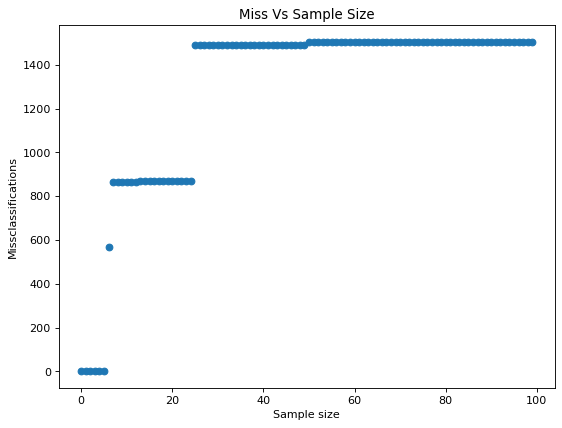

In [8]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)
indx = np.arange(100)
plt.scatter(indx,misses)
plt.xlabel('Sample size')
plt.ylabel('Missclassifications')
plt.title('Miss Vs Sample Size')
plt.show()

In [9]:
'The optimal size to grow is 1-250'

'The optimal size to grow is 1-250'

In [10]:
def q1_2():
    global res_dict
    s = 125
    misses = np.zeros(20)
    # Generate different samples
    for i in range(20):
        X = generate_X(5000)
        training = generate_data(X,0.05)
        training = [[x] for x in training]
        dat = np.append(X,training,1)
        dat[:,0] = np.arange(len(dat))
        build(dat,s)
        misses[i] = calculate_miss(dat[:,-1])
        res_dict = defaultdict()
    return misses
misses = q1_2()
;

Sample Size:  5000
IG:  [0.00000000e+00 9.87018892e-02 1.04128490e-01 1.17485737e-01
 9.47522077e-02 9.78097991e-02 7.21042499e-05 2.65781885e-04
 1.17412932e-04 1.66745092e-05 1.95311216e-04 6.58350053e-05
 4.32126736e-04 4.89791385e-04 2.14522952e-04 5.75583597e-06]
Split at  3

Sample Size:  2490
IG:  [0.00000000e+00 1.17846986e-01 1.21983969e-01 0.00000000e+00
 1.16243688e-01 1.17929921e-01 3.85844417e-04 1.15756346e-03
 4.97105314e-06 3.34608802e-06 8.54446362e-04 2.10353900e-04
 3.62910772e-04 4.18210459e-04 6.09746232e-04 2.15119086e-04]
Split at  2

Sample Size:  1303
IG:  [0.00000000e+00 1.25277538e-01 0.00000000e+00 0.00000000e+00
 1.39804735e-01 1.39161974e-01 7.43426735e-05 2.96169877e-06
 3.98176594e-04 8.62372490e-04 4.45769707e-05 4.90146245e-06
 4.89043587e-06 1.83707002e-04 1.83688927e-04 1.04344115e-03]
Split at  4

Sample Size:  657
return 1

Sample Size:  646
IG:  [0.00000000e+00 2.83482135e-01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.35984053e-01 6.70452555e

IG:  [0.00000000e+00 1.10508437e-01 1.27932040e-01 1.12945748e-01
 0.00000000e+00 1.27150976e-01 4.69915221e-05 3.69098319e-04
 2.79913977e-04 1.28025923e-10 2.65343033e-06 3.84311031e-05
 7.00791743e-05 7.74434536e-06 8.60813213e-04 1.14030734e-04]
Split at  2

Sample Size:  1238
IG:  [0.00000000e+00 1.65858372e-01 0.00000000e+00 1.69457495e-01
 0.00000000e+00 2.07802171e-01 7.75198816e-06 3.27095451e-04
 5.44197481e-04 1.24697940e-03 8.87617689e-05 4.68315767e-04
 2.88313668e-05 4.82636189e-04 8.38384639e-04 1.89389469e-04]
Split at  5

Sample Size:  616
IG:  [0.00000000e+00 2.92400218e-01 0.00000000e+00 2.95455178e-01
 0.00000000e+00 0.00000000e+00 3.05344528e-03 1.18470866e-03
 5.80760749e-04 1.48238393e-05 4.40327429e-04 4.23745584e-03
 1.52793762e-04 2.00508789e-03 1.30847471e-03 1.30586836e-04]
Split at  3

Sample Size:  306
return 1

Sample Size:  310
IG:  [0.00000000e+00 9.98918835e-01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.28845256e-03 1.37966395e-03
 

Sample Size:  5000
IG:  [0.00000000e+00 9.45041236e-02 1.13156088e-01 1.03691659e-01
 1.01787241e-01 9.45926789e-02 1.26743504e-04 2.83864199e-06
 5.33028974e-04 1.08452951e-04 1.15892820e-05 6.67480061e-05
 5.68781626e-05 4.12521299e-05 1.39347043e-04 1.78399332e-05]
Split at  2

Sample Size:  2582
IG:  [0.00000000e+00 1.09267214e-01 0.00000000e+00 1.24967718e-01
 1.14102689e-01 1.22996233e-01 2.02651002e-05 2.96696733e-04
 1.01663327e-04 7.68470207e-05 8.13232954e-04 4.62993754e-05
 3.11248541e-06 2.73455505e-06 1.17134746e-06 2.53807572e-05]
Split at  3

Sample Size:  1282
IG:  [0.00000000e+00 1.30129153e-01 0.00000000e+00 0.00000000e+00
 1.35398819e-01 1.26206139e-01 3.27586023e-04 7.79892232e-07
 2.10254810e-04 9.42301990e-05 3.47325615e-03 1.90969552e-04
 8.89550708e-04 6.76057115e-04 2.23337306e-05 3.12013565e-04]
Split at  4

Sample Size:  655
return 1

Sample Size:  627
IG:  [0.00000000e+00 3.08870868e-01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.01097394e-01 3.44035221e

IG:  [0.00000000e+00 1.36036537e-01 1.04277035e-01 1.21630908e-01
 1.28090970e-01 0.00000000e+00 1.85764383e-05 5.22566664e-04
 4.36967340e-05 6.45052567e-09 6.55439860e-06 2.51413589e-04
 3.34566005e-08 1.30547793e-04 2.32669437e-04 1.69072739e-03]
Split at  1

Sample Size:  1233
IG:  [0.00000000e+00 0.00000000e+00 1.75381630e-01 1.83774659e-01
 2.07481319e-01 0.00000000e+00 1.00054288e-03 1.90711875e-05
 1.88153018e-03 6.66436090e-04 1.06065976e-04 2.93044443e-04
 1.44760987e-04 4.48731310e-04 5.83232256e-05 4.49467741e-03]
Split at  4

Sample Size:  623
IG:  [0.00000000e+00 0.00000000e+00 2.83760569e-01 3.01610570e-01
 0.00000000e+00 0.00000000e+00 3.71864925e-04 2.18722127e-03
 6.02234569e-03 2.78996731e-07 1.80443424e-04 8.35299646e-04
 1.16762517e-03 3.11335506e-03 1.56964497e-03 6.49822991e-03]
Split at  3

Sample Size:  323
return 1

Sample Size:  300
IG:  [0.00000000e+00 0.00000000e+00 9.99198354e-01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.60445868e-04 3.23362367e-03
 

IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 9.99781051e-01 0.00000000e+00 3.73347585e-04 1.11432898e-03
 1.03121044e-03 1.81342685e-04 1.43968162e-03 8.14118836e-04
 2.08583578e-04 2.47910690e-06 6.42130930e-03 1.97254016e-04]
Split at  4

Sample Size:  141
return 1

Sample Size:  146
return -1

Sample Size:  332
return -1

Sample Size:  646
return -1

Sample Size:  5000
IG:  [0.00000000e+00 1.04268204e-01 9.99705419e-02 1.10703945e-01
 9.86896413e-02 1.07094461e-01 4.13921474e-05 2.86548837e-04
 1.44447306e-04 3.40630340e-06 4.15429358e-04 2.15685028e-06
 7.67441682e-06 3.17361366e-06 5.66532961e-04 6.33404921e-05]
Split at  3

Sample Size:  2468
IG:  [0.00000000e+00 1.05758080e-01 1.30975609e-01 0.00000000e+00
 1.14865604e-01 1.24252154e-01 6.18639396e-04 2.18478676e-04
 4.24683198e-04 7.51325349e-05 9.64976177e-04 2.04954253e-04
 2.92957518e-04 2.35493434e-05 7.64729155e-04 4.98542275e-05]
Split at  2

Sample Size:  1256
IG:  [0.00000000e+00 1.23912923e-01 0.0

IG:  [0.00000000e+00 1.19288262e-01 0.00000000e+00 1.22694456e-01
 1.28011689e-01 1.36512879e-01 1.31866292e-04 3.57531997e-04
 2.76312506e-04 6.66156284e-04 1.19245742e-04 3.77179234e-04
 3.80460291e-05 4.43899340e-04 2.05022479e-04 1.07687612e-03]
Split at  5

Sample Size:  1222
IG:  [0.00000000e+00 1.90672336e-01 0.00000000e+00 2.04486345e-01
 1.71457520e-01 0.00000000e+00 3.43704034e-05 1.81125589e-04
 1.70202429e-04 1.12723774e-03 6.39113444e-04 3.17978829e-06
 2.66917928e-04 1.24352154e-06 9.99431122e-04 8.20406624e-04]
Split at  3

Sample Size:  600
IG:  [0.00000000e+00 2.87136679e-01 0.00000000e+00 0.00000000e+00
 2.94764767e-01 0.00000000e+00 8.13091280e-07 2.16321774e-04
 4.61110338e-04 1.85078147e-03 7.46688008e-04 2.96103551e-03
 7.11918353e-03 1.75904079e-04 6.75239509e-03 1.18261570e-03]
Split at  4

Sample Size:  313
return 1

Sample Size:  287
IG:  [0.00000000e+00 9.98028662e-01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 9.93816023e-04 2.14984353e-04
 

IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 9.99991363e-01 6.31548355e-03 2.10812645e-04
 7.79131770e-05 1.07533170e-03 7.31143175e-05 4.25468959e-04
 6.91477896e-04 7.22114278e-05 4.22036275e-04 1.05602478e-03]
Split at  5

Sample Size:  145
return 1

Sample Size:  144
return -1

Sample Size:  303
return -1

Sample Size:  631
return -1

Sample Size:  5000
IG:  [0.00000000e+00 1.00964070e-01 1.10510754e-01 1.09416252e-01
 1.02516139e-01 1.01200887e-01 2.22160893e-04 8.94316926e-05
 3.18679396e-05 2.65147478e-08 3.55212746e-04 1.34644052e-04
 2.17682611e-05 2.11292956e-07 2.74335622e-05 9.42617297e-05]
Split at  2

Sample Size:  2480
IG:  [0.00000000e+00 1.24713880e-01 0.00000000e+00 1.23418738e-01
 1.30857433e-01 1.14020832e-01 9.41220406e-06 5.63396625e-04
 3.83654472e-05 7.51488172e-04 6.38715507e-04 9.41440936e-04
 9.41220406e-06 1.91435551e-04 4.70587679e-05 9.77743506e-04]
Split at  4

Sample Size:  1266
IG:  [0.00000000e+00 1.37684035e-01 0.0

IG:  [0.00000000e+00 0.00000000e+00 1.28502230e-01 1.30879376e-01
 1.22394267e-01 9.70894392e-02 2.19603738e-04 5.81079790e-04
 2.70810408e-04 2.32080832e-04 2.63885024e-05 1.75014873e-03
 3.78307775e-04 2.81872885e-04 4.90383694e-05 2.17664011e-07]
Split at  3

Sample Size:  1202
IG:  [0.00000000e+00 0.00000000e+00 2.17211238e-01 0.00000000e+00
 1.82610418e-01 1.28848324e-01 1.19984628e-05 2.23556258e-03
 4.27837663e-05 7.21554499e-06 1.77637941e-04 8.97014974e-04
 6.22978309e-04 6.73324940e-04 3.80676609e-04 2.03861878e-04]
Split at  2

Sample Size:  598
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.84106682e-01 2.42506194e-01 7.83211931e-07 7.78749057e-04
 2.29651947e-03 1.71801276e-03 2.80115419e-04 3.05350560e-04
 4.12804586e-03 1.66450117e-03 1.04969636e-05 1.15075799e-03]
Split at  4

Sample Size:  313
return 1

Sample Size:  285
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 9.95296914e-01 1.28716853e-04 8.89249827e-05
 

IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 9.97395460e-01 0.00000000e+00 5.07564242e-03 7.64773894e-03
 2.08438727e-03 5.66036333e-04 8.15176597e-05 4.56830103e-03
 1.85009158e-03 4.66145900e-04 2.87316331e-05 1.71581775e-03]
Split at  4

Sample Size:  133
return 1

Sample Size:  150
return -1

Sample Size:  307
return -1

Sample Size:  663
return -1

Sample Size:  5000
IG:  [0.00000000e+00 1.01175114e-01 1.09162517e-01 1.02703980e-01
 1.05983970e-01 9.87288117e-02 7.13063867e-06 7.10762641e-05
 1.32502177e-04 4.29957886e-04 2.29439447e-05 7.64925772e-06
 4.72200962e-05 6.65065946e-04 5.38994705e-05 2.65199488e-04]
Split at  2

Sample Size:  2507
IG:  [0.00000000e+00 1.19004839e-01 0.00000000e+00 1.17633035e-01
 1.26935302e-01 1.22089533e-01 4.60783441e-06 9.75258118e-06
 1.74372304e-04 7.57473976e-04 4.89447665e-05 1.78805283e-05
 1.07645247e-04 6.95872691e-04 5.31656110e-04 5.58092475e-04]
Split at  4

Sample Size:  1285
IG:  [0.00000000e+00 1.41697830e-01 0.0

IG:  [0.00000000e+00 1.22978052e-01 1.22297755e-01 1.18734785e-01
 0.00000000e+00 1.37489269e-01 3.80848721e-04 1.87150454e-05
 5.47721552e-05 4.24612622e-04 6.24882880e-04 1.55654051e-05
 1.85145960e-08 1.88901132e-04 2.56673423e-04 1.04831223e-05]
Split at  5

Sample Size:  1312
IG:  [0.00000000e+00 1.88725228e-01 2.03557152e-01 1.80391573e-01
 0.00000000e+00 0.00000000e+00 3.27136281e-04 4.29783521e-04
 1.35873508e-04 6.69142065e-04 6.04843448e-04 9.67357227e-04
 1.06534647e-04 9.64295031e-04 1.07162039e-04 9.73857661e-11]
Split at  2

Sample Size:  663
IG:  [0.00000000e+00 3.08073089e-01 0.00000000e+00 3.09558114e-01
 0.00000000e+00 0.00000000e+00 9.01136903e-04 1.64564760e-05
 2.26488004e-03 1.77561995e-03 6.78520463e-05 2.50824313e-04
 1.35976968e-04 5.08524271e-04 9.38604854e-05 1.22841541e-03]
Split at  3

Sample Size:  338
return 1

Sample Size:  325
IG:  [0.00000000e+00 9.99938535e-01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.33812064e-04 2.95924529e-03
 

IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 9.99711442e-01 2.44528526e-03 1.14728078e-03
 5.08124642e-04 6.63712860e-03 2.57679018e-03 5.62511539e-04
 4.52037954e-04 1.71392623e-04 1.33985921e-02 1.27944014e-02]
Split at  5

Sample Size:  147
return 1

Sample Size:  153
return -1

Sample Size:  317
return -1

Sample Size:  653
return -1

Sample Size:  5000
IG:  [0.00000000e+00 1.06352339e-01 9.89051829e-02 9.80927958e-02
 1.05940962e-01 1.05217980e-01 2.52153400e-04 2.41112299e-04
 4.91598708e-04 2.22307914e-04 3.10753311e-04 3.82374101e-06
 1.50556801e-04 1.99605939e-06 4.59701463e-05 1.45657431e-04]
Split at  1

Sample Size:  2512
IG:  [0.00000000e+00 0.00000000e+00 1.17804287e-01 1.01093249e-01
 1.35067767e-01 1.34410449e-01 5.10705628e-04 2.68998132e-04
 6.98971641e-04 2.40219289e-04 1.16265379e-03 2.86628014e-05
 3.36914552e-05 4.56190523e-04 7.93561888e-08 3.91685271e-05]
Split at  4

Sample Size:  1271
IG:  [0.00000000e+00 0.00000000e+00 1.2

IG:  [0.00000000e+00 1.25427254e-01 1.11889410e-01 1.18826794e-01
 0.00000000e+00 1.21851872e-01 3.17667398e-04 7.94691882e-08
 1.02415724e-04 8.95276707e-04 1.45307976e-03 6.56827121e-05
 1.90140918e-04 1.36709538e-04 9.75876740e-05 6.81104163e-04]
Split at  1

Sample Size:  1331
IG:  [0.00000000e+00 0.00000000e+00 1.82519865e-01 2.12330524e-01
 0.00000000e+00 1.68395984e-01 4.42227074e-04 6.96633866e-05
 1.41617134e-03 2.04187935e-03 5.78887787e-03 2.96518699e-04
 3.92562475e-04 3.41374657e-04 1.14824178e-04 2.40348434e-03]
Split at  3

Sample Size:  630
IG:  [0.00000000e+00 0.00000000e+00 2.72390618e-01 0.00000000e+00
 0.00000000e+00 2.93566951e-01 3.34982217e-04 5.89049159e-05
 1.46183069e-05 5.12807722e-04 4.84966921e-03 1.26513029e-04
 1.42152405e-04 1.42152405e-04 8.99433085e-04 6.97236685e-05]
Split at  5

Sample Size:  331
return 1

Sample Size:  299
IG:  [0.00000000e+00 0.00000000e+00 9.97666895e-01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 2.29406462e-03 2.93526845e-06
 

Sample Size:  5000
IG:  [0.00000000e+00 1.07972902e-01 1.10130486e-01 1.09259976e-01
 1.08298888e-01 9.36109853e-02 3.21478038e-05 7.28896765e-05
 2.28903161e-04 1.17346590e-05 8.99595019e-04 4.21556000e-05
 4.86901489e-04 2.12522907e-04 2.31933141e-05 5.90629849e-04]
Split at  2

Sample Size:  2487
IG:  [0.00000000e+00 1.28325367e-01 0.00000000e+00 1.31373335e-01
 1.20025415e-01 1.08166205e-01 3.04361570e-05 7.44664470e-06
 8.65568895e-05 1.12199074e-08 1.16429511e-03 7.92189470e-04
 5.15963131e-04 2.39090977e-04 5.11141083e-05 1.12898111e-04]
Split at  3

Sample Size:  1242
IG:  [0.00000000e+00 1.32968134e-01 0.00000000e+00 0.00000000e+00
 1.17120632e-01 1.22034268e-01 2.34524817e-05 2.82997597e-05
 3.39499884e-04 5.84777058e-06 1.28425914e-03 3.56777545e-03
 3.84826169e-03 3.93200216e-04 2.33871652e-07 9.37631595e-05]
Split at  1

Sample Size:  660
return 1

Sample Size:  582
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.87993693e-01 3.05829079e-01 1.43521732e

IG:  [0.00000000e+00 2.07481319e-01 0.00000000e+00 1.83079269e-01
 0.00000000e+00 2.06659546e-01 1.47077583e-04 1.24573397e-03
 1.04041517e-03 6.42564995e-05 7.97317580e-04 1.31495200e-04
 3.97231413e-07 7.17626778e-04 5.31692044e-04 3.75501049e-06]
Split at  1

Sample Size:  623
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 2.83760569e-01
 0.00000000e+00 2.97055138e-01 5.44605505e-04 2.47761932e-03
 1.01819167e-03 5.51455830e-05 1.23953245e-03 2.22945567e-03
 9.96875832e-05 1.07559697e-03 2.78996731e-07 2.55816864e-04]
Split at  5

Sample Size:  320
return 1

Sample Size:  303
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 9.98671752e-01
 0.00000000e+00 0.00000000e+00 1.33952801e-03 2.88257638e-03
 2.73116131e-03 5.51047992e-04 4.21551411e-03 4.21551411e-03
 5.96129665e-04 2.36165491e-05 1.64530157e-03 5.96129665e-04]
Split at  3

Sample Size:  158
return 1

Sample Size:  145
return -1

Sample Size:  610
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.18486289e-01
 0.000

''

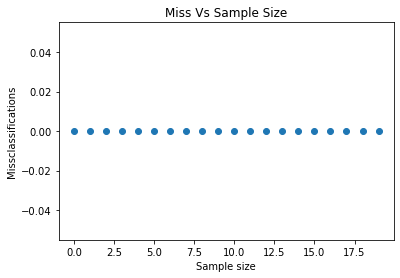

In [11]:
indx = np.arange(20)
plt.scatter(indx,misses)
plt.xlabel('Sample size')
plt.ylabel('Missclassifications')
plt.title('Miss Vs Sample Size')
plt.show()

In [12]:
'The optimal size is consistent'

'The optimal size is consistent'

In [13]:
def q1_3():
    global res_dict
    s = 125
    misses = np.zeros(100)
    X = generate_X(5000)
    for i in range(100):
        # Change sigma
        training = generate_data(X,i*0.01)
        training = [[x] for x in training]
        dat = np.append(X,training,1)
        dat[:,0] = np.arange(len(dat))
        build(dat,s)
        misses[i] = calculate_miss(dat[:,-1])
        res_dict = defaultdict()
    return misses
misses = q1_3()

Sample Size:  5000
IG:  [0.00000000e+00 1.08904724e-01 1.11723749e-01 9.97879355e-02
 1.01222438e-01 1.07277916e-01 3.03644204e-05 1.09995471e-04
 4.13013958e-05 4.61478242e-06 1.04269689e-04 4.13635370e-04
 9.09599089e-05 2.54079259e-04 7.98190499e-06 1.62701630e-05]
Split at  2

Sample Size:  2519
IG:  [0.00000000e+00 1.34604966e-01 0.00000000e+00 1.21721026e-01
 1.11806506e-01 1.30546519e-01 2.41900739e-04 7.21962704e-04
 3.21744164e-05 1.58161222e-05 9.17903311e-04 7.59110168e-05
 1.37597995e-04 1.60260789e-04 2.61098417e-04 5.56573759e-05]
Split at  1

Sample Size:  1259
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.31633982e-01
 1.17767317e-01 1.33493561e-01 8.85667334e-05 2.22281095e-03
 2.78448943e-04 5.85210759e-05 1.91922634e-03 8.07966530e-05
 1.87759491e-03 2.87486202e-05 1.45632266e-05 2.29136806e-04]
Split at  5

Sample Size:  667
return 1

Sample Size:  592
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20748830e-01
 2.74400575e-01 0.00000000e+00 6.70269439e

IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.90040748e-01
 1.98917116e-01 1.86191843e-01 8.76894173e-04 5.19750926e-04
 6.12993711e-06 2.72037148e-04 2.08965090e-03 2.36767449e-03
 8.60954736e-05 1.15592040e-04 1.78631004e-04 2.81718337e-05]
Split at  4

Sample Size:  625
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.13331805e-01
 0.00000000e+00 2.99228628e-01 2.72555133e-05 2.72555133e-05
 3.76945641e-04 9.10373299e-03 8.70635434e-04 1.87653320e-05
 6.75747340e-04 6.62439233e-04 5.12759717e-05 1.36240754e-04]
Split at  3

Sample Size:  319
return 1

Sample Size:  306
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 4.93116701e-04 1.23268638e-04
 4.46511508e-03 6.97455301e-03 3.73247016e-03 1.97314188e-03
 4.93285384e-04 4.93116701e-04 7.96107969e-03 1.97720558e-03]
Split at  5

Sample Size:  153
return 1

Sample Size:  153
return -1

Sample Size:  635
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.03319110e-01
 0.000

Sample Size:  5000
IG:  [0.00000000e+00 1.08904724e-01 1.11723749e-01 9.97879355e-02
 1.01222438e-01 1.07277916e-01 3.03644204e-05 1.09995471e-04
 4.13013958e-05 4.61478242e-06 1.04269689e-04 4.13635370e-04
 9.09599089e-05 2.54079259e-04 7.98190499e-06 1.62701630e-05]
Split at  2

Sample Size:  2519
IG:  [0.00000000e+00 1.34604966e-01 0.00000000e+00 1.21721026e-01
 1.11806506e-01 1.30546519e-01 2.41900739e-04 7.21962704e-04
 3.21744164e-05 1.58161222e-05 9.17903311e-04 7.59110168e-05
 1.37597995e-04 1.60260789e-04 2.61098417e-04 5.56573759e-05]
Split at  1

Sample Size:  1259
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.31633982e-01
 1.17767317e-01 1.33493561e-01 8.85667334e-05 2.22281095e-03
 2.78448943e-04 5.85210759e-05 1.91922634e-03 8.07966530e-05
 1.87759491e-03 2.87486202e-05 1.45632266e-05 2.29136806e-04]
Split at  5

Sample Size:  667
return 1

Sample Size:  592
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20748830e-01
 2.74400575e-01 0.00000000e+00 6.70269439e

IG:  [0.00000000e+00 1.35392686e-01 0.00000000e+00 1.16652590e-01
 1.28944549e-01 1.14553011e-01 3.96800290e-04 3.08500478e-05
 1.39318143e-04 6.22227903e-05 2.76533906e-05 5.97774610e-04
 8.50863337e-06 4.97391325e-05 3.92071130e-04 3.18906987e-05]
Split at  1

Sample Size:  1260
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.90040748e-01
 1.98917116e-01 1.86191843e-01 8.76894173e-04 5.19750926e-04
 6.12993711e-06 2.72037148e-04 2.08965090e-03 2.36767449e-03
 8.60954736e-05 1.15592040e-04 1.78631004e-04 2.81718337e-05]
Split at  4

Sample Size:  625
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.13331805e-01
 0.00000000e+00 2.99228628e-01 2.72555133e-05 2.72555133e-05
 3.76945641e-04 9.10373299e-03 8.70635434e-04 1.87653320e-05
 6.75747340e-04 6.62439233e-04 5.12759717e-05 1.36240754e-04]
Split at  3

Sample Size:  319
return 1

Sample Size:  306
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 4.93116701e-04 1.23268638e-04
 

IG:  [0.00000000e+00 1.08904724e-01 1.11723749e-01 9.97879355e-02
 1.01222438e-01 1.07277916e-01 3.03644204e-05 1.09995471e-04
 4.13013958e-05 4.61478242e-06 1.04269689e-04 4.13635370e-04
 9.09599089e-05 2.54079259e-04 7.98190499e-06 1.62701630e-05]
Split at  2

Sample Size:  2519
IG:  [0.00000000e+00 1.34604966e-01 0.00000000e+00 1.21721026e-01
 1.11806506e-01 1.30546519e-01 2.41900739e-04 7.21962704e-04
 3.21744164e-05 1.58161222e-05 9.17903311e-04 7.59110168e-05
 1.37597995e-04 1.60260789e-04 2.61098417e-04 5.56573759e-05]
Split at  1

Sample Size:  1259
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.31633982e-01
 1.17767317e-01 1.33493561e-01 8.85667334e-05 2.22281095e-03
 2.78448943e-04 5.85210759e-05 1.91922634e-03 8.07966530e-05
 1.87759491e-03 2.87486202e-05 1.45632266e-05 2.29136806e-04]
Split at  5

Sample Size:  667
return 1

Sample Size:  592
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20748830e-01
 2.74400575e-01 0.00000000e+00 6.70269439e-05 3.04526329e-03


IG:  [0.00000000e+00 1.35392686e-01 0.00000000e+00 1.16652590e-01
 1.28944549e-01 1.14553011e-01 3.96800290e-04 3.08500478e-05
 1.39318143e-04 6.22227903e-05 2.76533906e-05 5.97774610e-04
 8.50863337e-06 4.97391325e-05 3.92071130e-04 3.18906987e-05]
Split at  1

Sample Size:  1260
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.90040748e-01
 1.98917116e-01 1.86191843e-01 8.76894173e-04 5.19750926e-04
 6.12993711e-06 2.72037148e-04 2.08965090e-03 2.36767449e-03
 8.60954736e-05 1.15592040e-04 1.78631004e-04 2.81718337e-05]
Split at  4

Sample Size:  625
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.13331805e-01
 0.00000000e+00 2.99228628e-01 2.72555133e-05 2.72555133e-05
 3.76945641e-04 9.10373299e-03 8.70635434e-04 1.87653320e-05
 6.75747340e-04 6.62439233e-04 5.12759717e-05 1.36240754e-04]
Split at  3

Sample Size:  319
return 1

Sample Size:  306
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 4.93116701e-04 1.23268638e-04
 

IG:  [0.00000000e+00 1.08904724e-01 1.11723749e-01 9.97879355e-02
 1.01222438e-01 1.07277916e-01 3.03644204e-05 1.09995471e-04
 4.13013958e-05 4.61478242e-06 1.04269689e-04 4.13635370e-04
 9.09599089e-05 2.54079259e-04 7.98190499e-06 1.62701630e-05]
Split at  2

Sample Size:  2519
IG:  [0.00000000e+00 1.34604966e-01 0.00000000e+00 1.21721026e-01
 1.11806506e-01 1.30546519e-01 2.41900739e-04 7.21962704e-04
 3.21744164e-05 1.58161222e-05 9.17903311e-04 7.59110168e-05
 1.37597995e-04 1.60260789e-04 2.61098417e-04 5.56573759e-05]
Split at  1

Sample Size:  1259
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.31633982e-01
 1.17767317e-01 1.33493561e-01 8.85667334e-05 2.22281095e-03
 2.78448943e-04 5.85210759e-05 1.91922634e-03 8.07966530e-05
 1.87759491e-03 2.87486202e-05 1.45632266e-05 2.29136806e-04]
Split at  5

Sample Size:  667
return 1

Sample Size:  592
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20748830e-01
 2.74400575e-01 0.00000000e+00 6.70269439e-05 3.04526329e-03


IG:  [0.00000000e+00 1.35392686e-01 0.00000000e+00 1.16652590e-01
 1.28944549e-01 1.14553011e-01 3.96800290e-04 3.08500478e-05
 1.39318143e-04 6.22227903e-05 2.76533906e-05 5.97774610e-04
 8.50863337e-06 4.97391325e-05 3.92071130e-04 3.18906987e-05]
Split at  1

Sample Size:  1260
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.90040748e-01
 1.98917116e-01 1.86191843e-01 8.76894173e-04 5.19750926e-04
 6.12993711e-06 2.72037148e-04 2.08965090e-03 2.36767449e-03
 8.60954736e-05 1.15592040e-04 1.78631004e-04 2.81718337e-05]
Split at  4

Sample Size:  625
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.13331805e-01
 0.00000000e+00 2.99228628e-01 2.72555133e-05 2.72555133e-05
 3.76945641e-04 9.10373299e-03 8.70635434e-04 1.87653320e-05
 6.75747340e-04 6.62439233e-04 5.12759717e-05 1.36240754e-04]
Split at  3

Sample Size:  319
return 1

Sample Size:  306
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 4.93116701e-04 1.23268638e-04
 

IG:  [0.00000000e+00 1.08904724e-01 1.11723749e-01 9.97879355e-02
 1.01222438e-01 1.07277916e-01 3.03644204e-05 1.09995471e-04
 4.13013958e-05 4.61478242e-06 1.04269689e-04 4.13635370e-04
 9.09599089e-05 2.54079259e-04 7.98190499e-06 1.62701630e-05]
Split at  2

Sample Size:  2519
IG:  [0.00000000e+00 1.34604966e-01 0.00000000e+00 1.21721026e-01
 1.11806506e-01 1.30546519e-01 2.41900739e-04 7.21962704e-04
 3.21744164e-05 1.58161222e-05 9.17903311e-04 7.59110168e-05
 1.37597995e-04 1.60260789e-04 2.61098417e-04 5.56573759e-05]
Split at  1

Sample Size:  1259
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.31633982e-01
 1.17767317e-01 1.33493561e-01 8.85667334e-05 2.22281095e-03
 2.78448943e-04 5.85210759e-05 1.91922634e-03 8.07966530e-05
 1.87759491e-03 2.87486202e-05 1.45632266e-05 2.29136806e-04]
Split at  5

Sample Size:  667
return 1

Sample Size:  592
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20748830e-01
 2.74400575e-01 0.00000000e+00 6.70269439e-05 3.04526329e-03


IG:  [0.00000000e+00 1.35392686e-01 0.00000000e+00 1.16652590e-01
 1.28944549e-01 1.14553011e-01 3.96800290e-04 3.08500478e-05
 1.39318143e-04 6.22227903e-05 2.76533906e-05 5.97774610e-04
 8.50863337e-06 4.97391325e-05 3.92071130e-04 3.18906987e-05]
Split at  1

Sample Size:  1260
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.90040748e-01
 1.98917116e-01 1.86191843e-01 8.76894173e-04 5.19750926e-04
 6.12993711e-06 2.72037148e-04 2.08965090e-03 2.36767449e-03
 8.60954736e-05 1.15592040e-04 1.78631004e-04 2.81718337e-05]
Split at  4

Sample Size:  625
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.13331805e-01
 0.00000000e+00 2.99228628e-01 2.72555133e-05 2.72555133e-05
 3.76945641e-04 9.10373299e-03 8.70635434e-04 1.87653320e-05
 6.75747340e-04 6.62439233e-04 5.12759717e-05 1.36240754e-04]
Split at  3

Sample Size:  319
return 1

Sample Size:  306
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 4.93116701e-04 1.23268638e-04
 

IG:  [0.00000000e+00 1.08904724e-01 1.11723749e-01 9.97879355e-02
 1.01222438e-01 1.07277916e-01 3.03644204e-05 1.09995471e-04
 4.13013958e-05 4.61478242e-06 1.04269689e-04 4.13635370e-04
 9.09599089e-05 2.54079259e-04 7.98190499e-06 1.62701630e-05]
Split at  2

Sample Size:  2519
IG:  [0.00000000e+00 1.34604966e-01 0.00000000e+00 1.21721026e-01
 1.11806506e-01 1.30546519e-01 2.41900739e-04 7.21962704e-04
 3.21744164e-05 1.58161222e-05 9.17903311e-04 7.59110168e-05
 1.37597995e-04 1.60260789e-04 2.61098417e-04 5.56573759e-05]
Split at  1

Sample Size:  1259
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.31633982e-01
 1.17767317e-01 1.33493561e-01 8.85667334e-05 2.22281095e-03
 2.78448943e-04 5.85210759e-05 1.91922634e-03 8.07966530e-05
 1.87759491e-03 2.87486202e-05 1.45632266e-05 2.29136806e-04]
Split at  5

Sample Size:  667
return 1

Sample Size:  592
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20748830e-01
 2.74400575e-01 0.00000000e+00 6.70269439e-05 3.04526329e-03


IG:  [0.00000000e+00 1.35392686e-01 0.00000000e+00 1.16652590e-01
 1.28944549e-01 1.14553011e-01 3.96800290e-04 3.08500478e-05
 1.39318143e-04 6.22227903e-05 2.76533906e-05 5.97774610e-04
 8.50863337e-06 4.97391325e-05 3.92071130e-04 3.18906987e-05]
Split at  1

Sample Size:  1260
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.90040748e-01
 1.98917116e-01 1.86191843e-01 8.76894173e-04 5.19750926e-04
 6.12993711e-06 2.72037148e-04 2.08965090e-03 2.36767449e-03
 8.60954736e-05 1.15592040e-04 1.78631004e-04 2.81718337e-05]
Split at  4

Sample Size:  625
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.13331805e-01
 0.00000000e+00 2.99228628e-01 2.72555133e-05 2.72555133e-05
 3.76945641e-04 9.10373299e-03 8.70635434e-04 1.87653320e-05
 6.75747340e-04 6.62439233e-04 5.12759717e-05 1.36240754e-04]
Split at  3

Sample Size:  319
return 1

Sample Size:  306
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 4.93116701e-04 1.23268638e-04
 

IG:  [0.00000000e+00 1.08904724e-01 1.11723749e-01 9.97879355e-02
 1.01222438e-01 1.07277916e-01 3.03644204e-05 1.09995471e-04
 4.13013958e-05 4.61478242e-06 1.04269689e-04 4.13635370e-04
 9.09599089e-05 2.54079259e-04 7.98190499e-06 1.62701630e-05]
Split at  2

Sample Size:  2519
IG:  [0.00000000e+00 1.34604966e-01 0.00000000e+00 1.21721026e-01
 1.11806506e-01 1.30546519e-01 2.41900739e-04 7.21962704e-04
 3.21744164e-05 1.58161222e-05 9.17903311e-04 7.59110168e-05
 1.37597995e-04 1.60260789e-04 2.61098417e-04 5.56573759e-05]
Split at  1

Sample Size:  1259
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.31633982e-01
 1.17767317e-01 1.33493561e-01 8.85667334e-05 2.22281095e-03
 2.78448943e-04 5.85210759e-05 1.91922634e-03 8.07966530e-05
 1.87759491e-03 2.87486202e-05 1.45632266e-05 2.29136806e-04]
Split at  5

Sample Size:  667
return 1

Sample Size:  592
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20748830e-01
 2.74400575e-01 0.00000000e+00 6.70269439e-05 3.04526329e-03


IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.90040748e-01
 1.98917116e-01 1.86191843e-01 8.76894173e-04 5.19750926e-04
 6.12993711e-06 2.72037148e-04 2.08965090e-03 2.36767449e-03
 8.60954736e-05 1.15592040e-04 1.78631004e-04 2.81718337e-05]
Split at  4

Sample Size:  625
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.13331805e-01
 0.00000000e+00 2.99228628e-01 2.72555133e-05 2.72555133e-05
 3.76945641e-04 9.10373299e-03 8.70635434e-04 1.87653320e-05
 6.75747340e-04 6.62439233e-04 5.12759717e-05 1.36240754e-04]
Split at  3

Sample Size:  319
return 1

Sample Size:  306
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 4.93116701e-04 1.23268638e-04
 4.46511508e-03 6.97455301e-03 3.73247016e-03 1.97314188e-03
 4.93285384e-04 4.93116701e-04 7.96107969e-03 1.97720558e-03]
Split at  5

Sample Size:  153
return 1

Sample Size:  153
return -1

Sample Size:  635
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.03319110e-01
 0.000

IG:  [0.00000000e+00 1.08904724e-01 1.11723749e-01 9.97879355e-02
 1.01222438e-01 1.07277916e-01 3.03644204e-05 1.09995471e-04
 4.13013958e-05 4.61478242e-06 1.04269689e-04 4.13635370e-04
 9.09599089e-05 2.54079259e-04 7.98190499e-06 1.62701630e-05]
Split at  2

Sample Size:  2519
IG:  [0.00000000e+00 1.34604966e-01 0.00000000e+00 1.21721026e-01
 1.11806506e-01 1.30546519e-01 2.41900739e-04 7.21962704e-04
 3.21744164e-05 1.58161222e-05 9.17903311e-04 7.59110168e-05
 1.37597995e-04 1.60260789e-04 2.61098417e-04 5.56573759e-05]
Split at  1

Sample Size:  1259
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.31633982e-01
 1.17767317e-01 1.33493561e-01 8.85667334e-05 2.22281095e-03
 2.78448943e-04 5.85210759e-05 1.91922634e-03 8.07966530e-05
 1.87759491e-03 2.87486202e-05 1.45632266e-05 2.29136806e-04]
Split at  5

Sample Size:  667
return 1

Sample Size:  592
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20748830e-01
 2.74400575e-01 0.00000000e+00 6.70269439e-05 3.04526329e-03


IG:  [0.00000000e+00 1.35392686e-01 0.00000000e+00 1.16652590e-01
 1.28944549e-01 1.14553011e-01 3.96800290e-04 3.08500478e-05
 1.39318143e-04 6.22227903e-05 2.76533906e-05 5.97774610e-04
 8.50863337e-06 4.97391325e-05 3.92071130e-04 3.18906987e-05]
Split at  1

Sample Size:  1260
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.90040748e-01
 1.98917116e-01 1.86191843e-01 8.76894173e-04 5.19750926e-04
 6.12993711e-06 2.72037148e-04 2.08965090e-03 2.36767449e-03
 8.60954736e-05 1.15592040e-04 1.78631004e-04 2.81718337e-05]
Split at  4

Sample Size:  625
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.13331805e-01
 0.00000000e+00 2.99228628e-01 2.72555133e-05 2.72555133e-05
 3.76945641e-04 9.10373299e-03 8.70635434e-04 1.87653320e-05
 6.75747340e-04 6.62439233e-04 5.12759717e-05 1.36240754e-04]
Split at  3

Sample Size:  319
return 1

Sample Size:  306
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 4.93116701e-04 1.23268638e-04
 

IG:  [0.00000000e+00 1.08904724e-01 1.11723749e-01 9.97879355e-02
 1.01222438e-01 1.07277916e-01 3.03644204e-05 1.09995471e-04
 4.13013958e-05 4.61478242e-06 1.04269689e-04 4.13635370e-04
 9.09599089e-05 2.54079259e-04 7.98190499e-06 1.62701630e-05]
Split at  2

Sample Size:  2519
IG:  [0.00000000e+00 1.34604966e-01 0.00000000e+00 1.21721026e-01
 1.11806506e-01 1.30546519e-01 2.41900739e-04 7.21962704e-04
 3.21744164e-05 1.58161222e-05 9.17903311e-04 7.59110168e-05
 1.37597995e-04 1.60260789e-04 2.61098417e-04 5.56573759e-05]
Split at  1

Sample Size:  1259
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.31633982e-01
 1.17767317e-01 1.33493561e-01 8.85667334e-05 2.22281095e-03
 2.78448943e-04 5.85210759e-05 1.91922634e-03 8.07966530e-05
 1.87759491e-03 2.87486202e-05 1.45632266e-05 2.29136806e-04]
Split at  5

Sample Size:  667
return 1

Sample Size:  592
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20748830e-01
 2.74400575e-01 0.00000000e+00 6.70269439e-05 3.04526329e-03


IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.90040748e-01
 1.98917116e-01 1.86191843e-01 8.76894173e-04 5.19750926e-04
 6.12993711e-06 2.72037148e-04 2.08965090e-03 2.36767449e-03
 8.60954736e-05 1.15592040e-04 1.78631004e-04 2.81718337e-05]
Split at  4

Sample Size:  625
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.13331805e-01
 0.00000000e+00 2.99228628e-01 2.72555133e-05 2.72555133e-05
 3.76945641e-04 9.10373299e-03 8.70635434e-04 1.87653320e-05
 6.75747340e-04 6.62439233e-04 5.12759717e-05 1.36240754e-04]
Split at  3

Sample Size:  319
return 1

Sample Size:  306
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 4.93116701e-04 1.23268638e-04
 4.46511508e-03 6.97455301e-03 3.73247016e-03 1.97314188e-03
 4.93285384e-04 4.93116701e-04 7.96107969e-03 1.97720558e-03]
Split at  5

Sample Size:  153
return 1

Sample Size:  153
return -1

Sample Size:  635
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.03319110e-01
 0.000

IG:  [0.00000000e+00 1.08904724e-01 1.11723749e-01 9.97879355e-02
 1.01222438e-01 1.07277916e-01 3.03644204e-05 1.09995471e-04
 4.13013958e-05 4.61478242e-06 1.04269689e-04 4.13635370e-04
 9.09599089e-05 2.54079259e-04 7.98190499e-06 1.62701630e-05]
Split at  2

Sample Size:  2519
IG:  [0.00000000e+00 1.34604966e-01 0.00000000e+00 1.21721026e-01
 1.11806506e-01 1.30546519e-01 2.41900739e-04 7.21962704e-04
 3.21744164e-05 1.58161222e-05 9.17903311e-04 7.59110168e-05
 1.37597995e-04 1.60260789e-04 2.61098417e-04 5.56573759e-05]
Split at  1

Sample Size:  1259
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.31633982e-01
 1.17767317e-01 1.33493561e-01 8.85667334e-05 2.22281095e-03
 2.78448943e-04 5.85210759e-05 1.91922634e-03 8.07966530e-05
 1.87759491e-03 2.87486202e-05 1.45632266e-05 2.29136806e-04]
Split at  5

Sample Size:  667
return 1

Sample Size:  592
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20748830e-01
 2.74400575e-01 0.00000000e+00 6.70269439e-05 3.04526329e-03


IG:  [0.00000000e+00 1.35392686e-01 0.00000000e+00 1.16652590e-01
 1.28944549e-01 1.14553011e-01 3.96800290e-04 3.08500478e-05
 1.39318143e-04 6.22227903e-05 2.76533906e-05 5.97774610e-04
 8.50863337e-06 4.97391325e-05 3.92071130e-04 3.18906987e-05]
Split at  1

Sample Size:  1260
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.90040748e-01
 1.98917116e-01 1.86191843e-01 8.76894173e-04 5.19750926e-04
 6.12993711e-06 2.72037148e-04 2.08965090e-03 2.36767449e-03
 8.60954736e-05 1.15592040e-04 1.78631004e-04 2.81718337e-05]
Split at  4

Sample Size:  625
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.13331805e-01
 0.00000000e+00 2.99228628e-01 2.72555133e-05 2.72555133e-05
 3.76945641e-04 9.10373299e-03 8.70635434e-04 1.87653320e-05
 6.75747340e-04 6.62439233e-04 5.12759717e-05 1.36240754e-04]
Split at  3

Sample Size:  319
return 1

Sample Size:  306
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 4.93116701e-04 1.23268638e-04
 

IG:  [0.00000000e+00 1.08904724e-01 1.11723749e-01 9.97879355e-02
 1.01222438e-01 1.07277916e-01 3.03644204e-05 1.09995471e-04
 4.13013958e-05 4.61478242e-06 1.04269689e-04 4.13635370e-04
 9.09599089e-05 2.54079259e-04 7.98190499e-06 1.62701630e-05]
Split at  2

Sample Size:  2519
IG:  [0.00000000e+00 1.34604966e-01 0.00000000e+00 1.21721026e-01
 1.11806506e-01 1.30546519e-01 2.41900739e-04 7.21962704e-04
 3.21744164e-05 1.58161222e-05 9.17903311e-04 7.59110168e-05
 1.37597995e-04 1.60260789e-04 2.61098417e-04 5.56573759e-05]
Split at  1

Sample Size:  1259
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.31633982e-01
 1.17767317e-01 1.33493561e-01 8.85667334e-05 2.22281095e-03
 2.78448943e-04 5.85210759e-05 1.91922634e-03 8.07966530e-05
 1.87759491e-03 2.87486202e-05 1.45632266e-05 2.29136806e-04]
Split at  5

Sample Size:  667
return 1

Sample Size:  592
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20748830e-01
 2.74400575e-01 0.00000000e+00 6.70269439e-05 3.04526329e-03


IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.90040748e-01
 1.98917116e-01 1.86191843e-01 8.76894173e-04 5.19750926e-04
 6.12993711e-06 2.72037148e-04 2.08965090e-03 2.36767449e-03
 8.60954736e-05 1.15592040e-04 1.78631004e-04 2.81718337e-05]
Split at  4

Sample Size:  625
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.13331805e-01
 0.00000000e+00 2.99228628e-01 2.72555133e-05 2.72555133e-05
 3.76945641e-04 9.10373299e-03 8.70635434e-04 1.87653320e-05
 6.75747340e-04 6.62439233e-04 5.12759717e-05 1.36240754e-04]
Split at  3

Sample Size:  319
return 1

Sample Size:  306
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 4.93116701e-04 1.23268638e-04
 4.46511508e-03 6.97455301e-03 3.73247016e-03 1.97314188e-03
 4.93285384e-04 4.93116701e-04 7.96107969e-03 1.97720558e-03]
Split at  5

Sample Size:  153
return 1

Sample Size:  153
return -1

Sample Size:  635
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.03319110e-01
 0.000

IG:  [0.00000000e+00 1.09375086e-01 1.12200670e-01 9.93491703e-02
 1.00764807e-01 1.06821490e-01 3.02026724e-05 9.63787763e-05
 3.30948481e-05 7.87506735e-06 1.18524942e-04 4.14031315e-04
 1.04282328e-04 2.54259845e-04 7.86246462e-06 1.13083951e-05]
Split at  2

Sample Size:  2519
IG:  [0.00000000e+00 1.34604966e-01 0.00000000e+00 1.21721026e-01
 1.11806506e-01 1.30546519e-01 2.41900739e-04 7.21962704e-04
 3.21744164e-05 1.58161222e-05 9.17903311e-04 7.59110168e-05
 1.37597995e-04 1.60260789e-04 2.61098417e-04 5.56573759e-05]
Split at  1

Sample Size:  1259
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.31633982e-01
 1.17767317e-01 1.33493561e-01 8.85667334e-05 2.22281095e-03
 2.78448943e-04 5.85210759e-05 1.91922634e-03 8.07966530e-05
 1.87759491e-03 2.87486202e-05 1.45632266e-05 2.29136806e-04]
Split at  5

Sample Size:  667
return 1

Sample Size:  592
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20748830e-01
 2.74400575e-01 0.00000000e+00 6.70269439e-05 3.04526329e-03


IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.90040748e-01
 1.98917116e-01 1.86191843e-01 8.76894173e-04 5.19750926e-04
 6.12993711e-06 2.72037148e-04 2.08965090e-03 2.36767449e-03
 8.60954736e-05 1.15592040e-04 1.78631004e-04 2.81718337e-05]
Split at  4

Sample Size:  625
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.13331805e-01
 0.00000000e+00 2.99228628e-01 2.72555133e-05 2.72555133e-05
 3.76945641e-04 9.10373299e-03 8.70635434e-04 1.87653320e-05
 6.75747340e-04 6.62439233e-04 5.12759717e-05 1.36240754e-04]
Split at  3

Sample Size:  319
return 1

Sample Size:  306
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 4.93116701e-04 1.23268638e-04
 4.46511508e-03 6.97455301e-03 3.73247016e-03 1.97314188e-03
 4.93285384e-04 4.93116701e-04 7.96107969e-03 1.97720558e-03]
Split at  5

Sample Size:  153
return 1

Sample Size:  153
return -1

Sample Size:  635
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.03319110e-01
 0.000

IG:  [0.00000000e+00 1.10303337e-01 1.12666034e-01 9.88886864e-02
 9.99007938e-02 1.05883097e-01 3.86813217e-05 1.24312802e-04
 3.28988170e-05 4.80367814e-06 1.50245560e-04 4.12845628e-04
 1.04584546e-04 2.75829676e-04 1.25845452e-05 1.61303752e-05]
Split at  2

Sample Size:  2519
IG:  [0.00000000e+00 1.37492914e-01 0.00000000e+00 1.19902825e-01
 1.10108787e-01 1.28631489e-01 1.98190108e-04 8.05259216e-04
 3.21499509e-05 1.63392122e-05 1.10928800e-03 7.46171082e-05
 1.73900814e-04 1.58582621e-04 2.59270361e-04 7.95305653e-05]
Split at  1

Sample Size:  1259
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.27545224e-01
 1.14125403e-01 1.29344492e-01 2.03957200e-04 2.72240830e-03
 2.79772007e-04 5.75871139e-05 2.85232707e-03 8.60254756e-05
 1.58551695e-03 2.46827348e-05 1.45649394e-05 1.28872964e-04]
Split at  5

Sample Size:  667
return 1

Sample Size:  592
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.09302015e-01
 2.64788976e-01 0.00000000e+00 2.53479492e-04 3.99990618e-03


IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.28586462e-04 9.54435747e-03
 4.78265084e-03 1.05939273e-06 9.95823353e-03 5.19748661e-05
 2.40454400e-03 4.78265084e-03 1.05939273e-06 3.73654914e-03]
Split at  10

Sample Size:  83
Size Threshold Met
+1:  1 -1:  82
return -1

Sample Size:  58
Size Threshold Met
+1:  3 -1:  55
return -1

Sample Size:  1260
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.72848046e-01
 1.88715212e-01 1.97663107e-01 1.17879390e-04 5.88133697e-04
 1.32100559e-03 1.17675705e-04 1.85923274e-03 1.85513831e-03
 1.05015773e-03 1.62539888e-05 1.74042040e-03 5.93945249e-09]
Split at  5

Sample Size:  640
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 2.95767084e-01
 3.14103519e-01 0.00000000e+00 2.30917862e-06 3.38199384e-04
 7.46511414e-04 3.99490220e-04 4.14903326e-03 1.22587078e-03
 1.23866186e-03 3.78886780e-05 2.53999465e-03 1.01998960e-05]
Split at  4

Sample Size:  325
return 1

Sample Size:  315
IG:

IG:  [0.00000000e+00 1.38391145e-01 0.00000000e+00 1.14891542e-01
 1.27034587e-01 1.12768398e-01 3.37242043e-04 5.08524789e-05
 1.78176087e-04 1.21208667e-04 4.56642039e-05 6.74441875e-04
 8.95230619e-06 7.24778294e-05 3.32611245e-04 3.26259306e-05]
Split at  1

Sample Size:  1260
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.90040748e-01
 1.98917116e-01 1.86191843e-01 8.76894173e-04 5.19750926e-04
 6.12993711e-06 2.72037148e-04 2.08965090e-03 2.36767449e-03
 8.60954736e-05 1.15592040e-04 1.78631004e-04 2.81718337e-05]
Split at  4

Sample Size:  625
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.13331805e-01
 0.00000000e+00 2.99228628e-01 2.72555133e-05 2.72555133e-05
 3.76945641e-04 9.10373299e-03 8.70635434e-04 1.87653320e-05
 6.75747340e-04 6.62439233e-04 5.12759717e-05 1.36240754e-04]
Split at  3

Sample Size:  319
return 1

Sample Size:  306
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 4.93116701e-04 1.23268638e-04
 

IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.15051259e-01
 1.24668202e-01 1.17902594e-01 2.93214519e-04 2.70303312e-03
 2.50314031e-04 1.47331995e-04 3.05158062e-03 1.31572658e-03
 2.30242511e-04 3.24164575e-05 2.71762836e-04 1.31572658e-03]
Split at  4

Sample Size:  583
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 2.73096292e-01
 0.00000000e+00 3.09131835e-01 4.10769643e-04 2.98535381e-03
 6.80289598e-04 4.63936891e-04 6.73192223e-03 2.34253159e-03
 5.05802599e-05 7.79190537e-05 4.63936891e-04 1.52125680e-03]
Split at  5

Sample Size:  268
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 9.22315088e-01
 0.00000000e+00 0.00000000e+00 5.24132833e-04 3.62333674e-03
 1.00506411e-03 4.69794152e-03 1.04754810e-02 1.04072252e-02
 5.58194858e-04 2.53200944e-03 6.22065612e-04 1.17122028e-02]
Split at  3

Sample Size:  134
IG:  [0.         0.         0.         0.         0.         0.
 0.00320714 0.01609666 0.02325494 0.00170959 0.01732351 0.02696622
 0.00113932 0.00221391 0.0

IG:  [0.00000000e+00 1.13865332e-01 1.14823516e-01 9.69200895e-02
 9.65661262e-02 1.02480474e-01 2.66589408e-05 1.03074663e-04
 6.60677282e-05 1.24904743e-06 8.44577991e-05 4.56349676e-04
 1.11388706e-04 3.11225126e-04 9.95096484e-06 2.55758297e-05]
Split at  2

Sample Size:  2519
IG:  [0.00000000e+00 1.42618724e-01 0.00000000e+00 1.18998401e-01
 1.06141838e-01 1.24302548e-01 3.41348393e-04 8.92034129e-04
 7.40305167e-05 1.29771015e-06 9.24626520e-04 5.08771679e-05
 1.37262570e-04 2.87756395e-04 2.58359470e-04 1.40417715e-04]
Split at  1

Sample Size:  1259
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.22467193e-01
 1.09600759e-01 1.24191807e-01 1.67866865e-07 3.06355378e-03
 2.12613380e-04 1.99355760e-04 1.89591332e-03 9.22414439e-06
 1.49325748e-03 1.22648085e-04 2.61184084e-06 2.90108304e-05]
Split at  5

Sample Size:  667
return 1

Sample Size:  592
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 2.95258375e-01
 2.52974121e-01 0.00000000e+00 4.89734950e-05 4.67746198e-03


IG:  [0.00000000e+00 1.43965936e-01 0.00000000e+00 1.12058780e-01
 1.23999144e-01 1.08872672e-01 3.91425297e-04 1.79897049e-05
 1.08736167e-04 4.46525344e-05 5.29962036e-06 8.40186009e-04
 2.07717830e-05 3.03531174e-05 1.87403351e-04 5.28097628e-05]
Split at  1

Sample Size:  1260
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.90013919e-01
 1.98934620e-01 1.83749928e-01 7.25791533e-04 6.53290044e-04
 2.79395691e-05 2.67241497e-04 2.35115629e-03 2.36259143e-03
 8.76093449e-05 6.51559418e-05 1.15089161e-04 7.04271549e-06]
Split at  4

Sample Size:  625
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10736480e-01
 0.00000000e+00 2.96764826e-01 3.87009213e-06 3.87009213e-06
 2.61901590e-04 9.74279324e-03 1.07726925e-03 1.65941693e-06
 5.22532880e-04 5.07157062e-04 1.61935709e-05 2.19342065e-04]
Split at  3

Sample Size:  319
return 1

Sample Size:  306
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 9.71552983e-01 7.68562152e-04 2.78586483e-04
 

IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 2.62895740e-01
 0.00000000e+00 2.97415523e-01 2.07469998e-04 4.05282432e-03
 1.43701017e-04 4.50383969e-04 9.39242931e-03 7.97747238e-04
 2.25531906e-04 8.44971873e-05 1.24926799e-03 1.10204294e-03]
Split at  5

Sample Size:  268
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 8.50114535e-01
 0.00000000e+00 0.00000000e+00 1.03068603e-03 5.86235040e-03
 4.02833701e-05 4.44994623e-03 1.66316186e-02 4.16218425e-03
 7.09485823e-05 2.48054815e-03 2.48054815e-03 9.21337668e-03]
Split at  3

Sample Size:  134
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 5.93772352e-05 2.71828805e-04
 6.53354081e-04 6.53354081e-04 4.17253329e-03 4.01755683e-03
 1.88591967e-03 1.18875712e-03 1.18875712e-03 2.74956714e-03]
Split at  10

Sample Size:  79
Size Threshold Met
+1:  76 -1:  3
return 1

Sample Size:  55
Size Threshold Met
+1:  51 -1:  4
return 1

Sample Size:  134
return -1

Sample Size:  315
retur

IG:  [0.00000000e+00 1.16497523e-01 1.18442243e-01 9.36395909e-02
 9.42188707e-02 9.95442733e-02 4.80041302e-05 4.97648119e-05
 2.54508767e-05 4.99639137e-06 7.86350984e-05 5.61572320e-04
 1.50678546e-04 2.75456138e-04 1.28875774e-05 2.18878324e-05]
Split at  2

Sample Size:  2519
IG:  [0.00000000e+00 1.48069381e-01 0.00000000e+00 1.13637001e-01
 1.04258485e-01 1.20922514e-01 2.88666663e-04 6.54407078e-04
 1.75474318e-05 1.82540855e-05 6.86852360e-04 1.63841800e-04
 1.73250505e-04 1.91400091e-04 2.52937592e-04 7.91277873e-05]
Split at  1

Sample Size:  1259
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.13417238e-01
 1.01532783e-01 1.15009485e-01 5.42214654e-05 2.10011036e-03
 4.60458434e-04 5.44374066e-05 1.50096364e-03 5.76881971e-04
 1.46685193e-03 1.23641502e-05 7.00648547e-05 1.75570452e-04]
Split at  5

Sample Size:  667
return 1

Sample Size:  592
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 2.70682439e-01
 2.32240573e-01 0.00000000e+00 2.90193299e-05 2.90324543e-03


IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 2.70682439e-01
 2.32240573e-01 0.00000000e+00 7.71339313e-05 1.57226049e-03
 3.84507868e-05 2.54220554e-04 1.65509686e-03 2.02481572e-06
 3.00293147e-03 2.07065153e-04 6.55236633e-04 5.18247861e-04]
Split at  3

Sample Size:  313
return 1

Sample Size:  279
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 7.11430140e-01 0.00000000e+00 1.37374192e-03 4.07453503e-03
 3.00740815e-03 6.99288149e-03 3.02428662e-06 1.37816429e-04
 5.93060661e-03 1.28783082e-04 7.80494447e-05 1.14742556e-04]
Split at  4

Sample Size:  138
return 1

Sample Size:  141
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 7.07569193e-03 3.20937947e-03
 6.06328852e-04 1.24331944e-02 2.20998512e-04 4.00727302e-04
 8.91148055e-03 6.06328852e-04 1.14453630e-03 3.81221050e-05]
Split at  9

Sample Size:  70
Size Threshold Met
+1:  12 -1:  58
return -1

Sample Size:  71
Size Threshold Met
+1:  6 -1:  65
retur

IG:  [0.00000000e+00 1.47618713e-01 0.00000000e+00 1.11838823e-01
 1.20343802e-01 1.05474985e-01 4.82751629e-04 1.26782347e-05
 2.95243814e-04 8.15060550e-05 4.94645058e-09 5.66164012e-04
 2.87506109e-05 1.14655580e-04 3.55262306e-04 4.31878631e-05]
Split at  1

Sample Size:  1260
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.93812940e-01
 1.95076196e-01 1.80078663e-01 9.60939454e-04 5.87712082e-04
 1.97392979e-06 2.22736407e-04 2.76432234e-03 2.49301162e-03
 6.48323203e-05 2.19678659e-04 1.46565315e-04 4.51602765e-05]
Split at  4

Sample Size:  625
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.13331805e-01
 0.00000000e+00 2.83828853e-01 1.21640859e-06 2.72555133e-05
 6.62439233e-04 7.93203107e-03 1.28448169e-03 1.87653320e-05
 1.04454840e-03 1.02791852e-03 5.12759717e-05 1.36240754e-04]
Split at  3

Sample Size:  319
return 1

Sample Size:  306
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 9.43167595e-01 1.10967072e-03 1.23268638e-04
 

IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.02725469e-01
 1.11274773e-01 1.05261041e-01 2.99677075e-04 4.54246415e-03
 8.15704820e-05 8.70681946e-05 1.64017161e-03 4.89964702e-04
 1.97802831e-04 7.91428436e-05 1.80421191e-04 9.97711142e-04]
Split at  4

Sample Size:  583
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 2.40502240e-01
 0.00000000e+00 2.71752569e-01 4.30354474e-04 6.30657720e-03
 2.34875530e-04 2.85182919e-04 3.46705938e-03 7.11547251e-04
 3.92716623e-05 1.87354041e-04 2.85182919e-04 1.05205920e-03]
Split at  5

Sample Size:  268
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 7.25869955e-01
 0.00000000e+00 0.00000000e+00 3.10150721e-04 1.08842718e-02
 1.63022885e-04 3.17796340e-03 3.76391134e-03 3.57491116e-03
 4.88910664e-04 3.04662577e-03 2.84567449e-04 8.28341579e-03]
Split at  3

Sample Size:  134
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.07435914e-03 1.21905797e-02
 2.17915513e-05 1.18862616e-03

IG:  [0.00000000e+00 1.20664630e-01 1.18211620e-01 9.34485116e-02
 9.05462980e-02 9.53926670e-02 4.25428452e-05 8.97382220e-05
 5.54832189e-05 1.91666794e-07 7.24303344e-05 3.73395952e-04
 1.94648866e-04 2.22707336e-04 4.29485047e-05 2.55758297e-05]
Split at  1

Sample Size:  2519
IG:  [0.00000000e+00 0.00000000e+00 1.50622549e-01 1.20536970e-01
 1.06134070e-01 1.16696166e-01 1.36329076e-04 5.77697642e-06
 2.86257983e-04 3.59529296e-05 1.71068223e-03 5.12207719e-04
 1.14081449e-04 3.84259915e-04 1.49136074e-04 3.17202188e-07]
Split at  2

Sample Size:  1259
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.11421687e-01
 9.97530374e-02 1.12984861e-01 1.49358268e-04 4.18582427e-03
 2.87143773e-04 2.72421713e-04 1.91819721e-03 3.53649312e-05
 6.21299840e-04 1.08782398e-05 1.46584564e-05 1.83360166e-04]
Split at  5

Sample Size:  667
return 1

Sample Size:  592
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 2.65338166e-01
 2.27722452e-01 0.00000000e+00 1.68674975e-04 6.94033281e-03


IG:  [0.00000000e+00 1.26668133e-01 1.15307663e-01 9.47481237e-02
 8.67769722e-02 9.02605427e-02 3.39674762e-05 3.70187664e-05
 4.58992567e-05 6.02933075e-06 6.12664297e-05 4.56765747e-04
 3.49821722e-04 2.43628141e-04 8.55904391e-05 9.16503945e-06]
Split at  1

Sample Size:  2519
IG:  [0.00000000e+00 0.00000000e+00 1.52982686e-01 1.21047393e-01
 1.00612532e-01 1.11808881e-01 1.25776302e-04 1.74252366e-04
 2.20747927e-04 4.09739253e-06 1.03326900e-03 6.22693306e-04
 2.07705359e-04 4.09501252e-04 3.08399584e-04 4.01424643e-05]
Split at  2

Sample Size:  1259
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.05468389e-01
 9.44420125e-02 1.06945078e-01 3.19108704e-04 3.67108744e-04
 5.91272176e-05 5.27294659e-05 1.28413054e-03 4.04903690e-05
 4.52978249e-04 4.25981443e-06 1.04298243e-04 1.10718141e-03]
Split at  5

Sample Size:  667
return 1

Sample Size:  592
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 2.49548636e-01
 2.14354837e-01 0.00000000e+00 4.77180627e-04 1.67254820e-04


IG:  [0.00000000e+00 1.23893059e-01 1.15062102e-01 9.53901027e-02
 8.86596888e-02 9.21612341e-02 2.05246444e-06 5.02705460e-05
 3.30293979e-05 2.36921934e-05 6.67942001e-05 5.96137627e-04
 1.50193020e-04 3.23227401e-04 4.60287379e-06 2.22138002e-05]
Split at  1

Sample Size:  2519
IG:  [0.00000000e+00 0.00000000e+00 1.48482280e-01 1.22890833e-01
 1.03258439e-01 1.13575290e-01 4.45797693e-05 5.24403251e-05
 1.77528940e-04 4.52790939e-06 1.32834033e-03 8.61421309e-04
 1.63842101e-05 4.11021515e-04 3.20800675e-05 1.07733765e-05]
Split at  2

Sample Size:  1259
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.10426006e-01
 9.88649359e-02 1.04953366e-01 2.98904873e-05 2.37218397e-03
 2.15055787e-04 1.72569408e-05 1.05381398e-03 4.89260785e-04
 1.70426456e-03 1.37932031e-05 3.75459676e-05 4.24504480e-04]
Split at  3

Sample Size:  661
return 1

Sample Size:  598
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.37399984e-01 2.47685476e-01 1.27773277e-04 6.11474340e-03


IG:  [0.00000000e+00 1.27680051e-01 1.17238110e-01 9.30193306e-02
 8.59613707e-02 8.89945153e-02 4.25428452e-05 4.56284151e-05
 6.60677282e-05 9.91072214e-05 4.18886405e-05 2.32435740e-04
 4.19528531e-05 2.43451188e-04 3.22175879e-06 9.60666839e-07]
Split at  1

Sample Size:  2519
IG:  [0.00000000e+00 0.00000000e+00 1.47635135e-01 1.24166922e-01
 1.02461431e-01 1.10492135e-01 2.71690021e-04 2.58193791e-05
 9.42845408e-05 1.05302671e-05 9.92786518e-04 2.35541126e-04
 6.87183970e-06 3.78958349e-04 4.18433073e-06 7.29157011e-06]
Split at  2

Sample Size:  1259
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.08438814e-01
 9.70922595e-02 1.09958610e-01 5.90814700e-04 1.97551918e-03
 7.17117632e-05 7.92474978e-05 3.57625954e-04 6.31029646e-07
 1.37565861e-03 4.19961992e-07 3.77982925e-05 2.65988827e-04]
Split at  5

Sample Size:  667
return 1

Sample Size:  592
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 2.57398419e-01
 2.21004060e-01 0.00000000e+00 1.01108159e-03 2.70073860e-03


IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 9.24681011e-02
 1.00136312e-01 9.47429267e-02 2.94372863e-04 1.15209764e-03
 6.73528958e-05 9.60511470e-04 3.47085162e-03 6.86606460e-04
 7.55968683e-04 5.86757015e-06 8.97249354e-04 2.66834011e-04]
Split at  4

Sample Size:  583
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 2.14116087e-01
 0.00000000e+00 2.41610150e-01 4.27630073e-04 8.36343057e-04
 1.25960806e-04 2.47853672e-03 7.53974584e-03 1.09604787e-03
 7.60983942e-04 1.36397772e-05 1.78501961e-03 9.44246780e-05]
Split at  5

Sample Size:  268
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 6.08060809e-01
 0.00000000e+00 0.00000000e+00 2.01405724e-04 2.94497673e-04
 1.04712324e-03 1.21557842e-02 1.21856276e-02 4.71958383e-03
 2.90211496e-04 1.21970050e-03 3.70030987e-03 2.29729070e-03]
Split at  3

Sample Size:  134
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 8.34579365e-04 1.32723778e-02
 1.09795049e-02 1.38012363e-02

IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 2.25980870e-01
 0.00000000e+00 2.55151614e-01 9.09909157e-04 9.30852643e-04
 5.11149368e-04 5.63829863e-04 2.72728150e-03 7.88778014e-04
 5.73568792e-05 4.74461565e-04 5.63829863e-04 2.43251106e-03]
Split at  5

Sample Size:  268
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 6.58360825e-01
 0.00000000e+00 0.00000000e+00 6.00710587e-07 3.67476432e-04
 6.60686694e-04 4.45383993e-03 2.53173151e-03 3.72697693e-03
 3.42134198e-04 4.56407910e-03 8.39274437e-04 1.39286471e-02]
Split at  3

Sample Size:  134
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 5.43843910e-03 1.64079669e-02
 1.58860709e-03 3.15688019e-05 2.09009761e-02 5.62574798e-04
 3.78009732e-05 6.37277392e-03 5.29517053e-04 1.29572100e-02]
Split at  10

Sample Size:  79
Size Threshold Met
+1:  62 -1:  17
return 1

Sample Size:  55
Size Threshold Met
+1:  50 -1:  5
return 1

Sample Size:  134
return -1

Sample Size:  315
retu

IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 9.52502320e-02
 1.03156773e-01 9.75956016e-02 8.26718897e-04 3.06707039e-03
 3.51143062e-04 3.14466761e-05 2.12999338e-03 7.92642449e-04
 3.88773087e-04 3.06706339e-08 5.12687587e-04 7.52058101e-05]
Split at  4

Sample Size:  583
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 2.21209700e-01
 0.00000000e+00 2.49703824e-01 1.47465881e-03 3.78472348e-03
 9.04469551e-04 3.82936667e-05 4.54096820e-03 1.29954724e-03
 2.39854085e-04 7.89970268e-08 9.65021627e-04 5.07148732e-06]
Split at  5

Sample Size:  268
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 6.37677960e-01
 0.00000000e+00 0.00000000e+00 2.44751510e-04 5.34782237e-03
 1.49474538e-03 2.03603419e-04 5.89521602e-03 5.53811061e-03
 1.88984729e-05 8.27026556e-04 1.73468375e-03 7.88768286e-04]
Split at  3

Sample Size:  134
IG:  [0.         0.         0.         0.         0.         0.
 0.01164476 0.00053887 0.00520754 0.01623553 0.00394128 0.00020729
 0.00087953 0.00045114 0.0

IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 9.71113379e-02
 1.05177578e-01 9.95039718e-02 7.97726193e-04 4.16944405e-03
 3.48284892e-04 1.80222615e-05 3.09129775e-03 5.28147477e-04
 5.90800734e-04 3.82079486e-04 3.19397327e-04 7.73855701e-04]
Split at  4

Sample Size:  583
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 2.25980870e-01
 0.00000000e+00 2.55151614e-01 1.41459170e-03 5.69675892e-03
 9.00440182e-04 8.00797418e-05 6.71225817e-03 7.88778014e-04
 5.01973469e-04 9.00440182e-04 5.63829863e-04 7.28446593e-04]
Split at  5

Sample Size:  268
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 6.58360825e-01
 0.00000000e+00 0.00000000e+00 1.89363283e-04 9.46103674e-03
 1.48686049e-03 1.67779717e-03 1.03865971e-02 3.72697693e-03
 5.36381262e-05 5.03982125e-04 8.39274437e-04 6.28850226e-03]
Split at  3

Sample Size:  134
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.16891423e-02 7.32647913e-03
 5.50735008e-03 3.96847730e-03

IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 9.24681011e-02
 1.00136312e-01 8.78008073e-02 1.36819291e-03 2.89681828e-03
 2.68898031e-04 2.63169320e-04 2.40173434e-03 4.52275823e-04
 1.61296586e-04 5.50401346e-05 1.05400633e-04 4.20214901e-05]
Split at  4

Sample Size:  583
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 2.14116087e-01
 0.00000000e+00 2.25934461e-01 2.60230868e-03 3.52535083e-03
 6.97946323e-04 7.39148734e-04 5.13835067e-03 6.53027858e-04
 2.43999390e-05 1.29099560e-04 1.47120014e-04 2.87986251e-05]
Split at  5

Sample Size:  268
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 5.98530555e-01
 0.00000000e+00 0.00000000e+00 1.06095898e-03 5.94870341e-03
 1.51288454e-03 5.99076616e-03 6.11907778e-03 3.90103862e-03
 7.77577826e-04 2.36681317e-04 5.85146502e-06 8.20378060e-04]
Split at  3

Sample Size:  134
IG:  [0.         0.         0.         0.         0.         0.
 0.01952311 0.00130598 0.00475519 0.00142173 0.00226328 0.00010649
 0.00089485 0.00244379 0.0

IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 9.06196567e-02
 9.81297876e-02 9.28476860e-02 1.58833859e-04 2.96431103e-03
 2.14475593e-03 2.62274794e-04 2.43014743e-03 1.72352785e-03
 6.28515667e-05 1.52563209e-04 1.02304305e-04 2.16440637e-03]
Split at  4

Sample Size:  583
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 2.09428368e-01
 0.00000000e+00 2.36265370e-01 1.89106932e-04 3.65962706e-03
 5.19429699e-03 7.33768704e-04 5.19429699e-03 3.19591610e-03
 4.90131584e-06 3.56673499e-04 1.42070668e-04 3.13791573e-03]
Split at  5

Sample Size:  268
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 5.89159370e-01
 0.00000000e+00 0.00000000e+00 6.49509329e-04 5.12038758e-03
 1.22219096e-02 4.97421653e-03 7.24582442e-03 1.17371862e-02
 1.14360941e-03 1.77758628e-05 7.69329689e-05 1.60015029e-02]
Split at  3

Sample Size:  134
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 2.13408418e-07 5.52563716e-04
 5.85834858e-02 4.86444965e-04

IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 9.71113379e-02
 1.05177578e-01 9.95039718e-02 1.87752551e-04 1.24631338e-03
 1.91565804e-04 1.92833613e-04 4.92682989e-03 5.28147477e-04
 9.64614687e-05 2.58547577e-05 1.70319460e-04 5.28147477e-04]
Split at  4

Sample Size:  583
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 2.25980870e-01
 0.00000000e+00 2.55151614e-01 2.34016929e-04 9.30852643e-04
 5.11149368e-04 5.63829863e-04 1.08797864e-02 7.88778014e-04
 2.72740452e-08 6.10783198e-05 2.67230041e-04 3.82710050e-04]
Split at  5

Sample Size:  268
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 6.58360825e-01
 0.00000000e+00 0.00000000e+00 6.33995063e-04 3.67476432e-04
 6.60686694e-04 4.45383993e-03 1.98150471e-02 3.72697693e-03
 9.86189843e-04 2.59702814e-04 2.59702814e-04 4.41130460e-03]
Split at  3

Sample Size:  134
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 2.63547617e-05 1.64079669e-02
 1.58860709e-03 3.15688019e-05

IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 9.61801473e-02
 1.04166456e-01 9.15539405e-02 2.66506506e-04 2.27786639e-03
 3.09723830e-06 4.46133392e-04 2.34830381e-03 1.24470533e-03
 1.51901606e-04 4.84074254e-06 3.27669846e-05 1.24470533e-03]
Split at  4

Sample Size:  583
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 2.23591032e-01
 0.00000000e+00 2.36593467e-01 3.74001409e-04 2.46884784e-03
 1.64931276e-05 1.21216429e-03 5.03373334e-03 2.20554257e-03
 1.66438857e-05 1.12980371e-05 2.62199294e-05 1.48231485e-03]
Split at  5

Sample Size:  268
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 6.37677960e-01
 0.00000000e+00 0.00000000e+00 5.47583359e-04 3.60813973e-03
 1.66025054e-04 6.22103196e-03 8.04990990e-03 7.62944610e-03
 2.98940004e-04 8.27026556e-04 9.81467816e-05 1.11463626e-02]
Split at  3

Sample Size:  134
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 7.10620679e-05 1.13413838e-04
 3.64066077e-03 1.52072368e-03

IG:  [0.00000000e+00 0.00000000e+00 1.54537873e-01 1.03502270e-01
 9.61345613e-02 9.02003193e-02 7.33367158e-06 2.33046142e-04
 8.60984268e-04 9.29302230e-05 1.29217227e-04 4.55310403e-04
 2.59081223e-05 3.54556991e-05 2.37376302e-05 1.05204959e-07]
Split at  2

Sample Size:  1260
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.96258525e-01
 1.54584876e-01 1.53811054e-01 7.61360032e-05 2.25548062e-04
 1.70198701e-03 1.16827453e-05 2.26457862e-03 5.08723016e-04
 2.92014001e-04 1.19382141e-04 6.60883442e-04 3.52538045e-05]
Split at  3

Sample Size:  622
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.57800055e-01 2.68764682e-01 6.06282365e-04 4.76342814e-04
 2.79501004e-04 1.65863370e-05 6.81724940e-06 1.89756906e-03
 1.46894088e-03 2.29673496e-04 4.31224328e-05 1.02863261e-03]
Split at  5

Sample Size:  313
IG:  [0.         0.         0.         0.         0.0160868  0.
 0.0047369  0.00054935 0.00315378 0.00023009 0.00591683 0.00019014
 0.00353862 0.00037262 0.

+1:  25 -1:  48
return -1

Sample Size:  1260
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.95066849e-01
 1.79100873e-01 1.44776985e-01 7.37270424e-04 8.28200597e-04
 6.08051694e-07 5.01583224e-05 1.46836526e-03 3.48172482e-03
 1.00266478e-04 6.74185083e-05 5.18912814e-06 8.98181275e-06]
Split at  3

Sample Size:  634
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.78136625e-01 2.25427807e-01 4.17409917e-03 2.31631039e-05
 8.89904713e-06 2.37963615e-04 1.34700087e-03 5.66351648e-03
 1.81825860e-03 2.31631039e-05 7.22367539e-04 1.98828207e-04]
Split at  4

Sample Size:  319
IG:  [0.         0.         0.         0.         0.         0.00307135
 0.00345089 0.00290638 0.00312771 0.00376618 0.00330112 0.00279964
 0.00330112 0.00287946 0.00357438 0.00309944]
Split at  9

Sample Size:  180
return 1

Sample Size:  139
IG:  [0.         0.         0.         0.         0.         0.00715691
 0.00715691 0.00686244 0.00715691 0.         0.00761489 0.00715691
 0.007772

IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 8.41894010e-02
 9.11512452e-02 7.94383925e-02 1.80035783e-03 2.39864034e-03
 1.52448813e-05 1.96413016e-03 4.00780459e-03 2.23413281e-04
 2.21552447e-03 4.36827290e-04 2.97663241e-04 2.23413281e-04]
Split at  4

Sample Size:  583
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.93274250e-01
 0.00000000e+00 2.02546572e-01 3.51380901e-03 2.78276620e-03
 5.19004514e-05 4.85600819e-03 8.68667502e-03 2.60042486e-04
 3.35408797e-03 1.01049127e-03 5.22685033e-04 6.82916273e-05]
Split at  5

Sample Size:  268
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 5.19227410e-01
 0.00000000e+00 0.00000000e+00 2.33948742e-03 4.42682520e-03
 4.34893086e-05 1.79318023e-02 1.32358116e-02 2.03093919e-03
 4.05378691e-03 7.55967910e-03 1.16374313e-03 1.34182638e-03]
Split at  3

Sample Size:  134
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 2.39528841e-02 3.47510357e-04
 1.20566279e-03 2.71199893e-02

IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 8.23632973e-02
 7.70537001e-02 7.75954396e-02 7.53618513e-04 2.46083599e-03
 1.71157200e-06 5.15813210e-05 2.84512866e-03 1.00850256e-07
 2.69674571e-04 2.56500361e-04 2.73156490e-06 4.15532265e-04]
Split at  3

Sample Size:  616
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.66987981e-01 1.67156602e-01 1.39117779e-03 3.09528115e-03
 2.22876740e-04 7.92923906e-07 3.49797339e-03 2.52759550e-04
 1.59246268e-03 2.62922016e-04 1.41113773e-05 1.03191796e-03]
Split at  5

Sample Size:  303
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 4.52572327e-01 0.00000000e+00 1.28926322e-03 9.22891965e-03
 7.36371764e-06 6.01854124e-04 1.40964827e-03 6.29863508e-05
 5.56453973e-03 4.58083509e-03 7.36371764e-06 7.16317852e-04]
Split at  4

Sample Size:  134
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 5.32391444e-03 9.41729895e-04
 3.65096419e-03 3.65096419e-03

IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 5.93066744e-05 3.94301576e-03
 1.33085126e-02 8.83547987e-03 5.12212520e-03 3.67349596e-03
 2.69311423e-03 9.81057023e-05 9.81057023e-05 1.20908139e-06]
Split at  8

Sample Size:  79
Size Threshold Met
+1:  5 -1:  74
return -1

Sample Size:  76
Size Threshold Met
+1:  1 -1:  75
return -1

Sample Size:  165
return -1

Sample Size:  2481
IG:  [0.00000000e+00 0.00000000e+00 1.46230078e-01 9.99356233e-02
 1.00743277e-01 9.17426190e-02 1.17724210e-05 2.36782072e-04
 7.79806703e-04 2.93657205e-04 4.51483988e-07 8.48831596e-04
 3.95491462e-06 8.40851674e-06 9.35501962e-05 1.16771932e-07]
Split at  2

Sample Size:  1260
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.81269584e-01
 1.61736557e-01 1.47599829e-01 1.22962093e-04 2.28428324e-04
 9.51079115e-04 1.25908010e-04 1.79667813e-03 1.18906052e-03
 4.96649225e-04 3.97018683e-08 8.46459543e-04 1.20053052e-04]
Split at  3

Sample Size:  622
IG

IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.56158934e-04 3.01695797e-03
 1.11660985e-04 3.45579585e-03 6.73666970e-03 1.04674461e-02
 6.76605557e-07 4.90350587e-04 5.84103056e-03 1.66617448e-02]
Split at  15

Sample Size:  77
Size Threshold Met
+1:  13 -1:  64
return -1

Sample Size:  84
Size Threshold Met
+1:  6 -1:  78
return -1

Sample Size:  320
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.32528330e-02 2.56304326e-03 6.18787159e-05
 8.12614226e-04 1.51466522e-03 7.24218145e-04 2.11129316e-03
 4.55683881e-04 5.25981766e-04 6.41044521e-04 2.72340485e-03]
Split at  5

Sample Size:  155
IG:  [0.         0.         0.         0.         0.         0.
 0.00521311 0.00041955 0.00052266 0.00173049 0.00175939 0.00591141
 0.00041955 0.00138063 0.00138063 0.00665481]
Split at  15

Sample Size:  78
Size Threshold Met
+1:  2 -1:  76
return -1

Sample Size:  77
Size Threshold Met
+1:  5 -1:  72
return -

IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.97027013e-01 2.07624896e-01 5.30278467e-06 1.63985736e-03
 1.21813954e-04 4.97278507e-05 3.13664716e-04 7.70785576e-04
 1.92298433e-03 9.47890913e-05 1.01686589e-03 1.06740989e-04]
Split at  5

Sample Size:  319
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 6.38413532e-03 0.00000000e+00 4.47235285e-08 1.00739558e-05
 5.55877085e-03 4.47235285e-08 5.93459057e-03 4.47235285e-08
 5.55877085e-03 3.62403953e-06 8.34587595e-05 5.93459057e-03]
Split at  4

Sample Size:  161
return 1

Sample Size:  158
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 7.28994796e-05 1.49397727e-04
 1.12057385e-02 1.48194130e-06 1.05722839e-02 9.53325084e-05
 1.14218690e-02 1.48194130e-06 9.53325084e-05 1.16405882e-02]
Split at  15

Sample Size:  74
Size Threshold Met
+1:  74 -1:  0
return 1

Sample Size:  84
Size Threshold Met
+1:  82 -1:  2
return 1

Sample Size:  279
IG:  [

IG:  [0.         0.         0.         0.00319651 0.         0.
 0.00322586 0.00296817 0.00334522 0.00313835 0.00349893 0.00343682
 0.00325541 0.00294041 0.00343682 0.00275068]
Split at  10

Sample Size:  147
IG:  [0.         0.         0.         0.0070401  0.         0.
 0.0077516  0.00575534 0.00820465 0.0070401  0.         0.00676934
 0.00746078 0.00746078 0.00587651 0.00540056]
Split at  8

Sample Size:  83
Size Threshold Met
+1:  0 -1:  83
return -1

Sample Size:  64
Size Threshold Met
+1:  1 -1:  63
return -1

Sample Size:  168
return -1

Sample Size:  638
return -1

Sample Size:  5000
IG:  [0.00000000e+00 1.39950334e-01 1.14585242e-01 9.11038642e-02
 7.09016787e-02 6.88153589e-02 3.02026724e-05 6.05074758e-05
 2.57385813e-05 1.73545542e-05 4.63757328e-05 1.65693424e-04
 1.33885390e-04 2.33050317e-04 6.79373344e-05 6.59257535e-05]
Split at  1

Sample Size:  2519
IG:  [0.00000000e+00 0.00000000e+00 1.54703909e-01 1.15886201e-01
 8.65299929e-02 9.16958049e-02 1.93386317e-05 1.2702

IG:  [0.00000000e+00 0.00000000e+00 1.47557276e-01 1.06270915e-01
 9.16700812e-02 7.76035851e-02 1.76444744e-04 4.60920725e-04
 5.45892144e-04 2.43882519e-04 5.60465353e-06 6.03672436e-04
 1.23334771e-04 5.56199054e-05 4.39404183e-05 5.26366153e-05]
Split at  2

Sample Size:  1260
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 2.00261020e-01
 1.38480486e-01 1.21539838e-01 1.05811263e-06 3.66861311e-04
 2.54255460e-04 9.80098037e-05 1.46804022e-03 7.61715976e-04
 8.44243357e-04 9.29424333e-05 9.22763972e-04 2.38114987e-06]
Split at  3

Sample Size:  622
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.46819922e-01 1.83087107e-01 1.58519095e-03 1.38387441e-03
 5.36542893e-04 4.65231006e-05 3.78308214e-05 2.22369705e-03
 4.91595742e-04 3.21380514e-04 2.56158969e-04 8.05642979e-04]
Split at  4

Sample Size:  306
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.39312969e-02 3.45802568e-04 6.44594111e-04
 8.61755156e-03 2.31178857e-0

IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.24836436e-01 2.01283850e-01 6.03774709e-04 2.92031966e-05
 2.00379199e-04 1.38656327e-04 1.60648207e-03 2.50906652e-04
 1.08803546e-04 2.09558731e-04 1.74310968e-03 4.10726687e-05]
Split at  4

Sample Size:  306
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 5.39296803e-01 1.09688334e-03 4.74644354e-08
 3.95080451e-04 2.73648524e-03 3.79197869e-03 1.18663830e-04
 2.03557480e-03 4.84234888e-04 3.78679153e-04 1.60010149e-04]
Split at  5

Sample Size:  153
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 8.34793946e-03 6.67831504e-03
 8.12563277e-03 1.10937008e-03 3.13152088e-03 2.12827262e-04
 1.64100125e-02 6.56018593e-05 1.34468139e-03 2.93377558e-04]
Split at  12

Sample Size:  76
Size Threshold Met
+1:  67 -1:  9
return 1

Sample Size:  77
Size Threshold Met
+1:  74 -1:  3
return 1

Sample Size:  153
IG:  [0.00000000e+00 0.00000000e+0

IG:  [0.00000000e+00 1.43433461e-01 1.08191197e-01 8.95933282e-02
 7.22589717e-02 6.75150722e-02 6.41550675e-06 2.11198236e-06
 1.11395620e-05 4.47139339e-05 8.98751833e-08 4.83290564e-04
 9.80936322e-05 4.13153475e-04 4.46353313e-05 1.09027375e-04]
Split at  1

Sample Size:  2519
IG:  [0.00000000e+00 0.00000000e+00 1.36772609e-01 1.17816152e-01
 9.02018747e-02 8.65163518e-02 4.83908462e-05 4.74574670e-05
 5.61465694e-04 3.06075220e-06 4.30999661e-04 1.34446655e-03
 3.23703494e-06 5.58952435e-04 9.95569676e-05 4.91458124e-05]
Split at  2

Sample Size:  1259
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.03494967e-01
 8.08433675e-02 6.57096314e-02 7.66964810e-05 1.12534573e-03
 1.26153802e-04 6.31168793e-06 2.99368585e-04 4.23473300e-05
 2.05944091e-03 9.44443136e-04 7.69733948e-07 2.80914655e-05]
Split at  3

Sample Size:  661
return 1

Sample Size:  598
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.94519343e-01 1.55904716e-01 2.63081961e-04 2.96866009e-03


IG:  [0.00000000e+00 1.42610513e-01 1.08413714e-01 8.76895866e-02
 7.43849146e-02 6.13203721e-02 1.08787503e-04 8.49461034e-06
 5.96508289e-05 1.10072844e-07 7.91171124e-05 1.45832454e-04
 1.72679793e-05 2.30998690e-04 1.41537833e-04 1.48830702e-06]
Split at  1

Sample Size:  2519
IG:  [0.00000000e+00 0.00000000e+00 1.42493725e-01 1.13782906e-01
 9.35818247e-02 7.94522248e-02 2.59354788e-04 1.67874003e-04
 3.14597017e-04 2.70146419e-06 1.40623101e-03 1.58869712e-04
 7.42931636e-06 4.88656053e-04 2.12019154e-04 8.17103506e-07]
Split at  2

Sample Size:  1259
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 9.76072789e-02
 7.13130341e-02 7.40503109e-02 1.19882265e-09 3.97381228e-04
 7.24821960e-04 7.02846660e-04 5.32014089e-04 4.48578459e-06
 3.16804588e-04 1.29174578e-04 2.40268405e-04 1.18643405e-04]
Split at  3

Sample Size:  661
return 1

Sample Size:  598
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.71166996e-01 1.73699486e-01 6.84958974e-06 1.11324332e-03


IG:  [0.         0.         0.         0.         0.         0.00385842
 0.00378495 0.0033657  0.00346722 0.0033657  0.00382155 0.00357088
 0.0030416  0.00367675 0.00360592 0.00367675]
Split at  5

Sample Size:  134
IG:  [0.         0.         0.         0.         0.         0.
 0.00964573 0.00702809 0.0076663  0.00585506 0.00870068 0.00672263
 0.00628011 0.00834473 0.00834473 0.0065731 ]
Split at  6

Sample Size:  55
Size Threshold Met
+1:  1 -1:  54
return -1

Sample Size:  79
Size Threshold Met
+1:  0 -1:  79
return -1

Sample Size:  158
return -1

Sample Size:  638
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.05737071e-03
 0.00000000e+00 2.87945550e-03 4.37332776e-06 1.09253925e-06
 3.08537433e-03 3.01568775e-03 3.30111811e-03 8.91670936e-08
 3.07135085e-03 8.02630449e-07 7.23395080e-06 3.08537433e-03]
Split at  10

Sample Size:  308
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 5.87369630e-03
 0.00000000e+00 5.48212989e-03 1.61303677e-05 7.16219537e-06
 6.10502332e-0

Sample Size:  1260
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.93132169e-01
 1.26814500e-01 1.20493324e-01 4.09481867e-05 3.74975064e-04
 3.76918190e-04 9.25376003e-05 7.79081261e-04 7.34220744e-04
 1.16259196e-03 9.87934953e-04 4.38327601e-04 5.39448992e-05]
Split at  3

Sample Size:  622
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.14953976e-01 1.98820979e-01 8.42404151e-04 1.54880023e-03
 1.76537698e-04 2.13484978e-03 9.55623591e-04 4.14542481e-03
 5.27762919e-05 2.82537494e-04 9.93726217e-04 1.77449562e-04]
Split at  4

Sample Size:  306
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 5.23178337e-02 4.20763717e-03 5.60762707e-03
 2.80850560e-05 9.33820847e-03 3.29246243e-03 4.04420804e-04
 1.40127614e-03 8.17952258e-03 7.31020432e-03 1.34558615e-04]
Split at  5

Sample Size:  156
return 1

Sample Size:  150
IG:  [0.         0.         0.         0.         0.         0.
 0.01133101 0.01299359 0.00022822 0.01709844 0

IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.88332831e-01 2.12717930e-01 2.33883177e-03 1.70109244e-05
 5.28899911e-04 5.32819114e-07 7.53647930e-05 8.06325466e-04
 2.85547456e-04 4.17283205e-04 4.58254336e-03 1.71159525e-04]
Split at  5

Sample Size:  308
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 4.79759338e-01 0.00000000e+00 6.76016124e-03 2.81075262e-04
 5.32742766e-03 1.79922585e-03 2.81076864e-05 3.76970310e-03
 1.47513267e-03 3.65933729e-03 3.83338079e-03 1.14848483e-03]
Split at  4

Sample Size:  153
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 5.50668939e-03 2.35257443e-03
 9.91699586e-04 3.72526773e-03 4.34277873e-03 3.93428030e-06
 2.77486385e-03 9.02838760e-03 1.96419896e-03 3.71456331e-04]
Split at  13

Sample Size:  74
Size Threshold Met
+1:  62 -1:  12
return 1

Sample Size:  79
Size Threshold Met
+1:  72 -1:  7
return 1

Sample Size:  155
IG:  [0.00000000e+00 0.00000000e+

IG:  [0.00000000e+00 1.39670743e-01 1.14814307e-01 8.14138567e-02
 6.92681700e-02 6.36092826e-02 1.00389583e-05 1.02531287e-04
 2.22185777e-05 2.36048917e-06 1.58738820e-04 2.74758832e-04
 3.01516600e-04 4.41947660e-04 3.15759469e-05 9.83760591e-05]
Split at  1

Sample Size:  2519
IG:  [0.00000000e+00 0.00000000e+00 1.46634525e-01 1.09117905e-01
 8.82418568e-02 8.57620926e-02 1.25721081e-04 5.29833783e-06
 1.69535601e-04 6.17434807e-06 1.47851117e-03 4.62881724e-04
 1.09195896e-05 7.13575906e-04 6.64213204e-05 5.89868622e-04]
Split at  2

Sample Size:  1259
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 8.28059070e-02
 7.29829531e-02 7.98613618e-02 8.74662656e-05 1.16753592e-03
 1.53509728e-04 1.44537966e-04 1.76681486e-03 4.50320439e-04
 2.63451988e-03 4.52324091e-05 3.33097436e-04 1.20461850e-03]
Split at  3

Sample Size:  661
IG:  [0.         0.         0.         0.         0.00425207 0.0049114
 0.00049792 0.00034323 0.00046015 0.00462354 0.00462354 0.00043106
 0.00025995 0.000

IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 6.78101331e-02
 6.62514767e-02 6.18454574e-02 2.75380977e-04 4.87693638e-03
 1.52448813e-05 2.31917876e-03 2.28673494e-03 9.64145268e-05
 2.61767289e-04 3.04308942e-05 4.91259013e-05 9.64145268e-05]
Split at  3

Sample Size:  616
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.38257174e-01 1.28553119e-01 1.17453444e-04 6.96113898e-03
 3.45139015e-04 3.24898034e-03 3.09715815e-03 7.47253087e-04
 1.30722130e-03 1.06457318e-04 5.14137380e-04 1.74388237e-04]
Split at  4

Sample Size:  291
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.46298218e-01 4.93088332e-04 7.51506033e-03
 4.13175214e-04 5.91935006e-03 6.36596503e-03 2.78357469e-04
 1.35996205e-03 2.39731244e-03 1.44751169e-03 2.49334310e-04]
Split at  5

Sample Size:  134
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 2.49629162e-06 6.46097124e-03
 3.16071704e-03 7.29492559e-02

IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.46202049e-04 1.59895227e-02
 4.94144647e-04 3.46202049e-04 7.87015997e-03 1.30702637e-03
 8.80083925e-03 3.27537179e-02 2.37647437e-03 5.98889332e-05]
Split at  13

Sample Size:  87
Size Threshold Met
+1:  74 -1:  13
return 1

Sample Size:  67
Size Threshold Met
+1:  65 -1:  2
return 1

Sample Size:  161
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 2.04378924e-03 1.98315808e-02
 2.29350457e-03 2.93324375e-03 9.32441867e-04 3.38865246e-03
 3.25904802e-03 2.29350457e-03 3.19465085e-05 2.50742484e-02]
Split at  15

Sample Size:  77
Size Threshold Met
+1:  9 -1:  68
return -1

Sample Size:  84
Size Threshold Met
+1:  22 -1:  62
return -1

Sample Size:  626
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.40155149e-01 1.43570117e-01 2.98802817e-04 8.03045494e-04
 1.89952440e-03 3.01038246e-04 6.41411817e-05 6.41411817e-05


IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.76480329e-02 4.64518369e-05 6.51691610e-03
 8.35568545e-04 2.17841234e-03 1.40026564e-03 5.06308853e-03
 1.68575539e-02 1.50851305e-03 1.05334216e-03 1.55516812e-05]
Split at  5

Sample Size:  169
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 2.10037952e-04 1.43582459e-02
 1.79911490e-03 3.55274978e-03 1.48949435e-03 9.54393393e-03
 2.85921351e-02 1.96470621e-03 1.64071730e-03 2.32526267e-05]
Split at  12

Sample Size:  98
Size Threshold Met
+1:  6 -1:  92
return -1

Sample Size:  71
Size Threshold Met
+1:  0 -1:  71
return -1

Sample Size:  156
return -1

Sample Size:  605
IG:  [0.         0.         0.         0.         0.00173925 0.00165092
 0.0017722  0.0016987  0.00173108 0.00165092 0.00146886 0.00182249
 0.00151309 0.00165882 0.00176392 0.00172295]
Split at  11

Sample Size:  282
IG:  [0.         0.         0.         0.         0.00351892 0.0033

IG:  [0.00000000e+00 0.00000000e+00 1.45266887e-01 9.80733750e-02
 9.28194984e-02 6.82150751e-02 2.18827560e-04 8.48308964e-04
 5.47265919e-04 1.97877703e-04 1.70248949e-04 1.24599920e-03
 6.74627405e-06 1.10151591e-04 5.88982408e-06 2.41042861e-05]
Split at  2

Sample Size:  1260
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.78852701e-01
 1.43926639e-01 1.16785072e-01 8.52330882e-06 9.82004401e-04
 5.20393425e-04 2.74371534e-04 3.43924748e-03 1.60999678e-03
 3.65244357e-05 2.69139139e-05 1.06189753e-04 2.83557911e-05]
Split at  3

Sample Size:  622
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.45430607e-01 1.67887952e-01 1.98804114e-03 9.25762867e-04
 1.31499525e-05 2.20707510e-07 1.48002450e-03 3.00729050e-03
 1.06826202e-03 1.15032385e-04 1.04307084e-04 1.50277892e-05]
Split at  4

Sample Size:  306
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.44421648e-02 4.00681030e-03 3.05345573e-03
 4.80953784e-03 7.42955094e-0

IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.25198288e-02 0.00000000e+00 9.28101648e-05 6.88712076e-06
 9.28101648e-05 3.29474360e-03 0.00000000e+00 5.04922183e-03
 4.34674363e-03 5.29568207e-03 1.61676850e-03 3.90843106e-03]
Split at  4

Sample Size:  71
Size Threshold Met
+1:  71 -1:  0
return 1

Sample Size:  86
Size Threshold Met
+1:  82 -1:  4
return 1

Sample Size:  598
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.51476066e-01 1.12396390e-01 1.25235668e-07 2.28179096e-04
 5.13540829e-04 1.08699945e-03 2.14140297e-03 9.90764618e-05
 6.94759857e-04 9.57024318e-05 3.81503112e-04 9.65212443e-04]
Split at  4

Sample Size:  299
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.50755502e-02 8.00882268e-05 2.46026618e-03
 2.27180957e-03 3.95765237e-05 1.69844506e-03 3.14593393e-03
 2.79183347e-03 1.85073082e-05 8.00882268e-05 2.21070472e-03]
Split at  5

Sample Size:  161
return 1

Sample Size:  138
IG:  [0

IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 8.03108376e-02
 7.64522007e-02 5.56449009e-02 1.16739420e-03 1.34183879e-03
 7.77026296e-06 4.45429273e-04 4.45439166e-03 1.16522245e-03
 6.75978648e-04 5.73357770e-05 2.39062427e-06 8.63559370e-04]
Split at  3

Sample Size:  616
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.61441973e-01 1.16638447e-01 3.14971107e-03 1.91037907e-03
 2.00674243e-04 1.93605998e-03 7.42320968e-03 3.08057969e-03
 3.22751067e-03 3.70750184e-04 1.62499379e-05 2.93027730e-03]
Split at  4

Sample Size:  291
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.31055056e-01 5.66399892e-03 1.79425240e-03
 6.01650512e-05 2.93802859e-03 9.46527891e-03 5.81683237e-03
 3.29231371e-03 6.35904321e-03 2.75720197e-04 3.97443795e-03]
Split at  5

Sample Size:  134
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 7.38246484e-03 1.83908453e-04
 6.83910015e-05 4.05923082e-03

IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 4.14426435e-01 6.95121785e-03 2.76168487e-04
 2.92333915e-04 1.09025971e-03 3.07626823e-03 2.78586483e-04
 3.72007592e-03 2.78586483e-04 1.55875819e-03 7.00236860e-03]
Split at  5

Sample Size:  153
IG:  [0.         0.         0.         0.         0.         0.
 0.00559499 0.00431716 0.00578742 0.00012946 0.00272087 0.01977566
 0.00954709 0.00041183 0.00390239 0.01680931]
Split at  11

Sample Size:  72
Size Threshold Met
+1:  66 -1:  6
return 1

Sample Size:  81
Size Threshold Met
+1:  65 -1:  16
return 1

Sample Size:  153
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.45121038e-02 1.75015828e-03
 1.93778773e-04 8.60755330e-03 3.88656263e-04 9.30694173e-03
 1.00144505e-03 5.18806528e-04 9.01163481e-05 3.36653624e-04]
Split at  6

Sample Size:  78
Size Threshold Met
+1:  7 -1:  71
return -1

Sample Size:  75
Size Threshold Met
+1:  14 -1:  61
return -1


IG:  [0.00000000e+00 1.35439124e-01 1.12436238e-01 8.14288916e-02
 6.74248523e-02 5.98259021e-02 2.01026993e-05 3.60506308e-04
 7.52750773e-06 5.20498330e-06 8.44577991e-05 1.10015889e-04
 4.19528531e-05 1.03362229e-04 3.22175879e-06 3.29106365e-05]
Split at  1

Sample Size:  2519
IG:  [0.00000000e+00 0.00000000e+00 1.46782423e-01 1.11825646e-01
 7.84948594e-02 8.08840311e-02 2.14930128e-04 5.58127654e-05
 7.31519861e-04 8.12560776e-05 8.01429437e-04 2.62159711e-04
 3.66334620e-06 6.62143881e-05 5.60875790e-10 2.66696723e-05]
Split at  2

Sample Size:  1259
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.03494967e-01
 7.22402403e-02 5.68560910e-02 1.81997216e-04 5.79626018e-04
 7.04725940e-04 6.82406634e-04 4.85666754e-04 8.62056533e-06
 2.51573459e-03 4.52717641e-04 3.13388154e-05 1.00580849e-04]
Split at  3

Sample Size:  661
return 1

Sample Size:  598
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.74883056e-01 1.35347880e-01 5.51891118e-04 1.59468464e-03


IG:  [0.         0.         0.         0.0803229  0.0829534  0.04265324
 0.00136819 0.00473945 0.00032611 0.00079143 0.00194168 0.00045228
 0.00028323 0.00048966 0.0001054  0.00045228]
Split at  4

Sample Size:  583
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.80477645e-01
 0.00000000e+00 1.11541194e-01 2.35760383e-03 6.47343467e-03
 5.28603866e-04 2.81574202e-03 2.82717951e-03 9.06602537e-04
 1.31701949e-03 9.37323456e-04 6.41120357e-05 2.05337395e-04]
Split at  3

Sample Size:  291
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.73245756e-01 6.03750726e-03 5.14290188e-03
 3.03340614e-04 3.28792566e-03 2.48982374e-03 2.87398813e-03
 1.55938830e-03 5.77121223e-05 2.45016292e-04 8.10564202e-04]
Split at  5

Sample Size:  134
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.39469748e-02 7.38713756e-03
 9.57110113e-03 9.57110113e-03 2.61961129e-03 4.65736551e-05
 1.18301537e-03 5.15237456e-03 3.3

+1:  14 -1:  61
return -1

Sample Size:  165
return -1

Sample Size:  2481
IG:  [0.00000000e+00 0.00000000e+00 1.27022987e-01 9.41673488e-02
 8.93012988e-02 6.93802276e-02 1.79177595e-04 3.82278325e-04
 8.49218719e-04 5.11281539e-07 4.07422698e-04 1.80038793e-04
 2.71876539e-05 8.82634903e-06 3.49990751e-05 7.66974148e-05]
Split at  2

Sample Size:  1260
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.55393620e-01
 1.27262547e-01 1.09286288e-01 6.81279758e-05 2.29619174e-04
 5.23906490e-04 1.23311068e-04 2.83897892e-03 2.54537366e-04
 2.82413199e-04 1.11871240e-04 1.72755596e-04 6.56842143e-05]
Split at  3

Sample Size:  622
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.93123621e-01 1.52032776e-01 1.16740220e-03 2.23085509e-04
 8.63021390e-05 1.12146146e-04 9.49688254e-04 5.55821681e-04
 2.08788739e-03 1.33952089e-03 9.97071483e-04 1.57606976e-03]
Split at  4

Sample Size:  306
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00

IG:  [0.         0.         0.         0.         0.0146413  0.
 0.00032133 0.00511373 0.00083916 0.00096416 0.00446461 0.005407
 0.00560772 0.00019014 0.00330508 0.00045668]
Split at  4

Sample Size:  146
return 1

Sample Size:  167
IG:  [0.         0.         0.         0.         0.         0.
 0.0007436  0.01078684 0.00172666 0.00130913 0.00778544 0.00748441
 0.01007246 0.00064968 0.00504396 0.00095053]
Split at  7

Sample Size:  90
Size Threshold Met
+1:  89 -1:  1
return 1

Sample Size:  77
Size Threshold Met
+1:  73 -1:  4
return 1

Sample Size:  598
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.55843949e-01 1.68814093e-01 1.63196062e-04 2.60304404e-03
 8.48739742e-04 1.19057839e-04 1.75585862e-04 9.59284982e-04
 1.57063150e-03 5.19662136e-04 1.87099033e-03 1.23789379e-03]
Split at  5

Sample Size:  319
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.26046675e-02 0.00000000e+00 3.46049765e-04 1.49637479e-04
 5.54591445e-05 3.02552617e-

IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.67706934e-01 3.03399571e-03 2.67758124e-06
 8.24389053e-06 1.56282101e-05 3.55670938e-04 7.34623942e-04
 5.99116175e-04 1.53137250e-03 2.67823919e-05 1.24490622e-03]
Split at  5

Sample Size:  157
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.54277645e-03 2.72786053e-04
 1.12418082e-04 1.37988619e-03 2.77705675e-03 3.58717400e-03
 1.83297344e-04 5.61227845e-03 2.68983369e-03 5.11518116e-05]
Split at  13

Sample Size:  74
Size Threshold Met
+1:  63 -1:  11
return 1

Sample Size:  83
Size Threshold Met
+1:  65 -1:  18
return 1

Sample Size:  159
IG:  [0.         0.         0.         0.         0.         0.
 0.01309924 0.0011188  0.00429737 0.00159921 0.01179652 0.00257759
 0.00056215 0.00159921 0.00020892 0.01651447]
Split at  15

Sample Size:  84
Size Threshold Met
+1:  14 -1:  70
return -1

Sample Size:  75
Size Threshold Met
+1:  22 -1:  53
return 

IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 8.68032365e-02 1.43246749e-02 9.26031502e-05
 1.70143001e-02 9.98701733e-03 5.07137306e-05 4.64489505e-03
 2.58352229e-04 4.17890975e-04 2.49936250e-04 3.11040939e-03]
Split at  5

Sample Size:  155
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.34788533e-02 1.07188124e-03
 2.53367216e-02 1.44859130e-02 2.68420147e-04 6.70772415e-03
 8.32443170e-06 5.35266873e-04 5.35266873e-04 5.22823548e-03]
Split at  6

Sample Size:  74
Size Threshold Met
+1:  18 -1:  56
return -1

Sample Size:  81
Size Threshold Met
+1:  7 -1:  74
return -1

Sample Size:  165
return -1

Sample Size:  2481
IG:  [0.00000000e+00 0.00000000e+00 1.39712489e-01 8.32072043e-02
 7.49757464e-02 7.14617235e-02 7.00677971e-06 6.06497859e-05
 1.60732490e-03 1.75901756e-04 4.51483988e-07 9.39830118e-04
 3.95491462e-06 2.75033687e-06 2.48387549e-04 6.30234675e-05]
Split at  2

Sample Size:  1260
I

IG:  [0.00000000e+00 1.32040697e-01 1.02024353e-01 7.84556533e-02
 6.83431242e-02 5.40312582e-02 3.49924986e-07 1.43732728e-05
 1.42237878e-05 1.55895594e-05 7.84304947e-05 1.65191986e-04
 5.35145720e-04 2.32704790e-04 1.21091673e-04 1.02834657e-04]
Split at  1

Sample Size:  2519
IG:  [0.00000000e+00 0.00000000e+00 1.32950279e-01 9.84392413e-02
 8.39509849e-02 7.06744405e-02 4.01265450e-05 1.98656639e-04
 1.63997872e-04 1.53566611e-05 5.25364782e-04 4.20200104e-05
 1.49712503e-04 6.41371467e-04 6.57898826e-05 1.43051512e-04]
Split at  2

Sample Size:  1259
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 8.65389657e-02
 7.19838161e-02 5.21204185e-02 7.71542180e-05 2.54862918e-04
 1.02429315e-04 2.67775125e-05 7.18194399e-04 2.13657127e-04
 3.00213533e-04 1.12081317e-04 2.69425856e-04 3.83704065e-04]
Split at  3

Sample Size:  661
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 8.53154981e-03 9.85631065e-03 1.00035497e-03 6.89548581e-04
 9.45900067e-06 7.02394922e-

IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.93123621e-01 1.27325873e-01 2.89114195e-06 2.23085509e-04
 4.52541390e-04 2.12790005e-05 6.16820984e-04 1.34518166e-04
 2.48085700e-04 9.37310730e-04 3.85144439e-04 9.54241267e-05]
Split at  4

Sample Size:  306
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 7.43889907e-02 6.01248729e-03 1.16146162e-06
 5.74225727e-04 6.97597490e-03 1.19350521e-02 1.49465275e-03
 1.55925638e-04 8.97531966e-05 3.42871939e-04 1.55925638e-04]
Split at  5

Sample Size:  156
return 1

Sample Size:  150
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.03213985e-02 4.27665159e-05
 1.97709691e-03 1.22425469e-02 2.08624427e-02 1.10175643e-03
 2.34295885e-03 5.16075114e-05 1.19832776e-03 4.27665159e-05]
Split at  10

Sample Size:  76
Size Threshold Met
+1:  61 -1:  15
return 1

Sample Size:  74
Size Threshold Met
+1:  68 -1:  6
return 1

Sample Size:  316
IG:  

IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.60805701e-01 1.32777177e-01 9.07847154e-04 1.79857838e-03
 1.05275392e-07 2.72067739e-04 5.18669739e-04 2.82737359e-04
 9.94662436e-04 4.42482080e-04 3.43160014e-03 1.93216178e-06]
Split at  4

Sample Size:  306
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.47846744e-01 1.97994923e-03 1.24906839e-04
 1.06744299e-04 2.58225250e-03 1.52230525e-03 1.21683119e-04
 4.83737878e-04 1.97994923e-03 1.90404413e-03 1.35108117e-04]
Split at  5

Sample Size:  153
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 4.60400313e-03 8.14963645e-06
 5.21772873e-03 1.72953008e-03 2.58775832e-06 2.58775832e-06
 6.27912128e-03 1.69924516e-04 8.25336184e-07 2.42910481e-04]
Split at  12

Sample Size:  76
Size Threshold Met
+1:  63 -1:  13
return 1

Sample Size:  77
Size Threshold Met
+1:  58 -1:  19
return 1

Sample Size:  153
IG:  [0.00000000e+00 0.00000000e

IG:  [0.         0.         0.         0.         0.         0.
 0.00953643 0.00354007 0.00999265 0.00027062 0.00227505 0.00227505
 0.01001212 0.02382239 0.00162582 0.00080434]
Split at  13

Sample Size:  79
Size Threshold Met
+1:  1 -1:  78
return -1

Sample Size:  90
Size Threshold Met
+1:  8 -1:  82
return -1

Sample Size:  156
return -1

Sample Size:  313
return -1

Sample Size:  5000
IG:  [0.00000000e+00 1.42668364e-01 1.05232021e-01 7.19892872e-02
 5.98432942e-02 5.31029050e-02 3.35658994e-04 1.93506211e-05
 1.75869801e-04 4.68076444e-05 4.12413962e-06 2.44896823e-04
 1.33205822e-04 7.23352919e-05 1.03114630e-04 6.67754951e-05]
Split at  1

Sample Size:  2519
IG:  [0.00000000e+00 0.00000000e+00 1.44690993e-01 9.64133109e-02
 6.75014383e-02 7.30425287e-02 1.58908634e-04 9.51011338e-05
 4.87562352e-05 6.56626560e-05 9.48669124e-04 1.22117018e-03
 3.21397153e-05 5.63851786e-04 1.26978066e-04 7.74729684e-06]
Split at  2

Sample Size:  1259
IG:  [0.00000000e+00 0.00000000e+00 0.000000

IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 6.86947144e-02 2.58305670e-03 1.41560389e-03
 3.95397969e-08 1.23331060e-05 4.02964422e-04 8.61387072e-03
 8.28266671e-04 7.18929153e-05 7.04985024e-03 1.39007352e-04]
Split at  5

Sample Size:  156
IG:  [0.         0.         0.         0.         0.         0.
 0.0068052  0.00608885 0.00705686 0.00586189 0.00731557 0.00553156
 0.00575047 0.0065602  0.0065602  0.00718531]
Split at  10

Sample Size:  71
Size Threshold Met
+1:  70 -1:  1
return 1

Sample Size:  85
Size Threshold Met
+1:  85 -1:  0
return 1

Sample Size:  150
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.16404153e-02 1.38714594e-03
 6.74184131e-04 2.44291942e-05 2.44291942e-05 1.03563481e-02
 7.48775950e-04 9.77481322e-05 1.87615507e-02 6.12302391e-04]
Split at  14

Sample Size:  71
Size Threshold Met
+1:  64 -1:  7
return 1

Sample Size:  79
Size Threshold Met
+1:  62 -1:  17
return 1

S

IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.17001178e-02 1.44558279e-04
 2.77776628e-04 1.32217828e-02 2.63729617e-05 1.44558279e-04
 5.51155179e-05 2.92640368e-06 2.63729617e-05 2.63729617e-05]
Split at  9

Sample Size:  87
Size Threshold Met
+1:  0 -1:  87
return -1

Sample Size:  78
Size Threshold Met
+1:  2 -1:  76
return -1

Sample Size:  2481
IG:  [0.00000000e+00 0.00000000e+00 1.32564806e-01 7.91277365e-02
 8.53843752e-02 6.51586353e-02 1.34249758e-05 6.87782554e-06
 1.29468592e-04 2.35856614e-04 2.70516878e-04 1.18176944e-03
 1.09452016e-05 3.29197477e-04 1.48985220e-06 2.01031522e-04]
Split at  2

Sample Size:  1260
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.46932710e-01
 1.30003537e-01 9.91571906e-02 1.02493295e-03 2.93559770e-04
 3.30437341e-04 4.58476954e-04 2.88367203e-03 1.57251648e-03
 1.88948421e-04 3.30999392e-05 1.35970969e-04 1.15808051e-05]
Split at  3

Sample Size:  622
IG:  [0.00000000e+00 0.00000000

IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.76480329e-02 1.05334216e-03 1.56417618e-03
 8.35568545e-04 5.67678441e-05 3.21166894e-06 5.06308853e-03
 5.35863428e-03 6.51691610e-03 2.11219147e-03 1.55516812e-05]
Split at  5

Sample Size:  169
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.64071730e-03 2.31757712e-03
 1.79911490e-03 2.32526267e-05 2.70098255e-04 9.54393393e-03
 7.83296730e-03 1.06505676e-02 4.79212109e-03 2.32526267e-05]
Split at  13

Sample Size:  79
Size Threshold Met
+1:  1 -1:  78
return -1

Sample Size:  90
Size Threshold Met
+1:  5 -1:  85
return -1

Sample Size:  156
return -1

Sample Size:  313
return -1

Sample Size:  5000
IG:  [0.00000000e+00 1.26931458e-01 1.00247376e-01 7.53818036e-02
 6.83064815e-02 5.24537178e-02 7.47009276e-06 9.29554392e-06
 7.20441581e-05 4.24843129e-06 2.26585115e-05 2.65670044e-04
 2.03753068e-04 6.14897694e-04 4.91398279e-07 4.49993551e-07]
Spli

IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.12616485e-01 1.19135196e-01 2.80006509e-04 3.54141804e-03
 3.29041597e-04 1.61459277e-05 9.82728161e-04 3.24469393e-03
 1.30759849e-03 6.18290604e-06 1.19566042e-03 1.77274491e-07]
Split at  4

Sample Size:  306
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 6.69542534e-02 1.19524874e-03 5.26233108e-04
 8.61149525e-06 3.35459243e-05 5.32079149e-03 5.18991205e-03
 1.29586252e-03 3.18171022e-03 1.90392518e-05 1.67237993e-04]
Split at  5

Sample Size:  156
return 1

Sample Size:  150
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 4.10887350e-03 1.49197349e-03
 1.61688171e-04 4.55395079e-04 1.55467177e-02 1.70206315e-02
 6.63371802e-03 5.92643582e-03 5.16683922e-08 2.06905317e-05]
Split at  11

Sample Size:  93
Size Threshold Met
+1:  85 -1:  8
return 1

Sample Size:  57
Size Threshold Met
+1:  46 -1:  11
return 1

Sample Size:  316
IG:  

IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.69624992e-02 4.37121887e-03 4.04476279e-03
 7.18557428e-05 1.71709120e-02 9.66553595e-04 5.51943833e-04
 2.52391789e-03 2.58395380e-05 2.96020032e-03 5.92307259e-04]
Split at  9

Sample Size:  180
IG:  [0.         0.         0.         0.         0.         0.00652758
 0.00594441 0.0052275  0.00497438 0.         0.00575908 0.00505787
 0.00575908 0.00489175 0.00603871 0.00613412]
Split at  5

Sample Size:  100
Size Threshold Met
+1:  100 -1:  0
return 1

Sample Size:  80
Size Threshold Met
+1:  79 -1:  1
return 1

Sample Size:  166
IG:  [0.         0.         0.         0.         0.         0.02528345
 0.00610553 0.01403606 0.00089791 0.         0.00610553 0.00135523
 0.00896884 0.00031407 0.00173882 0.00467886]
Split at  5

Sample Size:  79
Size Threshold Met
+1:  78 -1:  1
return 1

Sample Size:  87
Size Threshold Met
+1:  79 -1:  8
return 1

Sample Size:  598
IG:  [0.00000000e+00 0.00000000e+00 0.000

return 1

Sample Size:  150
IG:  [0.         0.         0.         0.         0.         0.
 0.00533663 0.00087193 0.00112546 0.00244557 0.00112546 0.00385948
 0.00175963 0.00900954 0.00101018 0.00720907]
Split at  13

Sample Size:  73
Size Threshold Met
+1:  54 -1:  19
return 1

Sample Size:  77
Size Threshold Met
+1:  64 -1:  13
return 1

Sample Size:  316
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.99928843e-01 1.21352814e-03 3.35320070e-04
 2.74946558e-04 6.38763592e-06 7.49914574e-03 7.04804774e-04
 3.50458119e-03 2.08883836e-03 2.31582794e-03 3.50458119e-03]
Split at  5

Sample Size:  157
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 4.75849653e-03 1.13954678e-05
 6.12320339e-03 2.97373438e-03 5.61864945e-03 5.59162328e-04
 1.22732706e-04 4.38924131e-03 2.12318442e-07 3.24042955e-03]
Split at  8

Sample Size:  67
Size Threshold Met
+1:  45 -1:  22
return 1

Sample Size:  90
Size Threshold M

IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.52518822e-01 1.37435640e-01 3.10490576e-03 1.89778719e-05
 2.16627820e-04 3.53423313e-06 1.14312320e-03 2.68953962e-05
 6.20891566e-03 8.05380783e-04 5.60991915e-04 1.89778719e-05]
Split at  4

Sample Size:  319
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 6.16978458e-02 1.81250358e-04 2.74524617e-04
 2.39257704e-03 3.20703448e-04 1.46621756e-03 9.07178733e-05
 1.04704104e-02 3.03926957e-03 1.59909020e-04 2.24356636e-03]
Split at  5

Sample Size:  157
IG:  [0.         0.         0.         0.         0.         0.
 0.00707082 0.00622384 0.00588346 0.00534276 0.00588346 0.00577274
 0.00566335 0.00622384 0.00534276 0.00555524]
Split at  6

Sample Size:  84
Size Threshold Met
+1:  84 -1:  0
return 1

Sample Size:  73
Size Threshold Met
+1:  72 -1:  1
return 1

Sample Size:  162
IG:  [0.         0.         0.         0.         0.         0.
 0.001394   0.00023863 0.00451649 0.00012206

IG:  [0.         0.         0.         0.         0.         0.
 0.000217   0.02409213 0.00156629 0.02182906 0.00225175 0.000217
 0.00082498 0.00156629 0.00121949 0.00057867]
Split at  7

Sample Size:  81
Size Threshold Met
+1:  18 -1:  63
return -1

Sample Size:  77
Size Threshold Met
+1:  7 -1:  70
return -1

Sample Size:  153
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.48946818e-02 2.00203562e-05
 1.57330482e-02 1.09615615e-02 1.57330482e-02 9.88357772e-03
 1.07409786e-02 9.22828078e-05 6.92300805e-05 1.23421554e-02]
Split at  8

Sample Size:  86
Size Threshold Met
+1:  0 -1:  86
return -1

Sample Size:  67
Size Threshold Met
+1:  2 -1:  65
return -1

Sample Size:  1221
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 7.40800621e-02
 6.33268762e-02 3.73658969e-02 2.06519623e-03 1.91780832e-03
 2.52725974e-04 6.00692059e-04 1.08236412e-03 2.13033989e-03
 7.28319337e-06 1.10333268e-04 2.64759853e-04 3.49072232e-04]
Split at  3



IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.69225383e-01 1.30900698e-01 2.30190514e-03 5.09272792e-05
 1.71685023e-04 1.86115099e-04 2.95938538e-04 4.17298247e-03
 5.92489019e-05 8.81823179e-06 2.71745226e-03 3.30771660e-03]
Split at  4

Sample Size:  306
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.48319443e-01 1.99565485e-03 1.12597648e-03
 6.09351276e-04 1.69464220e-03 3.59000497e-05 1.12597648e-03
 2.03557480e-03 1.12597648e-03 5.66277932e-03 5.83305723e-03]
Split at  5

Sample Size:  153
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.62084477e-02 9.43288089e-04
 1.15574504e-02 4.85906579e-03 9.83085745e-04 1.08630232e-05
 3.44972419e-03 1.78982495e-03 6.46888447e-03 1.57384278e-02]
Split at  6

Sample Size:  74
Size Threshold Met
+1:  64 -1:  10
return 1

Sample Size:  79
Size Threshold Met
+1:  59 -1:  20
return 1

Sample Size:  153
IG:  [0.00000000e+00 0.00000000e+

IG:  [0.00000000e+00 1.16987563e-01 1.07967765e-01 8.16160642e-02
 5.14061075e-02 5.72973708e-02 6.84214020e-06 1.62048103e-07
 1.44172226e-07 1.15023653e-04 1.04426790e-04 2.21465524e-04
 2.45325471e-04 1.10088408e-04 1.53390513e-04 6.55040533e-05]
Split at  1

Sample Size:  2519
IG:  [0.00000000e+00 0.00000000e+00 1.39282406e-01 1.03707418e-01
 5.90503200e-02 7.20171514e-02 2.42557045e-05 7.39988215e-06
 1.34871839e-03 2.89613730e-05 1.09291523e-03 3.57518188e-04
 1.21870607e-06 7.42087432e-05 4.09396425e-04 8.27513934e-06]
Split at  2

Sample Size:  1259
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 7.80902222e-02
 5.09645277e-02 5.45321214e-02 2.32095126e-05 8.28197726e-04
 1.34131491e-03 9.43774760e-05 2.30274288e-03 3.60488560e-04
 8.86881169e-04 4.62730406e-06 1.34522775e-04 2.90108304e-05]
Split at  3

Sample Size:  661
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.42808140e-02 1.65024942e-02 3.11111222e-05 1.94548850e-03
 6.29770850e-04 4.94364999e-

IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.23579984e-01 1.37127215e-01 3.86611974e-04 9.07025315e-04
 1.78349522e-04 3.67838341e-04 8.21179101e-05 1.41666425e-03
 5.56902636e-05 7.97214544e-04 2.71618831e-04 1.20556438e-03]
Split at  5

Sample Size:  313
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.06403292e-01 0.00000000e+00 1.84501953e-04 2.50004250e-03
 2.51216413e-04 6.54713044e-03 1.35959546e-06 8.88823732e-04
 1.86911581e-03 3.31358185e-03 3.11060312e-03 1.53858365e-03]
Split at  4

Sample Size:  156
return 1

Sample Size:  157
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.18972681e-04 4.27580392e-03
 3.97372301e-05 1.43138995e-02 2.72222523e-07 1.04910850e-03
 4.36499034e-03 5.09951428e-03 5.89094619e-03 2.92896932e-04]
Split at  9

Sample Size:  83
Size Threshold Met
+1:  71 -1:  12
return 1

Sample Size:  74
Size Threshold Met
+1:  55 -1:  19
return 1

Sample Size:  309
IG:  

IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.71742488e-02 1.20261389e-02 4.23121452e-03 2.47288660e-06
 2.23063557e-04 1.49588794e-06 3.26607431e-04 4.95393597e-04
 1.64940745e-04 4.50463721e-03 1.74022892e-04 1.26556978e-03]
Split at  4

Sample Size:  315
return 1

Sample Size:  346
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.24855108e-02 8.02549574e-03 2.16578416e-05
 3.10033360e-04 4.24670309e-05 8.26506592e-04 4.15912748e-04
 2.78172124e-04 7.70080260e-03 4.54639592e-04 2.36535052e-03]
Split at  5

Sample Size:  179
IG:  [0.         0.         0.         0.         0.         0.
 0.0050411  0.00574623 0.00529835 0.00662105 0.00565464 0.00593259
 0.00622047 0.00593259 0.0050411  0.00622047]
Split at  9

Sample Size:  100
Size Threshold Met
+1:  100 -1:  0
return 1

Sample Size:  79
Size Threshold Met
+1:  78 -1:  1
return 1

Sample Size:  167
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e

IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.52235957e-01 1.09664964e-01 9.39663144e-04 8.79140792e-04
 1.31615875e-03 1.12094547e-03 1.70283058e-04 2.63475444e-03
 3.55282027e-03 6.92586052e-06 9.39663144e-04 5.72130792e-04]
Split at  4

Sample Size:  306
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 7.18845833e-02 3.48710601e-04 5.18251949e-04
 5.92200442e-05 5.36116318e-05 5.92200442e-05 1.07775470e-04
 4.20393156e-04 4.20393156e-04 1.09018005e-02 4.20393156e-04]
Split at  5

Sample Size:  156
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.36757044e-02 1.38686037e-05
 1.17768994e-02 3.85753717e-05 1.13311673e-02 1.11122659e-02
 1.15526906e-02 1.27019449e-02 1.27019449e-02 1.15526906e-02]
Split at  6

Sample Size:  75
Size Threshold Met
+1:  73 -1:  2
return 1

Sample Size:  81
Size Threshold Met
+1:  81 -1:  0
return 1

Sample Size:  150
IG:  [0.00000000e+00 0.00000000e+00

IG:  [0.00000000e+00 1.30724680e-01 9.90971282e-02 7.24669338e-02
 5.44991174e-02 4.40562574e-02 6.04158750e-07 6.89397669e-05
 1.59996442e-06 3.72070865e-05 4.24886538e-05 7.36010813e-07
 1.45784573e-05 6.62046871e-04 5.60769197e-05 4.35534226e-05]
Split at  1

Sample Size:  2519
IG:  [0.00000000e+00 0.00000000e+00 1.26894287e-01 9.12320251e-02
 6.00952297e-02 5.26259403e-02 2.39916136e-04 3.48640038e-04
 3.02535210e-04 2.75530123e-05 1.57091655e-03 1.23888238e-05
 2.30241461e-05 1.27627422e-03 4.52593424e-05 3.71818738e-05]
Split at  2

Sample Size:  1259
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 6.84059178e-02
 4.57895871e-02 3.85680992e-02 7.97790700e-05 1.28899091e-04
 1.36531983e-03 9.37960769e-05 1.41430199e-07 3.63648352e-04
 6.76630379e-04 5.83183974e-04 5.38907582e-05 2.72230134e-04]
Split at  3

Sample Size:  661
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.71742488e-02 1.98486159e-02 2.01899907e-03 4.35207364e-04
 2.23063557e-04 1.41751700e-

IG:  [0.00000000e+00 0.00000000e+00 1.27722023e-01 8.09023710e-02
 7.40352374e-02 5.24765614e-02 1.45421584e-04 1.83304850e-05
 3.39908127e-04 2.39522415e-04 3.14828978e-05 1.01694473e-04
 1.34485992e-05 8.13785802e-05 1.55631343e-05 4.52314426e-04]
Split at  2

Sample Size:  1260
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.39961326e-01
 1.02283613e-01 8.96105663e-02 3.73340333e-04 1.25008400e-06
 3.95325874e-04 2.45147445e-04 9.81919010e-05 2.27540074e-04
 2.14092777e-05 4.73712058e-04 4.28935191e-04 6.07010009e-05]
Split at  3

Sample Size:  622
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.38263852e-01 1.19135196e-01 1.23043972e-06 3.53641429e-05
 5.80555535e-04 1.91313770e-04 5.61252419e-05 2.32416107e-04
 5.18307655e-03 2.06864929e-04 5.14432843e-04 9.11991315e-04]
Split at  4

Sample Size:  306
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 6.61878020e-02 2.97752370e-03 1.11132855e-03
 3.79310839e-03 1.92795851e-0

IG:  [0.00000000e+00 1.27651509e-01 9.51491906e-02 6.76722115e-02
 5.74516661e-02 4.79061095e-02 4.75324870e-05 4.09664364e-04
 8.87068818e-09 2.24678128e-05 2.53379312e-05 3.17993251e-08
 3.27215370e-04 7.33850520e-04 3.89141097e-04 2.41928543e-06]
Split at  1

Sample Size:  2519
IG:  [0.00000000e+00 0.00000000e+00 1.26101593e-01 8.61041226e-02
 6.84337221e-02 5.74456153e-02 3.65279028e-06 1.25527393e-04
 6.12731946e-04 2.57506344e-05 3.42676284e-04 1.23149325e-05
 5.83736917e-04 1.61698987e-03 3.44778444e-04 8.83596483e-06]
Split at  2

Sample Size:  1259
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 6.80862158e-02
 4.12969868e-02 4.69240835e-02 2.49076334e-04 2.38841122e-03
 9.03790325e-04 2.13352225e-04 3.73500023e-04 2.81068879e-05
 1.06190415e-05 1.24677010e-03 2.43345217e-03 9.96085725e-05]
Split at  3

Sample Size:  661
IG:  [0.         0.         0.         0.         0.01862572 0.01351568
 0.00024435 0.00011871 0.00179536 0.00070841 0.00070841 0.0024918
 0.00025589 0.001

IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.10083761e-01
 1.09732407e-01 9.66144794e-02 2.69744501e-04 1.77598106e-03
 1.97404597e-03 1.29660710e-07 6.87486681e-04 4.92115634e-04
 7.64410017e-04 2.69376496e-04 4.81708189e-06 1.15076736e-04]
Split at  3

Sample Size:  622
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.63396075e-01 9.66468519e-02 5.57192448e-09 5.70163917e-03
 4.43717966e-04 4.29468590e-06 1.69144046e-05 2.65182874e-06
 1.62717390e-05 3.78378286e-04 8.37720761e-04 1.79230291e-04]
Split at  4

Sample Size:  306
IG:  [0.         0.         0.         0.         0.         0.07303963
 0.00031216 0.0075047  0.00222225 0.00075749 0.00013879 0.00145402
 0.00476045 0.00038535 0.00065343 0.00756089]
Split at  5

Sample Size:  156
IG:  [0.         0.         0.         0.         0.         0.
 0.01843544 0.00125958 0.00105451 0.01774603 0.00256471 0.00272206
 0.00095875 0.0198679  0.00172468 0.00095875]
Split at  13

Sample Size:  79
Size Threshold

IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.74019448e-02 3.16835259e-02 2.17163840e-09 4.46561602e-04
 4.69108922e-06 1.37886766e-03 5.19845987e-03 7.21960335e-04
 2.39476288e-07 7.31616900e-06 2.19149982e-03 1.41423663e-04]
Split at  5

Sample Size:  348
return 1

Sample Size:  313
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 5.74846996e-02 0.00000000e+00 1.42805819e-05 6.35575261e-04
 9.78727276e-06 5.73700784e-03 1.07243751e-02 2.23411848e-03
 2.03592891e-05 2.03592891e-05 3.68221054e-03 1.45344746e-04]
Split at  4

Sample Size:  146
return 1

Sample Size:  167
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.11392644e-04 5.99808983e-04
 5.91642476e-05 8.69053595e-03 1.89938763e-02 1.25391123e-03
 1.47591846e-07 4.77480481e-05 4.65941563e-03 2.01579248e-04]
Split at  10

Sample Size:  81
Size Threshold Met
+1:  76 -1:  5
return 1

Sample Size:  86
Size Threshold Met
+1:  72 -1:  14
retur

IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.42324631e-01 1.20391610e-01 5.67496499e-03 1.34035836e-04
 5.79250437e-05 7.34125772e-04 4.20726658e-06 7.94745885e-03
 1.48768731e-03 2.39935664e-04 5.38011264e-04 2.51820268e-03]
Split at  4

Sample Size:  306
IG:  [0.         0.         0.         0.         0.         0.09078634
 0.00341057 0.00061084 0.0001502  0.00700065 0.00142249 0.00223407
 0.00052255 0.00366237 0.00735989 0.00597823]
Split at  5

Sample Size:  156
IG:  [0.         0.         0.         0.         0.         0.
 0.0019853  0.00125958 0.00105451 0.00226515 0.00256471 0.0007807
 0.00241243 0.00148289 0.00172468 0.00241243]
Split at  10

Sample Size:  71
Size Threshold Met
+1:  69 -1:  2
return 1

Sample Size:  85
Size Threshold Met
+1:  84 -1:  1
return 1

Sample Size:  150
IG:  [0.         0.         0.         0.         0.         0.
 0.01575562 0.00045271 0.00040636 0.01001218 0.00040636 0.01365953
 0.00032749 0.00854231 0.01740315 0.005581

IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.23391327e-02 1.00433213e-02 4.38252396e-05 1.39275519e-02
 1.65163019e-03 3.10328311e-03 1.38794669e-03 2.62602586e-03
 6.18528313e-04 7.91198227e-05 2.29470794e-03 4.60749903e-04]
Split at  7

Sample Size:  335
IG:  [0.         0.         0.         0.         0.00272892 0.00310916
 0.00303038 0.         0.00316249 0.00280233 0.00310916 0.00285197
 0.00313574 0.00308274 0.00305648 0.00292753]
Split at  8

Sample Size:  174
return 1

Sample Size:  161
IG:  [0.         0.         0.         0.         0.00618335 0.00652368
 0.00675797 0.         0.         0.00675797 0.00664006 0.00607272
 0.0064088  0.00687745 0.00675797 0.00596344]
Split at  13

Sample Size:  75
Size Threshold Met
+1:  74 -1:  1
return 1

Sample Size:  86
Size Threshold Met
+1:  86 -1:  0
return 1

Sample Size:  326
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.36037771e-02 1.92629435e-02 1.36257302e-05 0.00000000e+00
 2.159384

IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.36829186e-01 1.27461739e-01 4.54215411e-04 2.16599701e-04
 9.53311215e-04 8.86244220e-04 1.07065212e-03 1.17165961e-02
 4.07360772e-04 3.41244706e-05 6.61115306e-05 6.80189543e-04]
Split at  4

Sample Size:  306
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.05969442e-01 7.60605855e-05 5.25102022e-05
 4.28381468e-04 5.03294411e-03 2.43050074e-03 9.23144395e-03
 1.73706690e-03 2.08506029e-03 1.30705037e-03 9.72927017e-03]
Split at  5

Sample Size:  156
IG:  [0.         0.         0.         0.         0.         0.
 0.0068052  0.0068052  0.00705686 0.00705686 0.00564037 0.00553156
 0.00718531 0.00632152 0.00632152 0.00718531]
Split at  12

Sample Size:  84
Size Threshold Met
+1:  84 -1:  0
return 1

Sample Size:  72
Size Threshold Met
+1:  71 -1:  1
return 1

Sample Size:  150
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 2.06696499

IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.81938150e-02 1.09021065e-03 2.54197636e-05
 7.37627778e-03 3.27043739e-03 7.27372560e-04 4.75908747e-03
 1.29959320e-03 1.95026234e-03 4.89670663e-03 4.89670663e-03]
Split at  5

Sample Size:  179
IG:  [0.         0.         0.         0.         0.         0.
 0.0050411  0.00574623 0.00593259 0.00662105 0.00556408 0.00529835
 0.0050411  0.00529835 0.0050411  0.0050411 ]
Split at  9

Sample Size:  100
Size Threshold Met
+1:  100 -1:  0
return 1

Sample Size:  79
Size Threshold Met
+1:  78 -1:  1
return 1

Sample Size:  167
IG:  [0.         0.         0.         0.         0.         0.
 0.00379471 0.00146207 0.01325747 0.00219858 0.00069587 0.00736905
 0.00496449 0.00248299 0.01005831 0.00950873]
Split at  8

Sample Size:  90
Size Threshold Met
+1:  86 -1:  4
return 1

Sample Size:  77
Size Threshold Met
+1:  68 -1:  9
return 1

Sample Size:  598
IG:  [0.         0.         0.         0.         0.12924

IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 9.44382458e-02 1.77876224e-02 5.69162054e-07
 2.10498546e-03 7.41706241e-05 3.89356337e-03 5.42952573e-04
 9.49149763e-04 2.24062421e-03 1.15917421e-04 2.66608994e-03]
Split at  5

Sample Size:  156
IG:  [0.         0.         0.         0.         0.         0.
 0.0019853  0.0019853  0.00226515 0.00226515 0.00256471 0.02256776
 0.00095875 0.0198679  0.00172468 0.00095875]
Split at  11

Sample Size:  86
Size Threshold Met
+1:  86 -1:  0
return 1

Sample Size:  70
Size Threshold Met
+1:  67 -1:  3
return 1

Sample Size:  150
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.23990435e-02 4.93169561e-05
 2.10707629e-03 3.84806384e-04 3.51409370e-03 6.43585590e-04
 4.17183483e-04 7.00576687e-04 1.63828747e-04 3.58189348e-03]
Split at  6

Sample Size:  78
Size Threshold Met
+1:  52 -1:  26
return 1

Sample Size:  72
Size Threshold Met
+1:  61 -1:  11
return 1

S

IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.02921877e-02 3.33901663e-02 6.31943788e-05 4.17292076e-06
 5.97778359e-04 2.20175648e-03 8.13376255e-04 1.24534709e-04
 1.48142436e-03 1.14089124e-04 5.27236352e-04 1.68657035e-03]
Split at  5

Sample Size:  348
return 1

Sample Size:  313
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 4.24188988e-02 0.00000000e+00 6.08542187e-05 8.50170429e-05
 8.81099899e-04 2.31029815e-03 2.04547889e-03 7.64511910e-05
 3.69981751e-03 2.66643703e-04 1.83352817e-03 4.40219065e-03]
Split at  4

Sample Size:  146
IG:  [0.         0.         0.         0.         0.         0.
 0.0074442  0.00688339 0.00635271 0.00560657 0.00661449 0.00883611
 0.00788674 0.00572708 0.00715982 0.00674802]
Split at  11

Sample Size:  60
Size Threshold Met
+1:  59 -1:  1
return 1

Sample Size:  86
Size Threshold Met
+1:  86 -1:  0
return 1

Sample Size:  167
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+

IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 4.80621945e-02 2.79116185e-03 3.60254001e-04
 1.06695005e-06 1.76337568e-05 1.06695005e-06 5.35155697e-03
 8.00402429e-05 1.46680353e-04 2.02065054e-03 8.00402429e-05]
Split at  5

Sample Size:  156
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.22336394e-02 1.36757044e-02
 3.85753717e-05 1.41825100e-02 7.57597341e-05 1.11122659e-02
 1.15526906e-02 1.53992926e-06 1.53992926e-06 5.55996465e-05]
Split at  9

Sample Size:  83
Size Threshold Met
+1:  83 -1:  0
return 1

Sample Size:  73
Size Threshold Met
+1:  71 -1:  2
return 1

Sample Size:  150
IG:  [0.         0.         0.         0.         0.         0.
 0.0103214  0.00350418 0.00013812 0.00287202 0.00043638 0.02758839
 0.0002914  0.00064827 0.00406307 0.00153695]
Split at  11

Sample Size:  93
Size Threshold Met
+1:  85 -1:  8
return 1

Sample Size:  57
Size Threshold Met
+1:  44 -1:  13
return 1

Sa

IG:  [0.00000000e+00 1.20140608e-01 9.12799668e-02 6.58407978e-02
 5.65460975e-02 4.63770830e-02 2.88836601e-05 1.39276013e-04
 1.79342513e-05 3.17381610e-06 6.16717541e-06 7.01235680e-06
 1.49969898e-05 4.83512070e-05 9.53146863e-05 1.01188076e-08]
Split at  1

Sample Size:  2519
IG:  [0.00000000e+00 0.00000000e+00 1.31475699e-01 7.43356856e-02
 7.40140184e-02 4.94671679e-02 1.32472718e-06 4.62606571e-04
 1.23195104e-03 3.93008658e-06 6.35531722e-05 1.54660483e-05
 1.70336731e-04 9.18244828e-06 6.53481147e-05 3.43046779e-05]
Split at  2

Sample Size:  1259
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 5.49356251e-02
 5.82969516e-02 3.30325620e-02 3.19106831e-04 4.23415549e-05
 5.96422618e-05 5.70653812e-07 7.32833308e-05 1.71622487e-03
 3.31029047e-03 3.94811148e-05 2.52373662e-06 5.63840018e-04]
Split at  4

Sample Size:  614
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 2.05846531e-02
 0.00000000e+00 1.35326968e-02 8.42022795e-04 3.70635950e-04
 1.69111221e-03 1.44617853e-

IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.07312975e-01
 8.45199382e-02 8.56878546e-02 2.35588541e-06 8.65185045e-04
 1.22571959e-03 2.82419488e-06 2.98245589e-03 9.77890268e-05
 5.55887112e-04 1.73413916e-03 3.99018555e-05 1.92997872e-06]
Split at  3

Sample Size:  622
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.28401430e-01 1.20391610e-01 3.00473558e-04 3.35077972e-05
 7.38971174e-04 6.27001854e-04 1.86249242e-04 6.23696616e-05
 2.51820268e-03 1.80114009e-03 1.38625000e-09 3.81962284e-03]
Split at  4

Sample Size:  306
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.01842569e-01 2.34899453e-03 2.50150021e-03
 6.07972292e-03 7.84582412e-03 8.65941878e-04 8.20606056e-03
 4.90250309e-06 3.90485583e-03 2.56476776e-05 4.90250309e-06]
Split at  5

Sample Size:  156
IG:  [0.         0.         0.         0.         0.         0.
 0.0019853  0.0019853  0.00105451 0.01774603 0.00086748 0.0007807
 0.00095875 0.00148289 0.00

IG:  [0.00000000e+00 1.07523603e-01 9.75894696e-02 7.23478843e-02
 5.52050715e-02 4.75071661e-02 1.49294707e-04 1.09421237e-07
 2.13596020e-04 5.62450160e-05 6.65446059e-05 2.25332852e-05
 3.36775357e-04 4.01598730e-04 5.62340121e-05 6.63495626e-05]
Split at  1

Sample Size:  2519
IG:  [0.00000000e+00 0.00000000e+00 1.20047644e-01 8.22738055e-02
 6.36504611e-02 6.52190709e-02 1.36738993e-04 1.16448043e-06
 4.66063640e-04 7.58477768e-04 4.81761610e-04 1.51595160e-06
 2.03028611e-04 2.11950157e-05 9.16445326e-05 1.51449136e-05]
Split at  2

Sample Size:  1259
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 6.53806176e-02
 5.62910738e-02 5.98989574e-02 1.71876733e-04 6.15733949e-05
 8.27085020e-04 1.53376508e-04 1.62975782e-03 4.25622426e-04
 5.26379061e-05 4.95281356e-05 2.71821814e-04 2.06888308e-03]
Split at  3

Sample Size:  661
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.33180655e-02 3.85344334e-02 1.91091278e-03 1.08935168e-03
 7.37601096e-04 2.81419843e-

IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.33641650e-01
 1.13117854e-01 6.90450438e-02 7.73737544e-04 1.74227830e-05
 3.36376448e-04 2.02155417e-05 2.00455410e-03 7.01326227e-05
 7.84197173e-04 7.32743433e-04 5.10792561e-04 1.28530812e-03]
Split at  3

Sample Size:  622
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.63749324e-01 6.81764526e-02 1.86326341e-04 2.00925162e-03
 1.10665669e-03 3.72662085e-04 9.49688254e-04 9.23245007e-04
 9.54241267e-05 2.76182921e-05 3.85144439e-04 7.70047024e-03]
Split at  4

Sample Size:  306
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 4.65508509e-02 3.96703588e-04 1.11963623e-03
 1.03096915e-04 1.09806558e-03 9.04233322e-04 1.00104627e-02
 1.45931266e-03 2.86145660e-06 1.31410646e-04 3.80170165e-03]
Split at  5

Sample Size:  156
IG:  [0.         0.         0.         0.         0.         0.
 0.00125958 0.0019853  0.00226515 0.00105451 0.00256471 0.00272206
 0.00095875 0.00148289 0.0

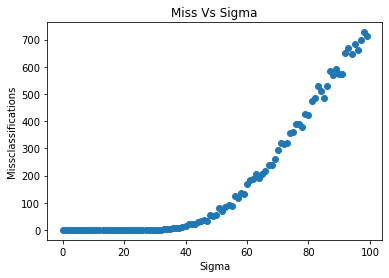

In [14]:
indx = np.arange(100)
plt.scatter(indx,misses)
plt.xlabel('Sigma')
plt.ylabel('Missclassifications')
plt.title('Miss Vs Sigma')
plt.show()

In [15]:
# Making changes to build to get the desired result for 1.3
global df 
df = pd.DataFrame()
global extra
extra = 0
def build_13(half,size):
    #print(half)
    global df
    global extra
    half = half.astype(int)
    if len(half) == 0:
        return
    if len(half) == 1:
        df = df.append(pd.DataFrame(half))
        return half
    # No. of Yi=+1 in the data set
    count = np.count_nonzero(half[:,-1:] == 1)
    count2 = np.count_nonzero(half[:,-1:] == -1)
    # If sample size threshold met
    if len(half) <= size:
        # +1 is majority
        if count >= count2:
            res = 1
        # Otherwise => -1 majority
        else:
            res = -1
        half[:,-1] = res
        df = df.append(pd.DataFrame(half))
        return half
    # If all Yi's are +1 or -1
    if count == len(half) or count == 0:
        df = df.append(pd.DataFrame(half))
        return half
    # If we did not hit the stopping condition:
    first_half,second_half,split_index,IG = split_data(half)
    if split_index > 5:
        extra += 1
    build_13(first_half,size)
    build_13(second_half,size)

In [16]:
def q1_3():
    global df
    global extra
    s = 125
    extras = np.zeros(100)
    X = generate_X(5000)
    for i in range(100):
        # Change sigma
        training = generate_data(X,i*0.01)
        training = [[x] for x in training]
        dat = np.append(X,training,1)
        dat[:,0] = np.arange(len(dat))
        build_13(dat,s)
        df = df.dropna()
        extras[i] = extras[i] + (len(df.index)-5000) + extra
        df = pd.DataFrame()
        extra = 0
    return extras
extras = q1_3()

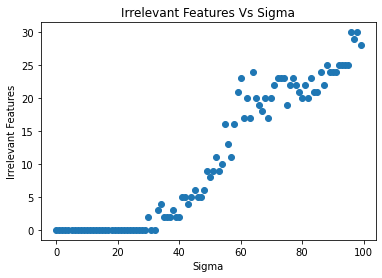

In [17]:
indx = np.arange(100)
plt.scatter(indx,extras)
plt.xlabel('Sigma')
plt.ylabel('Irrelevant Features')
plt.title('Irrelevant Features Vs Sigma')
plt.show()

In [18]:
from collections import defaultdict
global res_dict 
res_dict = defaultdict()
def build_21(half,size):
    global res_dict
    #half = half.astype(int)
    print('Sample Size: ', len(half))
    #print(half)
    #print(half.shape)
    if len(half) == 0:
        print('return')
        print()
        return
    if len(half) == 1:
        print('return',half[0][-1])
        print()
        if half[0][0] in res_dict:
            return
        res_dict[int(half[0][0])] = half[0][-1]
        return half
    # No. of Yi=+1 in the data set
    count = np.count_nonzero(half[:,-1:] == 1)
    count2 = np.count_nonzero(half[:,-1:] == -1)
    # If sample size threshold met
    if len(half) <= size:
        print('Size Threshold Met')
        print('+1: ',count,'-1: ', count2)
        # Probability of +1
        res =  count/(count+count2)
        half[:,-1] = res
        print('return',res)
        print()
        for i in range(len(half)):
            if half[i][0] not in res_dict:
                res_dict[int(half[i][0])] = half[i][-1]
        return half
    # If all Yi's are +1 or -1
    if count == len(half) or count == 0:
        print('return',half[0][-1])
        print()
        for i in range(len(half)):
            if half[i][0] not in res_dict:
                res_dict[int(half[i][0])] = half[i][-1]
        return half
    # If we did not hit the stopping condition:
    first_half,second_half,split_index,IG = split_data(half)
    print('IG: ',IG)
    print('Split at ', split_index)
    print()
    build_21(first_half,size)
    build_21(second_half,size)

In [19]:
def log_error(dat):
    global res_dict
    sum = 0
    for i in range(1,len(dat)+1):
        y = dat[i-1][-1]
        f = res_dict[i-1]
        if f != 1 and f != 0:
            sum = sum -y*math.log(f) - (1-y)*math.log(1-f)
    sum = sum/len(dat)
    return sum

def q2_1():
    global res_dict
    X = generate_X(5000)
    training = generate_data(X,0.05)
    training = [[x] for x in training]
    dat = np.append(X,training,1)
    dat[:,0] = np.arange(len(dat))
    log_errors = np.zeros(100)
    for i in range(0,5000,50):
        res_dict = defaultdict()
        dat2 = dat.copy()
        build_21(dat2,i)
        dat2[dat2 == -1] = 0
        #print("res: ", len(res_dict))
        for key in res_dict.keys():
            if res_dict[key] == -1:
                res_dict[key] = 0
        log_errors[i//50] = log_error(dat2)
    return log_errors
log_errors = q2_1()

Sample Size:  5000
IG:  [0.00000000e+00 1.12449426e-01 9.06725544e-02 1.12177462e-01
 1.06569635e-01 1.02456415e-01 3.70312768e-05 4.00352736e-04
 2.46676961e-04 2.65885666e-05 8.43133530e-05 2.49973769e-05
 3.69023711e-06 4.33866673e-07 5.07695826e-05 3.56884191e-06]
Split at  1

Sample Size:  2501
IG:  [0.00000000e+00 0.00000000e+00 1.23120514e-01 1.33690167e-01
 1.45277039e-01 1.06031261e-01 9.51064058e-04 6.89474328e-04
 7.96565784e-04 6.00126498e-04 4.73658635e-04 2.13575054e-05
 1.07619140e-05 3.75453762e-05 2.14552218e-04 3.65277463e-05]
Split at  4

Sample Size:  1294
IG:  [0.00000000e+00 0.00000000e+00 1.08961346e-01 1.33104326e-01
 0.00000000e+00 1.24917199e-01 7.46392350e-04 2.70642877e-04
 3.99875344e-04 5.51221164e-05 2.95203486e-06 1.33177340e-04
 1.16347145e-03 2.70642877e-04 1.64018343e-03 5.54803438e-04]
Split at  3

Sample Size:  701
return 1.0

Sample Size:  593
IG:  [0.00000000e+00 0.00000000e+00 2.54942607e-01 0.00000000e+00
 0.00000000e+00 3.12942679e-01 3.8920820

IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.11049802e-01
 0.00000000e+00 2.81412308e-01 3.96094647e-03 3.78885606e-04
 5.61484868e-04 5.31397524e-04 9.34194791e-04 2.71570573e-03
 2.31917917e-05 8.45971099e-04 2.71570573e-03 5.36833101e-04]
Split at  3

Sample Size:  298
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 9.99870029e-01 4.07902568e-03 2.87336121e-04
 2.68109013e-04 2.91226345e-05 1.46710420e-04 1.87437799e-02
 7.72994239e-04 1.61871069e-03 5.60716466e-03 2.30209196e-05]
Split at  5

Sample Size:  147
return 1.0

Sample Size:  151
return -1.0

Sample Size:  334
return -1.0

Sample Size:  2499
IG:  [0.00000000e+00 0.00000000e+00 1.08934386e-01 1.22985537e-01
 1.09383570e-01 1.38360241e-01 1.12529830e-04 5.40483329e-04
 7.71605163e-04 5.14099769e-04 4.16332027e-04 1.44142513e-05
 1.44507344e-04 5.65914216e-05 2.19191078e-04 7.91180500e-06]
Split at  5

Sample Size:  1257
IG:  [0.00000000e+00 0.00000000e+00 1.69512595e-01 2.07430185e-

IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 2.97351646e-01
 2.67042098e-01 0.00000000e+00 1.00417157e-03 1.53223825e-04
 1.95908171e-03 3.55485106e-03 3.61070762e-05 1.92931200e-05
 9.12204272e-04 6.90199735e-05 4.43491885e-04 2.57208650e-05]
Split at  3

Sample Size:  290
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 9.98318204e-01 0.00000000e+00 4.80229708e-03 7.95407451e-05
 1.07241494e-02 4.51996478e-03 3.77919170e-05 1.37561148e-04
 2.10835608e-04 4.50484615e-04 3.40289544e-04 8.43401280e-04]
Split at  4

Sample Size:  138
return 1.0

Sample Size:  152
return -1.0

Sample Size:  325
return -1.0

Sample Size:  627
return -1.0

Sample Size:  5000
IG:  [0.00000000e+00 1.12449426e-01 9.06725544e-02 1.12177462e-01
 1.06569635e-01 1.02456415e-01 3.70312768e-05 4.00352736e-04
 2.46676961e-04 2.65885666e-05 8.43133530e-05 2.49973769e-05
 3.69023711e-06 4.33866673e-07 5.07695826e-05 3.56884191e-06]
Split at  1

Sample Size:  2501
IG:  [0.00000000e+00 0.00000000e

IG:  [0.00000000e+00 0.00000000e+00 1.08934386e-01 1.22985537e-01
 1.09383570e-01 1.38360241e-01 1.12529830e-04 5.40483329e-04
 7.71605163e-04 5.14099769e-04 4.16332027e-04 1.44142513e-05
 1.44507344e-04 5.65914216e-05 2.19191078e-04 7.91180500e-06]
Split at  5

Sample Size:  1257
IG:  [0.00000000e+00 0.00000000e+00 1.69512595e-01 2.07430185e-01
 1.59036823e-01 0.00000000e+00 3.87700970e-04 1.58573580e-03
 6.15060131e-04 9.86693426e-05 3.20886121e-04 1.19112955e-05
 2.36480223e-04 7.98658411e-05 7.64005364e-05 7.19259552e-05]
Split at  3

Sample Size:  617
IG:  [0.00000000e+00 0.00000000e+00 2.76957564e-01 0.00000000e+00
 2.90055374e-01 0.00000000e+00 6.15517809e-03 2.71056924e-03
 1.76266467e-03 7.42990551e-06 6.04735050e-03 4.40635775e-04
 3.08178102e-04 1.83416845e-05 8.95847881e-04 7.66233292e-05]
Split at  4

Sample Size:  315
return 1.0

Sample Size:  302
IG:  [0.00000000e+00 0.00000000e+00 9.97435911e-01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 6.93456108e-03 4.57683208e-03

IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 2.97351646e-01
 2.67042098e-01 0.00000000e+00 1.00417157e-03 1.53223825e-04
 1.95908171e-03 3.55485106e-03 3.61070762e-05 1.92931200e-05
 9.12204272e-04 6.90199735e-05 4.43491885e-04 2.57208650e-05]
Split at  3

Sample Size:  290
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 9.98318204e-01 0.00000000e+00 4.80229708e-03 7.95407451e-05
 1.07241494e-02 4.51996478e-03 3.77919170e-05 1.37561148e-04
 2.10835608e-04 4.50484615e-04 3.40289544e-04 8.43401280e-04]
Split at  4

Sample Size:  138
Size Threshold Met
+1:  138 -1:  0
return 1.0

Sample Size:  152
Size Threshold Met
+1:  0 -1:  152
return 0.0

Sample Size:  325
return -1.0

Sample Size:  627
return -1.0

Sample Size:  5000
IG:  [0.00000000e+00 1.12449426e-01 9.06725544e-02 1.12177462e-01
 1.06569635e-01 1.02456415e-01 3.70312768e-05 4.00352736e-04
 2.46676961e-04 2.65885666e-05 8.43133530e-05 2.49973769e-05
 3.69023711e-06 4.33866673e-07 5.07695826e-05 3.56884191e

IG:  [0.00000000e+00 0.00000000e+00 1.08934386e-01 1.22985537e-01
 1.09383570e-01 1.38360241e-01 1.12529830e-04 5.40483329e-04
 7.71605163e-04 5.14099769e-04 4.16332027e-04 1.44142513e-05
 1.44507344e-04 5.65914216e-05 2.19191078e-04 7.91180500e-06]
Split at  5

Sample Size:  1257
IG:  [0.00000000e+00 0.00000000e+00 1.69512595e-01 2.07430185e-01
 1.59036823e-01 0.00000000e+00 3.87700970e-04 1.58573580e-03
 6.15060131e-04 9.86693426e-05 3.20886121e-04 1.19112955e-05
 2.36480223e-04 7.98658411e-05 7.64005364e-05 7.19259552e-05]
Split at  3

Sample Size:  617
IG:  [0.00000000e+00 0.00000000e+00 2.76957564e-01 0.00000000e+00
 2.90055374e-01 0.00000000e+00 6.15517809e-03 2.71056924e-03
 1.76266467e-03 7.42990551e-06 6.04735050e-03 4.40635775e-04
 3.08178102e-04 1.83416845e-05 8.95847881e-04 7.66233292e-05]
Split at  4

Sample Size:  315
Size Threshold Met
+1:  315 -1:  0
return 1.0

Sample Size:  302
Size Threshold Met
+1:  160 -1:  142
return 0.5298013245033113

Sample Size:  640
IG:  [0.0

IG:  [0.00000000e+00 0.00000000e+00 1.08934386e-01 1.22985537e-01
 1.09383570e-01 1.38360241e-01 1.12529830e-04 5.40483329e-04
 7.71605163e-04 5.14099769e-04 4.16332027e-04 1.44142513e-05
 1.44507344e-04 5.65914216e-05 2.19191078e-04 7.91180500e-06]
Split at  5

Sample Size:  1257
IG:  [0.00000000e+00 0.00000000e+00 1.69512595e-01 2.07430185e-01
 1.59036823e-01 0.00000000e+00 3.87700970e-04 1.58573580e-03
 6.15060131e-04 9.86693426e-05 3.20886121e-04 1.19112955e-05
 2.36480223e-04 7.98658411e-05 7.64005364e-05 7.19259552e-05]
Split at  3

Sample Size:  617
IG:  [0.00000000e+00 0.00000000e+00 2.76957564e-01 0.00000000e+00
 2.90055374e-01 0.00000000e+00 6.15517809e-03 2.71056924e-03
 1.76266467e-03 7.42990551e-06 6.04735050e-03 4.40635775e-04
 3.08178102e-04 1.83416845e-05 8.95847881e-04 7.66233292e-05]
Split at  4

Sample Size:  315
Size Threshold Met
+1:  315 -1:  0
return 1.0

Sample Size:  302
Size Threshold Met
+1:  160 -1:  142
return 0.5298013245033113

Sample Size:  640
IG:  [0.0

IG:  [0.00000000e+00 0.00000000e+00 1.08934386e-01 1.22985537e-01
 1.09383570e-01 1.38360241e-01 1.12529830e-04 5.40483329e-04
 7.71605163e-04 5.14099769e-04 4.16332027e-04 1.44142513e-05
 1.44507344e-04 5.65914216e-05 2.19191078e-04 7.91180500e-06]
Split at  5

Sample Size:  1257
IG:  [0.00000000e+00 0.00000000e+00 1.69512595e-01 2.07430185e-01
 1.59036823e-01 0.00000000e+00 3.87700970e-04 1.58573580e-03
 6.15060131e-04 9.86693426e-05 3.20886121e-04 1.19112955e-05
 2.36480223e-04 7.98658411e-05 7.64005364e-05 7.19259552e-05]
Split at  3

Sample Size:  617
IG:  [0.00000000e+00 0.00000000e+00 2.76957564e-01 0.00000000e+00
 2.90055374e-01 0.00000000e+00 6.15517809e-03 2.71056924e-03
 1.76266467e-03 7.42990551e-06 6.04735050e-03 4.40635775e-04
 3.08178102e-04 1.83416845e-05 8.95847881e-04 7.66233292e-05]
Split at  4

Sample Size:  315
Size Threshold Met
+1:  315 -1:  0
return 1.0

Sample Size:  302
Size Threshold Met
+1:  160 -1:  142
return 0.5298013245033113

Sample Size:  640
IG:  [0.0

IG:  [0.00000000e+00 1.12449426e-01 9.06725544e-02 1.12177462e-01
 1.06569635e-01 1.02456415e-01 3.70312768e-05 4.00352736e-04
 2.46676961e-04 2.65885666e-05 8.43133530e-05 2.49973769e-05
 3.69023711e-06 4.33866673e-07 5.07695826e-05 3.56884191e-06]
Split at  1

Sample Size:  2501
IG:  [0.00000000e+00 0.00000000e+00 1.23120514e-01 1.33690167e-01
 1.45277039e-01 1.06031261e-01 9.51064058e-04 6.89474328e-04
 7.96565784e-04 6.00126498e-04 4.73658635e-04 2.13575054e-05
 1.07619140e-05 3.75453762e-05 2.14552218e-04 3.65277463e-05]
Split at  4

Sample Size:  1294
IG:  [0.00000000e+00 0.00000000e+00 1.08961346e-01 1.33104326e-01
 0.00000000e+00 1.24917199e-01 7.46392350e-04 2.70642877e-04
 3.99875344e-04 5.51221164e-05 2.95203486e-06 1.33177340e-04
 1.16347145e-03 2.70642877e-04 1.64018343e-03 5.54803438e-04]
Split at  3

Sample Size:  701
return 1.0

Sample Size:  593
Size Threshold Met
+1:  453 -1:  140
return 0.7639123102866779

Sample Size:  1207
IG:  [0.00000000e+00 0.00000000e+00 2.2265

IG:  [0.00000000e+00 0.00000000e+00 1.08961346e-01 1.33104326e-01
 0.00000000e+00 1.24917199e-01 7.46392350e-04 2.70642877e-04
 3.99875344e-04 5.51221164e-05 2.95203486e-06 1.33177340e-04
 1.16347145e-03 2.70642877e-04 1.64018343e-03 5.54803438e-04]
Split at  3

Sample Size:  701
Size Threshold Met
+1:  701 -1:  0
return 1.0

Sample Size:  593
Size Threshold Met
+1:  453 -1:  140
return 0.7639123102866779

Sample Size:  1207
IG:  [0.00000000e+00 0.00000000e+00 2.22651904e-01 1.96300559e-01
 0.00000000e+00 1.58605307e-01 1.84272744e-03 1.49575900e-03
 2.83906187e-03 3.88831664e-04 1.88609928e-03 2.32743498e-04
 2.75179942e-06 6.36297351e-07 1.25967091e-04 9.40310294e-04]
Split at  2

Sample Size:  575
Size Threshold Met
+1:  445 -1:  130
return 0.7739130434782608

Sample Size:  632
Size Threshold Met
+1:  147 -1:  485
return 0.23259493670886075

Sample Size:  2499
IG:  [0.00000000e+00 0.00000000e+00 1.08934386e-01 1.22985537e-01
 1.09383570e-01 1.38360241e-01 1.12529830e-04 5.40483329e-

IG:  [0.00000000e+00 0.00000000e+00 1.08934386e-01 1.22985537e-01
 1.09383570e-01 1.38360241e-01 1.12529830e-04 5.40483329e-04
 7.71605163e-04 5.14099769e-04 4.16332027e-04 1.44142513e-05
 1.44507344e-04 5.65914216e-05 2.19191078e-04 7.91180500e-06]
Split at  5

Sample Size:  1257
IG:  [0.00000000e+00 0.00000000e+00 1.69512595e-01 2.07430185e-01
 1.59036823e-01 0.00000000e+00 3.87700970e-04 1.58573580e-03
 6.15060131e-04 9.86693426e-05 3.20886121e-04 1.19112955e-05
 2.36480223e-04 7.98658411e-05 7.64005364e-05 7.19259552e-05]
Split at  3

Sample Size:  617
Size Threshold Met
+1:  475 -1:  142
return 0.7698541329011345

Sample Size:  640
Size Threshold Met
+1:  158 -1:  482
return 0.246875

Sample Size:  1242
IG:  [0.00000000e+00 0.00000000e+00 1.22917319e-01 1.22622425e-01
 1.22034268e-01 0.00000000e+00 9.58566345e-04 1.23823377e-04
 4.95121980e-04 1.57810842e-03 8.41786267e-06 9.35521659e-07
 9.36477307e-05 1.96668433e-04 9.37220918e-07 3.95917523e-05]
Split at  2

Sample Size:  615
S

IG:  [0.00000000e+00 1.12449426e-01 9.06725544e-02 1.12177462e-01
 1.06569635e-01 1.02456415e-01 3.70312768e-05 4.00352736e-04
 2.46676961e-04 2.65885666e-05 8.43133530e-05 2.49973769e-05
 3.69023711e-06 4.33866673e-07 5.07695826e-05 3.56884191e-06]
Split at  1

Sample Size:  2501
IG:  [0.00000000e+00 0.00000000e+00 1.23120514e-01 1.33690167e-01
 1.45277039e-01 1.06031261e-01 9.51064058e-04 6.89474328e-04
 7.96565784e-04 6.00126498e-04 4.73658635e-04 2.13575054e-05
 1.07619140e-05 3.75453762e-05 2.14552218e-04 3.65277463e-05]
Split at  4

Sample Size:  1294
IG:  [0.00000000e+00 0.00000000e+00 1.08961346e-01 1.33104326e-01
 0.00000000e+00 1.24917199e-01 7.46392350e-04 2.70642877e-04
 3.99875344e-04 5.51221164e-05 2.95203486e-06 1.33177340e-04
 1.16347145e-03 2.70642877e-04 1.64018343e-03 5.54803438e-04]
Split at  3

Sample Size:  701
Size Threshold Met
+1:  701 -1:  0
return 1.0

Sample Size:  593
Size Threshold Met
+1:  453 -1:  140
return 0.7639123102866779

Sample Size:  1207
IG:  [0

IG:  [0.00000000e+00 0.00000000e+00 1.08934386e-01 1.22985537e-01
 1.09383570e-01 1.38360241e-01 1.12529830e-04 5.40483329e-04
 7.71605163e-04 5.14099769e-04 4.16332027e-04 1.44142513e-05
 1.44507344e-04 5.65914216e-05 2.19191078e-04 7.91180500e-06]
Split at  5

Sample Size:  1257
Size Threshold Met
+1:  633 -1:  624
return 0.5035799522673031

Sample Size:  1242
Size Threshold Met
+1:  138 -1:  1104
return 0.1111111111111111

Sample Size:  5000
IG:  [0.00000000e+00 1.12449426e-01 9.06725544e-02 1.12177462e-01
 1.06569635e-01 1.02456415e-01 3.70312768e-05 4.00352736e-04
 2.46676961e-04 2.65885666e-05 8.43133530e-05 2.49973769e-05
 3.69023711e-06 4.33866673e-07 5.07695826e-05 3.56884191e-06]
Split at  1

Sample Size:  2501
IG:  [0.00000000e+00 0.00000000e+00 1.23120514e-01 1.33690167e-01
 1.45277039e-01 1.06031261e-01 9.51064058e-04 6.89474328e-04
 7.96565784e-04 6.00126498e-04 4.73658635e-04 2.13575054e-05
 1.07619140e-05 3.75453762e-05 2.14552218e-04 3.65277463e-05]
Split at  4

Sample

IG:  [0.00000000e+00 0.00000000e+00 1.08934386e-01 1.22985537e-01
 1.09383570e-01 1.38360241e-01 1.12529830e-04 5.40483329e-04
 7.71605163e-04 5.14099769e-04 4.16332027e-04 1.44142513e-05
 1.44507344e-04 5.65914216e-05 2.19191078e-04 7.91180500e-06]
Split at  5

Sample Size:  1257
Size Threshold Met
+1:  633 -1:  624
return 0.5035799522673031

Sample Size:  1242
Size Threshold Met
+1:  138 -1:  1104
return 0.1111111111111111

Sample Size:  5000
IG:  [0.00000000e+00 1.12449426e-01 9.06725544e-02 1.12177462e-01
 1.06569635e-01 1.02456415e-01 3.70312768e-05 4.00352736e-04
 2.46676961e-04 2.65885666e-05 8.43133530e-05 2.49973769e-05
 3.69023711e-06 4.33866673e-07 5.07695826e-05 3.56884191e-06]
Split at  1

Sample Size:  2501
IG:  [0.00000000e+00 0.00000000e+00 1.23120514e-01 1.33690167e-01
 1.45277039e-01 1.06031261e-01 9.51064058e-04 6.89474328e-04
 7.96565784e-04 6.00126498e-04 4.73658635e-04 2.13575054e-05
 1.07619140e-05 3.75453762e-05 2.14552218e-04 3.65277463e-05]
Split at  4

Sample

IG:  [0.00000000e+00 0.00000000e+00 1.08934386e-01 1.22985537e-01
 1.09383570e-01 1.38360241e-01 1.12529830e-04 5.40483329e-04
 7.71605163e-04 5.14099769e-04 4.16332027e-04 1.44142513e-05
 1.44507344e-04 5.65914216e-05 2.19191078e-04 7.91180500e-06]
Split at  5

Sample Size:  1257
Size Threshold Met
+1:  633 -1:  624
return 0.5035799522673031

Sample Size:  1242
Size Threshold Met
+1:  138 -1:  1104
return 0.1111111111111111

Sample Size:  5000
IG:  [0.00000000e+00 1.12449426e-01 9.06725544e-02 1.12177462e-01
 1.06569635e-01 1.02456415e-01 3.70312768e-05 4.00352736e-04
 2.46676961e-04 2.65885666e-05 8.43133530e-05 2.49973769e-05
 3.69023711e-06 4.33866673e-07 5.07695826e-05 3.56884191e-06]
Split at  1

Sample Size:  2501
IG:  [0.00000000e+00 0.00000000e+00 1.23120514e-01 1.33690167e-01
 1.45277039e-01 1.06031261e-01 9.51064058e-04 6.89474328e-04
 7.96565784e-04 6.00126498e-04 4.73658635e-04 2.13575054e-05
 1.07619140e-05 3.75453762e-05 2.14552218e-04 3.65277463e-05]
Split at  4

Sample

IG:  [0.00000000e+00 1.12449426e-01 9.06725544e-02 1.12177462e-01
 1.06569635e-01 1.02456415e-01 3.70312768e-05 4.00352736e-04
 2.46676961e-04 2.65885666e-05 8.43133530e-05 2.49973769e-05
 3.69023711e-06 4.33866673e-07 5.07695826e-05 3.56884191e-06]
Split at  1

Sample Size:  2501
Size Threshold Met
+1:  1746 -1:  755
return 0.6981207516993203

Sample Size:  2499
Size Threshold Met
+1:  771 -1:  1728
return 0.3085234093637455

Sample Size:  5000
IG:  [0.00000000e+00 1.12449426e-01 9.06725544e-02 1.12177462e-01
 1.06569635e-01 1.02456415e-01 3.70312768e-05 4.00352736e-04
 2.46676961e-04 2.65885666e-05 8.43133530e-05 2.49973769e-05
 3.69023711e-06 4.33866673e-07 5.07695826e-05 3.56884191e-06]
Split at  1

Sample Size:  2501
Size Threshold Met
+1:  1746 -1:  755
return 0.6981207516993203

Sample Size:  2499
Size Threshold Met
+1:  771 -1:  1728
return 0.3085234093637455

Sample Size:  5000
IG:  [0.00000000e+00 1.12449426e-01 9.06725544e-02 1.12177462e-01
 1.06569635e-01 1.02456415e-01 3.7

IG:  [0.00000000e+00 1.12449426e-01 9.06725544e-02 1.12177462e-01
 1.06569635e-01 1.02456415e-01 3.70312768e-05 4.00352736e-04
 2.46676961e-04 2.65885666e-05 8.43133530e-05 2.49973769e-05
 3.69023711e-06 4.33866673e-07 5.07695826e-05 3.56884191e-06]
Split at  1

Sample Size:  2501
Size Threshold Met
+1:  1746 -1:  755
return 0.6981207516993203

Sample Size:  2499
Size Threshold Met
+1:  771 -1:  1728
return 0.3085234093637455

Sample Size:  5000
IG:  [0.00000000e+00 1.12449426e-01 9.06725544e-02 1.12177462e-01
 1.06569635e-01 1.02456415e-01 3.70312768e-05 4.00352736e-04
 2.46676961e-04 2.65885666e-05 8.43133530e-05 2.49973769e-05
 3.69023711e-06 4.33866673e-07 5.07695826e-05 3.56884191e-06]
Split at  1

Sample Size:  2501
Size Threshold Met
+1:  1746 -1:  755
return 0.6981207516993203

Sample Size:  2499
Size Threshold Met
+1:  771 -1:  1728
return 0.3085234093637455

Sample Size:  5000
IG:  [0.00000000e+00 1.12449426e-01 9.06725544e-02 1.12177462e-01
 1.06569635e-01 1.02456415e-01 3.7

IG:  [0.00000000e+00 1.12449426e-01 9.06725544e-02 1.12177462e-01
 1.06569635e-01 1.02456415e-01 3.70312768e-05 4.00352736e-04
 2.46676961e-04 2.65885666e-05 8.43133530e-05 2.49973769e-05
 3.69023711e-06 4.33866673e-07 5.07695826e-05 3.56884191e-06]
Split at  1

Sample Size:  2501
Size Threshold Met
+1:  1746 -1:  755
return 0.6981207516993203

Sample Size:  2499
Size Threshold Met
+1:  771 -1:  1728
return 0.3085234093637455

Sample Size:  5000
IG:  [0.00000000e+00 1.12449426e-01 9.06725544e-02 1.12177462e-01
 1.06569635e-01 1.02456415e-01 3.70312768e-05 4.00352736e-04
 2.46676961e-04 2.65885666e-05 8.43133530e-05 2.49973769e-05
 3.69023711e-06 4.33866673e-07 5.07695826e-05 3.56884191e-06]
Split at  1

Sample Size:  2501
Size Threshold Met
+1:  1746 -1:  755
return 0.6981207516993203

Sample Size:  2499
Size Threshold Met
+1:  771 -1:  1728
return 0.3085234093637455

Sample Size:  5000
IG:  [0.00000000e+00 1.12449426e-01 9.06725544e-02 1.12177462e-01
 1.06569635e-01 1.02456415e-01 3.7

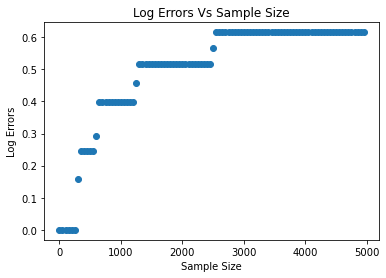

In [20]:
indx = np.arange(100)
plt.scatter(indx*50,log_errors)
plt.xlabel('Sample Size')
plt.ylabel('Log Errors')
plt.title('Log Errors Vs Sample Size')
plt.show()

In [21]:
'The error is similar to previous but has more consistency among groups, sample size remains same'

'The error is similar to previous but has more consistency among groups, sample size remains same'

In [ ]:
# Sigmoid Function
def sigmoid(x):
    return 1/(1 + np.exp(-x))
# Regression Function
def F(w,x):
    return sigmoid(np.dot(w,x))
# Log Reg using SGD
def log_reg(dat,alpha_t):
    # Stores Current Prediction
    global res_dict
    # List of errors until time t
    errors = []
    # Pick an initial guess
    w_t = np.ones(16)
    # Until Convergence:
    for i in range(5000):
        # Choose a random index 
        a = np.random.choice(5000)
        x = dat[a,:-1]
        y = dat[a,-1:]
        res_dict = defaultdict()
        # Update predictions for w_t
        for i in range(len(dat)):
            res_dict[i] = F(w_t,dat[:,0:16][i])
        # Add errors to error log
        errors.append(log_error(dat))
        #print(errors[len(errors)-1])
        # If error is insignificant , break
        if errors[len(errors)-1] < 0.001:
            break
        # Update w_t
        w_t_1 = w_t - alpha_t * (F(w_t,x)-y) * x
        w_t = w_t_1
    return errors,w_t

X = generate_X(5000)
training = generate_data(X,0.05)
training = [[x] for x in training]
dat = np.append(X,training,1)
dat[:,0] = 1
dat[dat == -1] = 0
errors,wt = log_reg(dat,0.05)



In [ ]:
indx = np.arange(len(errors))
plt.scatter(indx,errors)
plt.xlabel('Time')
plt.ylabel('Log Errors')
plt.title('Log Errors Vs Time')
plt.show()

In [ ]:
def testing_dat(wt):
    global res_dict
    # Generate testing data
    X = generate_X(500)
    testing = generate_data(X,0.05)
    testing = [[x] for x in testing]
    dat = np.append(X,testing,1)
    dat[:,0] = 1
    dat[dat == -1] = 0
    # Use result from above to get predictions
    for i in range(500):
        res_dict[i] = F(wt,dat[i,:-1])
    # Calculate error
    error = log_error(dat)
    return error
err = testing_dat(wt)

In [ ]:
print(err)

In [ ]:
'The error is consistent for training and teting so overfitting might not be an issue'

In [ ]:
'''
I think regression is better because tree comes to conclusion fast, sometimes if one variable is +1 it might claim all data is +1
Same for reducing influence of irrelevant features, can be measured by comparing the difference of adding one feature vs not having it in the model
'''